# Measuring all 5 protocols and 4 player sizes (720p+) (quality auto) on the test VM -- 1 video only

In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [2]:
conn = sqlite3.connect('../web-performance/web-performance-youtube-single-vm-5-proto.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

msm_id              py_time       js_time  \
0     e5f5130a-84cb-c651-f453-00b705527bbe  1645468238183222636  1.645468e+12   
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7  1645468273208159312  1.645468e+12   
2     715bcb78-35e4-41aa-d9b7-0384e0529b0d  1645468311162760538  1.645468e+12   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b  1645468346352580760  1.645468e+12   
4     29d2303e-194c-8890-0671-5cc5ddb105a9  1645468384332457386  1.645468e+12   
...                                    ...                  ...           ...   
5755  7fc327ea-bb5b-bb73-27a0-74ba67028b08  1645726930200769828  1.645727e+12   
5756  8873bf38-d59a-436c-4a3a-4b276b086fed  1645726968672145651  1.645727e+12   
5757  97fa3754-09a9-7aca-eef4-8c6ad8e54d73  1645727004084054021  1.645727e+12   
5758  2554af40-4bca-1453-620e-e3fc543e6579  1645727043787334914  1.645727e+12   
5759  b66de919-30f9-0a39-982a-346f71909a8b  1645727079205964964  1.645727e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
0             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
1             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
2             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
3             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
4             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
5755          1.645727e+12      udp  94.140.14.140  aqz-KE-bpKQ                
5756          1.645727e+12      udp  94.140.14.140  aqz-KE-bpKQ                
5757          1.645727e+12      udp  94.140.14.140  aqz-KE-bpKQ                
5758          1.645727e+12      udp  94.140.14.140  aqz-KE-bpKQ                
5759          1.645727e+12      udp  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality  player_width  \
0     2022-02-21 18:30:04.722114              auto          1280   
1     2022-02-21 18:30:39.976429              auto          1280   
2     2022-02-21 18:31:17.708532              auto          1920   
3     2022-02-21 18:31:52.991132              auto          1920   
4     2022-02-21 18:32:30.880862              auto          2560   
...                          ...               ...           ...   
5755  2022-02-24 18:21:36.854341              auto          1920   
5756  2022-02-24 18:22:15.099059              auto          2560   
5757  2022-02-24 18:22:50.521243              auto          2560   
5758  2022-02-24 18:23:30.198866              auto          3840   
5759  2022-02-24 18:24:05.642080              auto          3840   

      player_height  start_time  play_time    video_ids  cacheWarming error  
0               720           0         30  aqz-KE-bpKQ             1        
1               720           0         30  aqz-KE-bpKQ             0        
2              1080           0         30  aqz-KE-bpKQ             1        
3              1080           0         30  aqz-KE-bpKQ             0        
4              1440           0         30  aqz-KE-bpKQ             1        
...             ...         ...        ...          ...           ...   ...  
5755           1080           0         30  aqz-KE-bpKQ             0        
5756           1440           0         30  aqz-KE-bpKQ             1        
5757           1440           0         30  aqz-KE-bpKQ             0        
5758           2160           0         30  aqz-KE-bpKQ             1        
5759           2160           0         30  aqz-KE-bpKQ             0        

[5760 rows x 17 columns]

# data pre-processing

In [3]:
measurements.error.value_counts()

                                                                                        5759
failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n       1
Name: error, dtype: int64

In [4]:
measurements = measurements[measurements.error == '']

remove cache warming runs early to reduce processing later on

In [5]:
measurements = measurements[measurements.cacheWarming == 0]

In [6]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [7]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [8]:
dns_proto_mapping = {'QUIC':'DoQ', 'HTTPS':'DoH', 'TLS':'DoT', 'TCP':'DoTCP', 'UDP':'DoUDP'}
def map_proto_to_dns(x):
    return dns_proto_mapping[x]
measurements['protocol'] = measurements['protocol'].map(map_proto_to_dns)

In [9]:
measurements

msm_id              py_time       js_time  \
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7  1645468273208159312  1.645468e+12   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b  1645468346352580760  1.645468e+12   
5     d74843ac-1555-a3c5-d2db-8fda373bf567  1645468419605662461  1.645468e+12   
7     f8d1925d-ed30-5035-7754-a9c06da9ef10  1645468494295011517  1.645468e+12   
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3  1645468568187263088  1.645469e+12   
...                                    ...                  ...           ...   
5751  dfa7f008-6f0a-fb44-7375-b6a756722a65  1645726780923626844  1.645727e+12   
5753  6855ccc6-165b-ca4e-7f5d-864637395d7a  1645726855432572949  1.645727e+12   
5755  7fc327ea-bb5b-bb73-27a0-74ba67028b08  1645726930200769828  1.645727e+12   
5757  97fa3754-09a9-7aca-eef4-8c6ad8e54d73  1645727004084054021  1.645727e+12   
5759  b66de919-30f9-0a39-982a-346f71909a8b  1645727079205964964  1.645727e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
3             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
5             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
7             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
9             1.645469e+12      DoH  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
5751          1.645727e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
5753          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
5755          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
5757          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
5759          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
1     2022-02-21 18:30:39.976429              auto         1280           720   
3     2022-02-21 18:31:52.991132              auto         1920          1080   
5     2022-02-21 18:33:06.320152              auto         2560          1440   
7     2022-02-21 18:34:20.893513              auto         3840          2160   
9     2022-02-21 18:35:34.789859              auto         1280           720   
...                          ...               ...          ...           ...   
5751  2022-02-24 18:19:07.125092              auto         3840          2160   
5753  2022-02-24 18:20:22.271147              auto         1280           720   
5755  2022-02-24 18:21:36.854341              auto         1920          1080   
5757  2022-02-24 18:22:50.521243              auto         2560          1440   
5759  2022-02-24 18:24:05.642080              auto         3840          2160   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1              0         30  aqz-KE-bpKQ             0                1280x720  
3              0         30  aqz-KE-bpKQ             0               1920x1080  
5              0         30  aqz-KE-bpKQ             0               2560x1440  
7              0         30  aqz-KE-bpKQ             0               3840x2160  
9              0         30  aqz-KE-bpKQ             0                1280x720  
...          ...        ...          ...           ...   ...               ...  
5751           0         30  aqz-KE-bpKQ             0               3840x2160  
5753           0         30  aqz-KE-bpKQ             0                1280x720  
5755           0         30  aqz-KE-bpKQ             0               1920x1080  
5757           0         30  aqz-KE-bpKQ             0               2560x1440  
5759           0         30  aqz-KE-bpKQ             0               3840x2160  

[2879 rows x 18 columns]

## find the optimal resolution as determined by the youtube player for each run

In [10]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT msm_id, resolution, time FROM nerd_stats
""", conn)

In [11]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [12]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

In [13]:
df_optimal_resolutions.groupby('msm_id').optimal_res.nunique().sort_values()

msm_id
000cb26c-2bc8-ff19-9df5-fe639fbd611c    1
aaa8a0cc-1f0b-231c-6059-d1c5f740738e    1
aa8cde16-4bb0-d982-5112-bbc88d78c890    1
aa8597ae-780d-c967-1d89-e5f6460a240c    1
aa6ff5b0-f6ad-2a5b-f918-43d5df4e2bea    1
                                       ..
5e16161e-681c-b9fd-f00b-09f8b8fe976b    2
40506e66-0285-2d47-8142-e07d60e12065    2
30dfd39f-8f36-95b1-23bb-9490189daa89    2
491aa013-5323-1fab-7ac7-69f8fd3d8760    2
ba581ef5-c9a1-39f0-8d13-39091bfbfae9    2
Name: optimal_res, Length: 5759, dtype: int64

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [14]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [15]:
s_filter_msm[s_filter_msm > 1].index.tolist()

['30dfd39f-8f36-95b1-23bb-9490189daa89',
 '40506e66-0285-2d47-8142-e07d60e12065',
 '491aa013-5323-1fab-7ac7-69f8fd3d8760',
 '58ec003e-3c48-4b1d-9ee8-0bc2def94ae2',
 '5c56630d-ba70-1f4b-84af-ed480416bb88',
 '5e16161e-681c-b9fd-f00b-09f8b8fe976b',
 '9377e896-b27e-ecd7-0171-e6f36be579d1',
 'ba581ef5-c9a1-39f0-8d13-39091bfbfae9',
 'd947ce75-a2cb-05b8-7be7-b917cb0d0a24']

In [16]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

time
msm_id                               optimal_res                              
9377e896-b27e-ecd7-0171-e6f36be579d1 3840x2160   2022-02-21 20:49:16.884100096
                                     2560x1440   2022-02-21 20:49:34.595300096
40506e66-0285-2d47-8142-e07d60e12065 3840x2160   2022-02-21 23:19:10.119800064
                                     2560x1440   2022-02-21 23:19:40.011599872
5c56630d-ba70-1f4b-84af-ed480416bb88 3840x2160   2022-02-22 06:13:38.568499968
                                     2560x1440   2022-02-22 06:14:04.034800128
491aa013-5323-1fab-7ac7-69f8fd3d8760 3840x2160   2022-02-22 11:38:44.539200000
                                     2560x1440   2022-02-22 11:39:04.265099776
ba581ef5-c9a1-39f0-8d13-39091bfbfae9 3840x2160   2022-02-22 11:49:09.017999872
                                     2560x1440   2022-02-22 11:49:26.622700032
d947ce75-a2cb-05b8-7be7-b917cb0d0a24 3840x2160   2022-02-23 00:38:44.534500096
                                     2560x1440   2022-02-23 00:39:04.747899904
58ec003e-3c48-4b1d-9ee8-0bc2def94ae2 3840x2160   2022-02-23 16:13:41.016000000
                                     2560x1440   2022-02-23 16:14:01.195200256
5e16161e-681c-b9fd-f00b-09f8b8fe976b 3840x2160   2022-02-24 10:53:28.588399872
                                     2560x1440   2022-02-24 10:53:58.570700032
30dfd39f-8f36-95b1-23bb-9490189daa89 3840x2160   2022-02-24 14:08:45.629200128
                                     2560x1440   2022-02-24 14:09:15.542500096

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [17]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [18]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [19]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

msm_id  opt_res_num  \
1960  58ec003e-3c48-4b1d-9ee8-0bc2def94ae2            2   
4881  d947ce75-a2cb-05b8-7be7-b917cb0d0a24            2   
3298  9377e896-b27e-ecd7-0171-e6f36be579d1            2   
2047  5c56630d-ba70-1f4b-84af-ed480416bb88            2   
2083  5e16161e-681c-b9fd-f00b-09f8b8fe976b            2   
1434  40506e66-0285-2d47-8142-e07d60e12065            2   
1108  30dfd39f-8f36-95b1-23bb-9490189daa89            2   
1646  491aa013-5323-1fab-7ac7-69f8fd3d8760            2   
4194  ba581ef5-c9a1-39f0-8d13-39091bfbfae9            2   

                opt_res_list  
1960  [3840x2160, 2560x1440]  
4881  [3840x2160, 2560x1440]  
3298  [3840x2160, 2560x1440]  
2047  [3840x2160, 2560x1440]  
2083  [3840x2160, 2560x1440]  
1434  [3840x2160, 2560x1440]  
1108  [3840x2160, 2560x1440]  
1646  [3840x2160, 2560x1440]  
4194  [3840x2160, 2560x1440]

In [20]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [21]:
measurements_to_remove

['58ec003e-3c48-4b1d-9ee8-0bc2def94ae2',
 'd947ce75-a2cb-05b8-7be7-b917cb0d0a24',
 '9377e896-b27e-ecd7-0171-e6f36be579d1',
 '5c56630d-ba70-1f4b-84af-ed480416bb88',
 '5e16161e-681c-b9fd-f00b-09f8b8fe976b',
 '40506e66-0285-2d47-8142-e07d60e12065',
 '30dfd39f-8f36-95b1-23bb-9490189daa89',
 '491aa013-5323-1fab-7ac7-69f8fd3d8760',
 'ba581ef5-c9a1-39f0-8d13-39091bfbfae9']

In [22]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

3840x2160    3
Name: player_dimensions, dtype: int64

In [23]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

DoTCP    3
Name: protocol, dtype: int64

In [24]:
measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

DoT      144
DoUDP    144
DoH      144
DoTCP    144
DoQ      144
Name: protocol, dtype: int64

In [25]:
measurements = measurements[~measurements.msm_id.isin(measurements_to_remove)]

In [26]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [27]:
df_optimal_resolutions

msm_id optimal_res
0     e5f5130a-84cb-c651-f453-00b705527bbe    1280x720
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7    1280x720
2     715bcb78-35e4-41aa-d9b7-0384e0529b0d   1920x1080
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b   1920x1080
4     29d2303e-194c-8890-0671-5cc5ddb105a9   2560x1440
...                                    ...         ...
5745  7fc327ea-bb5b-bb73-27a0-74ba67028b08   1920x1080
5746  8873bf38-d59a-436c-4a3a-4b276b086fed   2560x1440
5747  97fa3754-09a9-7aca-eef4-8c6ad8e54d73   2560x1440
5748  2554af40-4bca-1453-620e-e3fc543e6579   3840x2160
5749  b66de919-30f9-0a39-982a-346f71909a8b   3840x2160

[5750 rows x 2 columns]

In [28]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

msm_id optimal_res player_dimensions
0     8c5231a9-bc42-28d8-1dba-e0f25b423ca7    1280x720          1280x720
1     c25cd82a-2a61-3909-cafb-f0d8c477bf5b   1920x1080         1920x1080
2     d74843ac-1555-a3c5-d2db-8fda373bf567   2560x1440         2560x1440
3     f8d1925d-ed30-5035-7754-a9c06da9ef10   3840x2160         3840x2160
4     bc7212a0-3cb7-6003-a118-73152ac4dfc3    1280x720          1280x720
...                                    ...         ...               ...
2871  dfa7f008-6f0a-fb44-7375-b6a756722a65   3840x2160         3840x2160
2872  6855ccc6-165b-ca4e-7f5d-864637395d7a    1280x720          1280x720
2873  7fc327ea-bb5b-bb73-27a0-74ba67028b08   1920x1080         1920x1080
2874  97fa3754-09a9-7aca-eef4-8c6ad8e54d73   2560x1440         2560x1440
2875  b66de919-30f9-0a39-982a-346f71909a8b   3840x2160         3840x2160

[2876 rows x 3 columns]

### make sure the optimal resolutions match what we set as the player size

In [29]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

Empty DataFrame
Columns: [msm_id, optimal_res, player_dimensions]
Index: []

### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [30]:
df_player_state_playing = pd.read_sql_query("select time, msm_id, curr_play_time from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [31]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    4476.000000
mean       19.914643
std         2.329116
min         3.117650
25%        17.943333
50%        19.350333
75%        21.121000
max        30.485333
Name: curr_play_time, dtype: float64

In [32]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    5759.000000
mean        0.022185
std         0.013063
min         0.003587
25%         0.016882
50%         0.020562
75%         0.023634
max         0.223887
Name: curr_play_time, dtype: float64

In [33]:
df_player_state_intial_playback = df_player_state_playing[(df_player_state_playing.curr_play_time < 1) & 
                                    (df_player_state_playing.msm_id.isin(measurements.msm_id.unique()))]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [34]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [35]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)
df_start_time = df_start_time[df_start_time.msm_id.isin(measurements.msm_id.unique())]

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [36]:
df_start_time

start_time                     play_time  \
1    2022-02-21 18:30:42.292100096 2022-02-21 18:30:42.688600064   
3    2022-02-21 18:31:55.329699840 2022-02-21 18:31:55.718899968   
5    2022-02-21 18:33:08.666700032 2022-02-21 18:33:09.061799936   
7    2022-02-21 18:34:23.242800128 2022-02-21 18:34:23.732999936   
9    2022-02-21 18:35:37.206300160 2022-02-21 18:35:37.607599872   
...                            ...                           ...   
5750 2022-02-24 18:19:09.667300096 2022-02-24 18:19:10.076100096   
5752 2022-02-24 18:20:24.585100032 2022-02-24 18:20:24.981199872   
5754 2022-02-24 18:21:39.232699904 2022-02-24 18:21:39.538899968   
5756 2022-02-24 18:22:53.012100096 2022-02-24 18:22:53.480699904   
5758 2022-02-24 18:24:07.986400256 2022-02-24 18:24:08.439900160   

                                    msm_id initial_quality  startup_delay  
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7           hd720         0.3965  
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b          hd1080         0.3892  
5     d74843ac-1555-a3c5-d2db-8fda373bf567          hd1440         0.3951  
7     f8d1925d-ed30-5035-7754-a9c06da9ef10          hd2160         0.4902  
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3           hd720         0.4013  
...                                    ...             ...            ...  
5750  dfa7f008-6f0a-fb44-7375-b6a756722a65          hd2160         0.4088  
5752  6855ccc6-165b-ca4e-7f5d-864637395d7a           hd720         0.3961  
5754  7fc327ea-bb5b-bb73-27a0-74ba67028b08          hd1080         0.3062  
5756  97fa3754-09a9-7aca-eef4-8c6ad8e54d73          hd1440         0.4686  
5758  b66de919-30f9-0a39-982a-346f71909a8b          hd1440         0.4535  

[2876 rows x 5 columns]

### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [37]:
df_player_quality_change_event = pd.read_sql_query("select msm_id, time, curr_play_time, current_quality from iframe_api where event_type LIKE 'QualityChange%'", conn)
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.msm_id.isin(measurements.msm_id.unique())]

In [38]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [39]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000     5697
0.020292        1
0.020352        1
0.021482        1
0.021591        1
             ... 
27.740415       1
27.809542       1
27.866526       1
27.891982       1
27.909668       1
Name: curr_play_time, Length: 472, dtype: int64

In [40]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

d1a87a5d-fea4-c0ee-bcfd-c7ec974dae82    3
50f6a874-dd90-a25b-6c8c-7da911dcc509    3
41e65018-f369-2869-7658-4e29451b314a    3
4f329824-6b91-4fc2-2577-325391637e26    3
fb902a01-1ff3-b5d2-fce5-9bd5fbee355d    2
                                       ..
3c2034dd-52fa-8d0c-b431-1b82f53e6c02    1
5c977b06-d219-92f2-4113-fdf437023de0    1
22195640-8264-55cc-5e6a-952dc25ecbe4    1
d08424ba-6221-9928-26d1-572a73acb5f9    1
9e153996-955e-39b5-26f6-3ce481995792    1
Name: msm_id, Length: 2876, dtype: int64

In [41]:
df_player_quality_change_event[df_player_quality_change_event.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

msm_id                          time  \
4355  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:57.994099968   
4356  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.090500096   
4357  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.229199872   

      curr_play_time current_quality  
4355             0.0          medium  
4356             0.0          hd1080  
4357             0.0          hd1440

In [42]:
measurements[measurements.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

msm_id              py_time       js_time  \
2029  41e65018-f369-2869-7658-4e29451b314a  1645559308868757683  1.645559e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
2029          1.645559e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
2029  2022-02-22 19:47:55.463169              auto         2560          1440   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
2029           0         30  aqz-KE-bpKQ             0               2560x1440

In [43]:
df_start_time[df_start_time.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

start_time                     play_time  \
2029 2022-02-22 19:47:57.773899776 2022-02-22 19:47:58.288799744   

                                    msm_id initial_quality  startup_delay  
2029  41e65018-f369-2869-7658-4e29451b314a          hd1440         0.5149

In [44]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [45]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [46]:
df_true_initial_quality[df_true_initial_quality.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

msm_id                     play_time  \
2053  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.288799744   
2054  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.288799744   
2055  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.288799744   

     initial_quality                          time current_quality  \
2053          hd1440 2022-02-22 19:47:57.994099968          medium   
2054          hd1440 2022-02-22 19:47:58.090500096          hd1080   
2055          hd1440 2022-02-22 19:47:58.229199872          hd1440   

      delay_to_play_time  
2053              0.2947  
2054              0.1983  
2055              0.0596

In [47]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [48]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [49]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

msm_id                     play_time  \
81    069cc40b-5558-292f-dbbe-ff385490a050 2022-02-23 01:43:01.096599808   
154   0d064b24-1dc0-bcef-e3b3-b88e9c52ff8e 2022-02-22 20:30:42.965799680   
431   27138275-ad2d-0841-ee25-a033a083a549 2022-02-24 13:16:39.559800064   
672   3c2034dd-52fa-8d0c-b431-1b82f53e6c02 2022-02-23 18:48:02.162800128   
878   4d11c43c-b285-1a99-88e6-5e14af3e69bf 2022-02-22 12:45:25.146200064   
969   568734a1-fe37-b6f5-fd29-eef56ab46287 2022-02-24 13:15:26.043899904   
1030  5b825975-179a-5237-72e9-402e771b4746 2022-02-23 11:00:43.120300032   
1104  62ae3322-9341-974b-77d1-9dc80e077fe3 2022-02-24 18:13:02.085799936   
1530  8ad79c51-acc2-01d4-225d-55a1791e3982 2022-02-23 20:30:42.276600064   
1676  967a72ed-20ce-4cb5-45f8-719e7636fa5d 2022-02-22 18:14:16.187000064   
1750  9c45cbdd-081f-ee23-78e3-db3ed1852090 2022-02-22 19:01:56.153399808   
1775  9e153996-955e-39b5-26f6-3ce481995792 2022-02-23 22:20:23.060199936   
1982  b0186976-ba67-6fd6-72c6-202c6ca9f227 2022-02-23 05:47:55.517200128   
2161  c023b64b-fa8b-c921-8420-d569bf166fd4 2022-02-23 05:49:09.069499904   
2408  d73665d4-0fb1-b7da-a218-6016e229c4aa 2022-02-22 10:44:13.367599872   
2434  d8d509fe-33f7-953b-7cfa-341d0f0ef548 2022-02-21 21:50:24.768099840   
2873  fff214a2-aa9e-849d-257d-0fef31523c59 2022-02-23 12:43:02.072499968   

     initial_quality                          time current_quality  \
81            hd1440 2022-02-23 01:43:00.924800000          medium   
154            hd720 2022-02-22 20:30:42.617899776          medium   
431           hd1080 2022-02-24 13:16:39.406099968          medium   
672           hd1080 2022-02-23 18:48:01.755399936          medium   
878            hd720 2022-02-22 12:45:25.026300160          medium   
969            hd720 2022-02-24 13:15:25.942400000          medium   
1030           hd720 2022-02-23 11:00:43.005099776          medium   
1104          hd1440 2022-02-24 18:13:01.537499904          medium   
1530           hd720 2022-02-23 20:30:42.131699968          medium   
1676          hd2160 2022-02-22 18:14:16.069299712          medium   
1750          hd1080 2022-02-22 19:01:55.988100096          medium   
1775           hd720 2022-02-23 22:20:22.815300096          medium   
1982          hd1440 2022-02-23 05:47:55.335900160          medium   
2161          hd2160 2022-02-23 05:49:08.975899904          medium   
2408          hd1440 2022-02-22 10:44:13.262099968          medium   
2434           hd720 2022-02-21 21:50:24.626500096          medium   
2873          hd1440 2022-02-23 12:43:01.792899840          medium   

      delay_to_play_time  
81                0.1718  
154               0.3479  
431               0.1537  
672               0.4074  
878               0.1199  
969               0.1015  
1030              0.1152  
1104              0.5483  
1530              0.1449  
1676              0.1177  
1750              0.1653  
1775              0.2449  
1982              0.1813  
2161              0.0936  
2408              0.1055  
2434              0.1416  
2873              0.2796

In [50]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [51]:
df_true_initial_quality

msm_id                     play_time  \
0     00753b37-0262-91d7-a915-087ae3d4d72f 2022-02-23 11:13:02.739899904   
1     00863967-9e6e-6960-9295-86e7adead4ac 2022-02-23 05:10:33.070500096   
2     008efbfb-be1f-394b-0bc2-df624557c686 2022-02-23 13:15:29.762800128   
3     00913f69-9dc1-0b77-8530-2b3e0ed6e490 2022-02-23 15:39:21.996800000   
4     00c0df40-316d-2dea-0057-673134024619 2022-02-23 06:43:01.150200064   
...                                    ...                           ...   
2871  ffc3eec5-1e48-b565-8661-7373e8c4a5ce 2022-02-23 14:47:56.300400128   
2872  ffe7edb0-ff10-bec3-07a7-e1bef8c62c82 2022-02-23 02:06:53.185600000   
2873  fff214a2-aa9e-849d-257d-0fef31523c59 2022-02-23 12:43:02.072499968   
2874  fff93290-8a90-ada1-b96e-e8c6c2893f86 2022-02-22 23:22:49.362800128   
2875  fffda141-c88d-af5f-148d-6fccde7900e3 2022-02-22 22:34:22.939400192   

     initial_quality                          time true_initial_quality  \
0             hd1440 2022-02-23 11:13:02.708000000               hd1440   
1              hd720 2022-02-23 05:10:32.973899776                hd720   
2              hd720 2022-02-23 13:15:29.672399872                hd720   
3             hd2160 2022-02-23 15:39:21.943500032               hd2160   
4             hd1440 2022-02-23 06:43:01.070700032               hd1440   
...              ...                           ...                  ...   
2871          hd1440 2022-02-23 14:47:56.175699968               hd1440   
2872          hd1080 2022-02-23 02:06:53.136999936               hd1080   
2873          hd1440 2022-02-23 12:43:01.792899840               medium   
2874          hd1440 2022-02-22 23:22:49.350400256               hd1440   
2875          hd2160 2022-02-22 22:34:22.860699904               hd2160   

      delay_to_play_time  
0                 0.0319  
1                 0.0966  
2                 0.0904  
3                 0.0533  
4                 0.0795  
...                  ...  
2871              0.1247  
2872              0.0486  
2873              0.2796  
2874              0.0124  
2875              0.0787  

[2876 rows x 6 columns]

### helper functions

In [52]:
res_to_quality = {
    "256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [53]:
df_resource_timing = pd.read_sql_query("SELECT msm_id, name, nextHopProtocol FROM page_resources", conn)
#df_resource_timing = df_resource_timing[df_resource_timing.msm_id.isin(measurements.msm_id.unique())]

In [54]:
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [55]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-4g5ednly.googlevideo.com',
       'rr2---sn-4g5lzner.googlevideo.com',
       'rr1---sn-1gieen7e.googlevideo.com',
       'rr2---sn-5hne6nsr.googlevideo.com',
       'rr2---sn-5hnekn7z.googlevideo.com'], dtype=object)

In [56]:
def find_initial_requests(url_):
    parse_res = urlparse(url_)
    opts = parse_qs(parse_res.query)
    if opts['range'][0][0] == '0':
        return True
    return False
df_resource_timing['first_request'] = df_resource_timing['name'].map(find_initial_requests)

In [57]:
df_resource_timing['h1_first_request'] = False
df_resource_timing['h1_first_request'] = np.where((df_resource_timing.nextHopProtocol == 'http/1.1') & (df_resource_timing.first_request == True), True, df_resource_timing['h1_first_request'])

In [58]:
df_resource_timing = pd.merge(df_resource_timing, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [59]:
df_resource_timing[df_resource_timing.cacheWarming == 0].groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo')

msm_id  googlevideo
0     00753b37-0262-91d7-a915-087ae3d4d72f            1
1913  aa34e455-fb03-4bae-ded9-fc10fe4d6e3a            1
1914  aa3a2d34-c514-9e79-adfc-b50c80d92647            1
1915  aa41e5d2-b50d-fae0-9450-75eb4ae080d8            1
1916  aa54adbd-4949-d1e7-2e84-186db603987b            1
...                                    ...          ...
964   55bf903c-c95d-8530-a554-38a5a9343119            1
956   549d4f52-03f9-808e-3da3-2bb7e1f747e5            1
2878  fffda141-c88d-af5f-148d-6fccde7900e3            1
310   1b4106f8-6bef-fe77-bfd5-0788130e44be            2
2560  e3a4cd27-3970-2264-d53a-a1e11813538c            2

[2879 rows x 2 columns]

In [60]:
df_caught_first_request = df_resource_timing.groupby('msm_id', as_index=False).agg({'first_request': lambda x: sum(x) > 0, 'h1_first_request': lambda x: sum(x) > 0})

In [61]:
print(df_caught_first_request[df_caught_first_request.first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())

931
4828
5759
301
5458
5759


In [62]:
df_caught_first_request = pd.merge(df_caught_first_request, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [63]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())

417
2462
2879
125
2754
2879


In [64]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())

514
2366
2880
176
2704
2880


In [65]:
df_resource_timing.msm_id.nunique()

5759

In [66]:
df_resource_timing.groupby(['player_dimensions', 'googlevideo']).agg({'cacheWarming':lambda x: list(set(x))})

cacheWarming
player_dimensions googlevideo                                   
1280x720          rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
1920x1080         rr1---sn-1gieen7e.googlevideo.com       [0, 1]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
2560x1440         rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
                  rr2---sn-5hnekn7z.googlevideo.com          [1]
3840x2160         rr1---sn-1gieen7e.googlevideo.com          [1]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com          [0]

In [67]:
df_resource_timing[(df_resource_timing.googlevideo == 'rr2---sn-5hne6nsr.googlevideo.com') & (df_resource_timing.player_dimensions == '3840x2160')]

msm_id  \
34632  d08424ba-6221-9928-26d1-572a73acb5f9   
34633  d08424ba-6221-9928-26d1-572a73acb5f9   
34634  d08424ba-6221-9928-26d1-572a73acb5f9   
34635  d08424ba-6221-9928-26d1-572a73acb5f9   
34636  d08424ba-6221-9928-26d1-572a73acb5f9   
34637  d08424ba-6221-9928-26d1-572a73acb5f9   
34638  d08424ba-6221-9928-26d1-572a73acb5f9   
34639  d08424ba-6221-9928-26d1-572a73acb5f9   
34640  d08424ba-6221-9928-26d1-572a73acb5f9   
34641  d08424ba-6221-9928-26d1-572a73acb5f9   
34642  d08424ba-6221-9928-26d1-572a73acb5f9   
34643  d08424ba-6221-9928-26d1-572a73acb5f9   
34644  d08424ba-6221-9928-26d1-572a73acb5f9   
34645  d08424ba-6221-9928-26d1-572a73acb5f9   

                                                    name nextHopProtocol  \
34632  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34633  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34634  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34635  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34636  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34637  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34638  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34639  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34640  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34641  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34642  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34643  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34644  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   
34645  https://rr2---sn-5hne6nsr.googlevideo.com/vide...              h3   

                             googlevideo  first_request  h1_first_request  \
34632  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34633  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34634  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34635  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34636  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34637  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34638  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34639  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34640  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34641  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34642  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34643  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34644  rr2---sn-5hne6nsr.googlevideo.com          False             False   
34645  rr2---sn-5hne6nsr.googlevideo.com          False             False   

       cacheWarming player_dimensions                   timestamp  
34632             0         3840x2160  2022-02-23 01:34:22.448481  
34633             0         3840x2160  2022-02-23 01:34:22.448481  
34634             0         3840x2160  2022-02-23 01:34:22.448481  
34635             0         3840x2160  2022-02-23 01:34:22.448481  
34636             0         3840x2160  2022-02-23 01:34:22.448481  
34637             0         3840x2160  2022-02-23 01:34:22.448481  
34638             0         3840x2160  2022-02-23 01:34:22.448481  
34639             0         3840x2160  2022-02-23 01:34:22.448481  
34640             0         3840x2160  2022-02-23 01:34:22.448481  
34641             0         3840x2160  2022-02-23 01:34:22.448481  
34642             0         3840x2160  2022-02-23 01:34:22.448481  
34643             0         3840x2160  2022-02-23 01:34:22.448481  
34644             0         3840x2160  2022-02-23 01:34:22.448481  
34645             0         3840x2160  2022-02-23 01:34:22.448481

In [68]:
all_measurements = pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn)

In [69]:
all_measurements[all_measurements.msm_id == "d08424ba-6221-9928-26d1-572a73acb5f9"]

msm_id  cacheWarming player_dimensions  \
2487  d08424ba-6221-9928-26d1-572a73acb5f9             0         3840x2160   

                       timestamp  
2487  2022-02-23 01:34:22.448481

In [70]:
all_measurements.iloc[2486]

msm_id               6954276f-fecb-0f99-7b3a-701512801034
cacheWarming                                            1
player_dimensions                               3840x2160
timestamp                      2022-02-23 01:33:46.790736
Name: 2486, dtype: object

In [71]:
df_resource_timing[df_resource_timing.msm_id == "6954276f-fecb-0f99-7b3a-701512801034"]

msm_id  \
34617  6954276f-fecb-0f99-7b3a-701512801034   
34618  6954276f-fecb-0f99-7b3a-701512801034   
34619  6954276f-fecb-0f99-7b3a-701512801034   
34620  6954276f-fecb-0f99-7b3a-701512801034   
34621  6954276f-fecb-0f99-7b3a-701512801034   
34622  6954276f-fecb-0f99-7b3a-701512801034   
34623  6954276f-fecb-0f99-7b3a-701512801034   
34624  6954276f-fecb-0f99-7b3a-701512801034   
34625  6954276f-fecb-0f99-7b3a-701512801034   
34626  6954276f-fecb-0f99-7b3a-701512801034   
34627  6954276f-fecb-0f99-7b3a-701512801034   
34628  6954276f-fecb-0f99-7b3a-701512801034   
34629  6954276f-fecb-0f99-7b3a-701512801034   
34630  6954276f-fecb-0f99-7b3a-701512801034   
34631  6954276f-fecb-0f99-7b3a-701512801034   

                                                    name nextHopProtocol  \
34617  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34618  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34619  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34620  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34621  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34622  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34623  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34624  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34625  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34626  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34627  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34628  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34629  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34630  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   
34631  https://rr2---sn-4g5lzner.googlevideo.com/vide...              h3   

                             googlevideo  first_request  h1_first_request  \
34617  rr2---sn-4g5lzner.googlevideo.com          False             False   
34618  rr2---sn-4g5lzner.googlevideo.com          False             False   
34619  rr2---sn-4g5lzner.googlevideo.com          False             False   
34620  rr2---sn-4g5lzner.googlevideo.com          False             False   
34621  rr2---sn-4g5lzner.googlevideo.com          False             False   
34622  rr2---sn-4g5lzner.googlevideo.com           True             False   
34623  rr2---sn-4g5lzner.googlevideo.com          False             False   
34624  rr2---sn-4g5lzner.googlevideo.com          False             False   
34625  rr2---sn-4g5lzner.googlevideo.com          False             False   
34626  rr2---sn-4g5lzner.googlevideo.com          False             False   
34627  rr2---sn-4g5lzner.googlevideo.com          False             False   
34628  rr2---sn-4g5lzner.googlevideo.com          False             False   
34629  rr2---sn-4g5lzner.googlevideo.com          False             False   
34630  rr2---sn-4g5lzner.googlevideo.com          False             False   
34631  rr2---sn-4g5lzner.googlevideo.com          False             False   

       cacheWarming player_dimensions                   timestamp  
34617             1         3840x2160  2022-02-23 01:33:46.790736  
34618             1         3840x2160  2022-02-23 01:33:46.790736  
34619             1         3840x2160  2022-02-23 01:33:46.790736  
34620             1         3840x2160  2022-02-23 01:33:46.790736  
34621             1         3840x2160  2022-02-23 01:33:46.790736  
34622             1         3840x2160  2022-02-23 01:33:46.790736  
34623             1         3840x2160  2022-02-23 01:33:46.790736  
34624             1         3840x2160  2022-02-23 01:33:46.790736  
34625             1         3840x2160  2022-02-23 01:33:46.790736  
34626             1         3840x2160  2022-02-23 01:33:46.790736  
34627             1         3840x2160  2022-02-23 01:33:46.790736  
34628             

In [72]:
#df_start_time = df_start_time[~df_start_time.msm_id.isin(measurements_to_remove)]
df_start_time

start_time                     play_time  \
1    2022-02-21 18:30:42.292100096 2022-02-21 18:30:42.688600064   
3    2022-02-21 18:31:55.329699840 2022-02-21 18:31:55.718899968   
5    2022-02-21 18:33:08.666700032 2022-02-21 18:33:09.061799936   
7    2022-02-21 18:34:23.242800128 2022-02-21 18:34:23.732999936   
9    2022-02-21 18:35:37.206300160 2022-02-21 18:35:37.607599872   
...                            ...                           ...   
5750 2022-02-24 18:19:09.667300096 2022-02-24 18:19:10.076100096   
5752 2022-02-24 18:20:24.585100032 2022-02-24 18:20:24.981199872   
5754 2022-02-24 18:21:39.232699904 2022-02-24 18:21:39.538899968   
5756 2022-02-24 18:22:53.012100096 2022-02-24 18:22:53.480699904   
5758 2022-02-24 18:24:07.986400256 2022-02-24 18:24:08.439900160   

                                    msm_id initial_quality  startup_delay  
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7           hd720         0.3965  
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b          hd1080         0.3892  
5     d74843ac-1555-a3c5-d2db-8fda373bf567          hd1440         0.3951  
7     f8d1925d-ed30-5035-7754-a9c06da9ef10          hd2160         0.4902  
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3           hd720         0.4013  
...                                    ...             ...            ...  
5750  dfa7f008-6f0a-fb44-7375-b6a756722a65          hd2160         0.4088  
5752  6855ccc6-165b-ca4e-7f5d-864637395d7a           hd720         0.3961  
5754  7fc327ea-bb5b-bb73-27a0-74ba67028b08          hd1080         0.3062  
5756  97fa3754-09a9-7aca-eef4-8c6ad8e54d73          hd1440         0.4686  
5758  b66de919-30f9-0a39-982a-346f71909a8b          hd1440         0.4535  

[2876 rows x 5 columns]

In [73]:
measurements

msm_id              py_time       js_time  \
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7  1645468273208159312  1.645468e+12   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b  1645468346352580760  1.645468e+12   
5     d74843ac-1555-a3c5-d2db-8fda373bf567  1645468419605662461  1.645468e+12   
7     f8d1925d-ed30-5035-7754-a9c06da9ef10  1645468494295011517  1.645468e+12   
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3  1645468568187263088  1.645469e+12   
...                                    ...                  ...           ...   
5751  dfa7f008-6f0a-fb44-7375-b6a756722a65  1645726780923626844  1.645727e+12   
5753  6855ccc6-165b-ca4e-7f5d-864637395d7a  1645726855432572949  1.645727e+12   
5755  7fc327ea-bb5b-bb73-27a0-74ba67028b08  1645726930200769828  1.645727e+12   
5757  97fa3754-09a9-7aca-eef4-8c6ad8e54d73  1645727004084054021  1.645727e+12   
5759  b66de919-30f9-0a39-982a-346f71909a8b  1645727079205964964  1.645727e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
3             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
5             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
7             1.645468e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
9             1.645469e+12      DoH  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
5751          1.645727e+12    DoTCP  94.140.14.140  aqz-KE-bpKQ                
5753          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
5755          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
5757          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
5759          1.645727e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
1     2022-02-21 18:30:39.976429              auto         1280           720   
3     2022-02-21 18:31:52.991132              auto         1920          1080   
5     2022-02-21 18:33:06.320152              auto         2560          1440   
7     2022-02-21 18:34:20.893513              auto         3840          2160   
9     2022-02-21 18:35:34.789859              auto         1280           720   
...                          ...               ...          ...           ...   
5751  2022-02-24 18:19:07.125092              auto         3840          2160   
5753  2022-02-24 18:20:22.271147              auto         1280           720   
5755  2022-02-24 18:21:36.854341              auto         1920          1080   
5757  2022-02-24 18:22:50.521243              auto         2560          1440   
5759  2022-02-24 18:24:05.642080              auto         3840          2160   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1              0         30  aqz-KE-bpKQ             0                1280x720  
3              0         30  aqz-KE-bpKQ             0               1920x1080  
5              0         30  aqz-KE-bpKQ             0               2560x1440  
7              0         30  aqz-KE-bpKQ             0               3840x2160  
9              0         30  aqz-KE-bpKQ             0                1280x720  
...          ...        ...          ...           ...   ...               ...  
5751           0         30  aqz-KE-bpKQ             0               3840x2160  
5753           0         30  aqz-KE-bpKQ             0                1280x720  
5755           0         30  aqz-KE-bpKQ             0               1920x1080  
5757           0         30  aqz-KE-bpKQ             0               2560x1440  
5759           0         30  aqz-KE-bpKQ             0               3840x2160  

[2876 rows x 18 columns]

In [74]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [75]:
#df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [76]:
df_start_time.protocol.value_counts()

DoT      576
DoUDP    576
DoQ      576
DoH      575
DoTCP    573
Name: protocol, dtype: int64

In [77]:
df_start_time.columns

Index(['start_time', 'play_time', 'msm_id', 'initial_quality', 'startup_delay',
       'player_dimensions', 'protocol', 'vantagePoint', 'domain'],
      dtype='object')

In [78]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [79]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

start_time                     play_time  \
135  2022-02-21 21:50:24.404099840 2022-02-21 21:50:24.768099840   
649  2022-02-22 10:44:12.994500096 2022-02-22 10:44:13.367599872   
729  2022-02-22 12:45:24.786200064 2022-02-22 12:45:25.146200064   
948  2022-02-22 18:14:15.842200064 2022-02-22 18:14:16.187000064   
978  2022-02-22 19:01:55.705100032 2022-02-22 19:01:56.153399808   
1037 2022-02-22 20:30:42.343200000 2022-02-22 20:30:42.965799680   
1247 2022-02-23 01:43:00.704899840 2022-02-23 01:43:01.096599808   
1411 2022-02-23 05:47:55.115200256 2022-02-23 05:47:55.517200128   
1412 2022-02-23 05:49:08.779600128 2022-02-23 05:49:09.069499904   
1616 2022-02-23 11:00:42.783500032 2022-02-23 11:00:43.120300032   
1686 2022-02-23 12:43:01.419300096 2022-02-23 12:43:02.072499968   
1930 2022-02-23 18:48:01.296399872 2022-02-23 18:48:02.162800128   
1996 2022-02-23 20:30:41.910200064 2022-02-23 20:30:42.276600064   
2072 2022-02-23 22:20:22.438100224 2022-02-23 22:20:23.060199936   
2668 2022-02-24 13:15:25.722400000 2022-02-24 13:15:26.043899904   
2669 2022-02-24 13:16:39.136499968 2022-02-24 13:16:39.559800064   
2866 2022-02-24 18:13:01.164100096 2022-02-24 18:13:02.085799936   

                                    msm_id initial_quality  startup_delay  \
135   d8d509fe-33f7-953b-7cfa-341d0f0ef548           hd720         0.3640   
649   d73665d4-0fb1-b7da-a218-6016e229c4aa          hd1440         0.3731   
729   4d11c43c-b285-1a99-88e6-5e14af3e69bf           hd720         0.3600   
948   967a72ed-20ce-4cb5-45f8-719e7636fa5d          hd2160         0.3448   
978   9c45cbdd-081f-ee23-78e3-db3ed1852090          hd1080         0.4483   
1037  0d064b24-1dc0-bcef-e3b3-b88e9c52ff8e           hd720         0.6226   
1247  069cc40b-5558-292f-dbbe-ff385490a050          hd1440         0.3917   
1411  b0186976-ba67-6fd6-72c6-202c6ca9f227          hd1440         0.4020   
1412  c023b64b-fa8b-c921-8420-d569bf166fd4          hd2160         0.2899   
1616  5b825975-179a-5237-72e9-402e771b4746           hd720         0.3368   
1686  fff214a2-aa9e-849d-257d-0fef31523c59          hd1440         0.6532   
1930  3c2034dd-52fa-8d0c-b431-1b82f53e6c02          hd1080         0.8664   
1996  8ad79c51-acc2-01d4-225d-55a1791e3982           hd720         0.3664   
2072  9e153996-955e-39b5-26f6-3ce481995792           hd720         0.6221   
2668  568734a1-fe37-b6f5-fd29-eef56ab46287           hd720         0.3215   
2669  27138275-ad2d-0841-ee25-a033a083a549          hd1080         0.4233   
2866  62ae3322-9341-974b-77d1-9dc80e077fe3          hd1440         0.9217   

     player_dimensions protocol vantagePoint       domain true_initial_quality  
135           1280x720    DoUDP               aqz-KE-bpKQ               medium  
649          3840x2160      DoQ               aqz-KE-bpKQ               medium  
729           1280x720    DoTCP               aqz-KE-bpKQ               medium  
948          3840x2160      DoQ               aqz-KE-bpKQ               medium  
978          1920x1080      DoT               aqz-KE-bpKQ               medium  
1037          1280x720      DoT               aqz-KE-bpKQ               medium  
1247         2560x1440      DoQ               aqz-KE-bpKQ               medium  
1411         2560x1440    DoTCP               aqz-KE-bpKQ               medium  
1412         3840x2160    DoTCP               aqz-KE-bpKQ               medium  
1616          1280x720      DoT               aqz-KE-bpKQ               medium  
1686         2560x1440      DoQ               aqz-KE-bpKQ               medium  
1930         2560x1440    DoTCP               aqz-KE-bpKQ               medium  
1996          1280x720      DoT               aqz-KE-bpKQ               medium  
2072          1280x720    DoUDP               aqz-KE-bpKQ               medium  
2668          1280x720    DoTCP               aqz-KE-bpKQ               medium  
2669         1920x1080    DoTCP               aqz-KE-bpKQ               medium  
2866         2560x1440      DoQ    

In [80]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [81]:
df_player_quality_change_event['curr_qual_as_res'] = df_player_quality_change_event['current_quality'].map(map_quality_to_res)

In [82]:
df_player_started = pd.read_sql_query("""
SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction'
""", conn)
df_player_started = df_player_started[df_player_started.msm_id.isin(measurements.msm_id.unique())]

df_player_started['start_time'] = pd.to_datetime(df_player_started['start_time'], unit='ms', origin='unix')


#df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [83]:
df_optimal_resolutions

msm_id optimal_res player_dimensions
0     8c5231a9-bc42-28d8-1dba-e0f25b423ca7    1280x720          1280x720
1     c25cd82a-2a61-3909-cafb-f0d8c477bf5b   1920x1080         1920x1080
2     d74843ac-1555-a3c5-d2db-8fda373bf567   2560x1440         2560x1440
3     f8d1925d-ed30-5035-7754-a9c06da9ef10   3840x2160         3840x2160
4     bc7212a0-3cb7-6003-a118-73152ac4dfc3    1280x720          1280x720
...                                    ...         ...               ...
2871  dfa7f008-6f0a-fb44-7375-b6a756722a65   3840x2160         3840x2160
2872  6855ccc6-165b-ca4e-7f5d-864637395d7a    1280x720          1280x720
2873  7fc327ea-bb5b-bb73-27a0-74ba67028b08   1920x1080         1920x1080
2874  97fa3754-09a9-7aca-eef4-8c6ad8e54d73   2560x1440         2560x1440
2875  b66de919-30f9-0a39-982a-346f71909a8b   3840x2160         3840x2160

[2876 rows x 3 columns]

In [84]:
df_player_quality_change_event = pd.merge(df_player_quality_change_event, df_optimal_resolutions[['msm_id', 'optimal_res']], on='msm_id')
df_player_quality_change_event

msm_id                          time  \
0     8c5231a9-bc42-28d8-1dba-e0f25b423ca7 2022-02-21 18:30:42.525100032   
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7 2022-02-21 18:30:42.588600064   
2     c25cd82a-2a61-3909-cafb-f0d8c477bf5b 2022-02-21 18:31:55.545199872   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b 2022-02-21 18:31:55.628099840   
4     d74843ac-1555-a3c5-d2db-8fda373bf567 2022-02-21 18:33:08.901900032   
...                                    ...                           ...   
6163  97fa3754-09a9-7aca-eef4-8c6ad8e54d73 2022-02-24 18:22:53.360000000   
6164  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:08.209900032   
6165  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:08.291300096   
6166  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:12.760300032   
6167  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:38.871800064   

      curr_play_time current_quality curr_qual_as_res optimal_res  
0           0.000000          medium          640x360    1280x720  
1           0.000000           hd720         1280x720    1280x720  
2           0.000000          medium          640x360   1920x1080  
3           0.000000          hd1080        1920x1080   1920x1080  
4           0.000000          medium          640x360   2560x1440  
...              ...             ...              ...         ...  
6163        0.000000          hd1440        2560x1440   2560x1440  
6164        0.000000          medium          640x360   3840x2160  
6165        0.000000          hd1440        2560x1440   3840x2160  
6166        4.268852          hd2160        3840x2160   3840x2160  
6167       27.593122          hd1440        2560x1440   3840x2160  

[6168 rows x 6 columns]

In [85]:
df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res].msm_id.nunique()

2876

In [86]:
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res]

In [87]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].curr_play_time.value_counts()

0.000000    2673
4.534570       1
1.348461       1
0.112170       1
1.319103       1
            ... 
1.185601       1
0.285635       1
0.868588       1
0.155915       1
0.020292       1
Name: curr_play_time, Length: 204, dtype: int64

In [88]:
assert set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.value_counts().values) == {1}
assert df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique() == measurements.msm_id.nunique()
df_player_quality_change_event_to_opt = df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].reset_index(drop=True)


In [89]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt[['msm_id', 'time', 'optimal_res']], df_player_started,on='msm_id')

In [90]:

df_player_quality_change_event_to_opt['optimal_quality_delay'] = (df_player_quality_change_event_to_opt['time'] - df_player_quality_change_event_to_opt['start_time']).dt.total_seconds()
df_player_quality_change_event_to_opt

msm_id                          time  \
0     00753b37-0262-91d7-a915-087ae3d4d72f 2022-02-23 11:13:02.708000000   
1     00863967-9e6e-6960-9295-86e7adead4ac 2022-02-23 05:10:32.973899776   
2     008efbfb-be1f-394b-0bc2-df624557c686 2022-02-23 13:15:29.672399872   
3     00913f69-9dc1-0b77-8530-2b3e0ed6e490 2022-02-23 15:39:21.943500032   
4     00c0df40-316d-2dea-0057-673134024619 2022-02-23 06:43:01.070700032   
...                                    ...                           ...   
2871  ffc3eec5-1e48-b565-8661-7373e8c4a5ce 2022-02-23 14:47:56.175699968   
2872  ffe7edb0-ff10-bec3-07a7-e1bef8c62c82 2022-02-23 02:06:53.136999936   
2873  fff214a2-aa9e-849d-257d-0fef31523c59 2022-02-23 12:43:02.073999872   
2874  fff93290-8a90-ada1-b96e-e8c6c2893f86 2022-02-22 23:22:49.350400256   
2875  fffda141-c88d-af5f-148d-6fccde7900e3 2022-02-22 22:34:22.860699904   

     optimal_res                    start_time  optimal_quality_delay  
0      2560x1440 2022-02-23 11:13:02.400499968                 0.3075  
1       1280x720 2022-02-23 05:10:32.707699968                 0.2662  
2       1280x720 2022-02-23 13:15:29.356000000                 0.3164  
3      3840x2160 2022-02-23 15:39:21.640300032                 0.3032  
4      2560x1440 2022-02-23 06:43:00.769699840                 0.3010  
...          ...                           ...                    ...  
2871   2560x1440 2022-02-23 14:47:55.922100224                 0.2536  
2872   1920x1080 2022-02-23 02:06:52.851500032                 0.2855  
2873   2560x1440 2022-02-23 12:43:01.419300096                 0.6547  
2874   2560x1440 2022-02-22 23:22:49.022300160                 0.3281  
2875   3840x2160 2022-02-22 22:34:22.610500096                 0.2502  

[2876 rows x 5 columns]

In [91]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')

In [92]:
df_buffering_events = pd.read_sql_query("""
SELECT time, curr_play_time, current_quality, msm_id FROM iframe_api WHERE event_type = 'PlayerStateBUFFERING'
""", conn)

df_buffering_events = df_buffering_events[df_buffering_events.msm_id.isin(measurements.msm_id.unique())]

#df_buffering_events_time = pd.merge(df_buffering_events, measurements[measurements.cacheWarming == 0][['msm_id', 'player_dimensions', 'domain']], on='msm_id')

In [93]:
df_buffering_events['time'] = pd.to_datetime(df_buffering_events['time'], unit='ms', origin='unix')

In [94]:
#df_buffering_events_time['time'] = pd.to_datetime(df_buffering_events_time['time'], unit='ms', origin='unix')

In [95]:
#df_buffering_events_time = df_buffering_events_time[~df_buffering_events_time.msm_id.isin(measurements_to_remove)]

In [96]:
df_buffering_events[df_buffering_events.curr_play_time > 1].current_quality.unique()

array(['hd1440', 'hd2160', 'hd1080', 'hd720'], dtype=object)

filter out buffering events that happened before the player started playing

In [97]:
df_playback_started = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1
""", conn)
df_playback_started = df_playback_started[df_playback_started.msm_id.isin(measurements.msm_id.unique())]

df_playback_started['play_time'] = pd.to_datetime(df_playback_started['play_time'], unit='ms', origin='unix')

In [98]:
#df_playback_started = df_playback_started[~df_playback_started.msm_id.isin(measurements_to_remove)]

In [99]:
df_playback_started

play_time                                msm_id  \
1    2022-02-21 18:30:42.688600064  8c5231a9-bc42-28d8-1dba-e0f25b423ca7   
3    2022-02-21 18:31:55.718899968  c25cd82a-2a61-3909-cafb-f0d8c477bf5b   
5    2022-02-21 18:33:09.061799936  d74843ac-1555-a3c5-d2db-8fda373bf567   
7    2022-02-21 18:34:23.732999936  f8d1925d-ed30-5035-7754-a9c06da9ef10   
9    2022-02-21 18:35:37.607599872  bc7212a0-3cb7-6003-a118-73152ac4dfc3   
...                            ...                                   ...   
5750 2022-02-24 18:19:10.076100096  dfa7f008-6f0a-fb44-7375-b6a756722a65   
5752 2022-02-24 18:20:24.981199872  6855ccc6-165b-ca4e-7f5d-864637395d7a   
5754 2022-02-24 18:21:39.538899968  7fc327ea-bb5b-bb73-27a0-74ba67028b08   
5756 2022-02-24 18:22:53.480699904  97fa3754-09a9-7aca-eef4-8c6ad8e54d73   
5758 2022-02-24 18:24:08.439900160  b66de919-30f9-0a39-982a-346f71909a8b   

     current_quality  
1              hd720  
3             hd1080  
5             hd1440  
7             hd2160  
9              hd720  
...              ...  
5750          hd2160  
5752           hd720  
5754          hd1080  
5756          hd1440  
5758          hd1440  

[2876 rows x 3 columns]

In [100]:
df_buffering_events_time = pd.merge(df_buffering_events, df_playback_started[['msm_id', 'play_time']], on='msm_id')

In [101]:
df_buffering_events_time = df_buffering_events_time[df_buffering_events_time.time > df_buffering_events_time.play_time]

In [102]:
df_buffering_events_time = pd.merge(df_buffering_events_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_buffering_events_time


time  curr_play_time current_quality  \
0    2022-02-21 18:33:28.358600192       19.257751          hd1440   
1    2022-02-21 18:34:41.664099840       17.827359          hd2160   
2    2022-02-21 18:34:49.198300160       21.016369          hd2160   
3    2022-02-21 18:38:23.379600128       19.264330          hd1440   
4    2022-02-21 18:39:36.728199936       17.853944          hd2160   
...                            ...             ...             ...   
2519 2022-02-24 18:23:12.762500096       19.267790          hd1440   
2520 2022-02-24 18:24:26.501499904       17.996308          hd2160   
2521 2022-02-24 18:24:30.491200256       21.482314          hd2160   
2522 2022-02-24 18:24:34.550900224       24.678629          hd2160   
2523 2022-02-24 18:24:38.857299968       27.593122          hd2160   

                                    msm_id                     play_time  \
0     d74843ac-1555-a3c5-d2db-8fda373bf567 2022-02-21 18:33:09.061799936   
1     f8d1925d-ed30-5035-7754-a9c06da9ef10 2022-02-21 18:34:23.732999936   
2     f8d1925d-ed30-5035-7754-a9c06da9ef10 2022-02-21 18:34:23.732999936   
3     0807a679-f141-6b05-6d43-f0d21eb75803 2022-02-21 18:38:04.086100224   
4     f2524213-7fe3-4778-30ae-d373c4bf82e0 2022-02-21 18:39:18.829299712   
...                                    ...                           ...   
2519  97fa3754-09a9-7aca-eef4-8c6ad8e54d73 2022-02-24 18:22:53.480699904   
2520  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:08.439900160   
2521  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:08.439900160   
2522  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:08.439900160   
2523  b66de919-30f9-0a39-982a-346f71909a8b 2022-02-24 18:24:08.439900160   

     player_dimensions protocol vantagePoint       domain  
0            2560x1440      DoT               aqz-KE-bpKQ  
1            3840x2160      DoT               aqz-KE-bpKQ  
2            3840x2160      DoT               aqz-KE-bpKQ  
3            2560x1440      DoH               aqz-KE-bpKQ  
4            3840x2160      DoH               aqz-KE-bpKQ  
...                ...      ...          ...          ...  
2519         2560x1440    DoUDP               aqz-KE-bpKQ  
2520         3840x2160    DoUDP               aqz-KE-bpKQ  
2521         3840x2160    DoUDP               aqz-KE-bpKQ  
2522         3840x2160    DoUDP               aqz-KE-bpKQ  
2523         3840x2160    DoUDP               aqz-KE-bpKQ  

[2524 rows x 9 columns]

In [103]:
#df_buffering_events_time.rename(columns=lambda x: x.replace('domain_x', 'domain'), inplace=True)
#df_buffering_events_time.rename(columns=lambda x: x.replace('player_dimensions_x', 'player_dimensions'), inplace=True)

In [104]:
df_playback_restarted = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time >= 1
""", conn)
df_playback_restarted = df_playback_restarted[df_playback_restarted.msm_id.isin(measurements.msm_id.unique())]

df_playback_restarted['play_time'] = pd.to_datetime(df_playback_restarted['play_time'], unit='ms', origin='unix')
#df_playback_restarted = df_playback_restarted[~df_playback_restarted.msm_id.isin(measurements_to_remove)]

In [105]:
df_buffering_events.dtypes


time               datetime64[ns]
curr_play_time            float64
current_quality            object
msm_id                     object
dtype: object

In [106]:
df_stall_times = pd.merge_asof(df_playback_restarted, df_buffering_events, by='msm_id', left_on='play_time', right_on='time', direction='backward')

In [107]:
df_stall_times = pd.merge(df_stall_times, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_stall_times

play_time                                msm_id  \
0    2022-02-21 18:33:28.827600128  d74843ac-1555-a3c5-d2db-8fda373bf567   
1    2022-02-21 18:34:46.007899904  f8d1925d-ed30-5035-7754-a9c06da9ef10   
2    2022-02-21 18:34:52.224599808  f8d1925d-ed30-5035-7754-a9c06da9ef10   
3    2022-02-21 18:38:23.850200320  0807a679-f141-6b05-6d43-f0d21eb75803   
4    2022-02-21 18:39:41.264699904  f2524213-7fe3-4778-30ae-d373c4bf82e0   
...                            ...                                   ...   
2234 2022-02-24 18:19:38.654200064  dfa7f008-6f0a-fb44-7375-b6a756722a65   
2235 2022-02-24 18:23:13.172100096  97fa3754-09a9-7aca-eef4-8c6ad8e54d73   
2236 2022-02-24 18:24:26.999400192  b66de919-30f9-0a39-982a-346f71909a8b   
2237 2022-02-24 18:24:31.340800000  b66de919-30f9-0a39-982a-346f71909a8b   
2238 2022-02-24 18:24:35.861200128  b66de919-30f9-0a39-982a-346f71909a8b   

     current_quality_x                          time  curr_play_time  \
0               hd1440 2022-02-21 18:33:28.358600192       19.257751   
1               hd2160 2022-02-21 18:34:41.664099840       17.827359   
2               hd2160 2022-02-21 18:34:49.198300160       21.016369   
3               hd1440 2022-02-21 18:38:23.379600128       19.264330   
4               hd2160 2022-02-21 18:39:36.728199936       17.853944   
...                ...                           ...             ...   
2234            hd2160 2022-02-24 18:19:35.586800128       21.060608   
2235            hd1440 2022-02-24 18:23:12.762500096       19.267790   
2236            hd2160 2022-02-24 18:24:26.501499904       17.996308   
2237            hd2160 2022-02-24 18:24:30.491200256       21.482314   
2238            hd2160 2022-02-24 18:24:34.550900224       24.678629   

     current_quality_y player_dimensions protocol vantagePoint       domain  
0               hd1440         2560x1440      DoT               aqz-KE-bpKQ  
1               hd2160         3840x2160      DoT               aqz-KE-bpKQ  
2               hd2160         3840x2160      DoT               aqz-KE-bpKQ  
3               hd1440         2560x1440      DoH               aqz-KE-bpKQ  
4               hd2160         3840x2160      DoH               aqz-KE-bpKQ  
...                ...               ...      ...          ...          ...  
2234            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
2235            hd1440         2560x1440    DoUDP               aqz-KE-bpKQ  
2236            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ  
2237            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ  
2238            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ  

[2239 rows x 10 columns]

In [108]:

df_stall_times['stall_time'] = (df_stall_times['play_time'] - df_stall_times['time']).dt.total_seconds()

In [109]:
df_stall_times

play_time                                msm_id  \
0    2022-02-21 18:33:28.827600128  d74843ac-1555-a3c5-d2db-8fda373bf567   
1    2022-02-21 18:34:46.007899904  f8d1925d-ed30-5035-7754-a9c06da9ef10   
2    2022-02-21 18:34:52.224599808  f8d1925d-ed30-5035-7754-a9c06da9ef10   
3    2022-02-21 18:38:23.850200320  0807a679-f141-6b05-6d43-f0d21eb75803   
4    2022-02-21 18:39:41.264699904  f2524213-7fe3-4778-30ae-d373c4bf82e0   
...                            ...                                   ...   
2234 2022-02-24 18:19:38.654200064  dfa7f008-6f0a-fb44-7375-b6a756722a65   
2235 2022-02-24 18:23:13.172100096  97fa3754-09a9-7aca-eef4-8c6ad8e54d73   
2236 2022-02-24 18:24:26.999400192  b66de919-30f9-0a39-982a-346f71909a8b   
2237 2022-02-24 18:24:31.340800000  b66de919-30f9-0a39-982a-346f71909a8b   
2238 2022-02-24 18:24:35.861200128  b66de919-30f9-0a39-982a-346f71909a8b   

     current_quality_x                          time  curr_play_time  \
0               hd1440 2022-02-21 18:33:28.358600192       19.257751   
1               hd2160 2022-02-21 18:34:41.664099840       17.827359   
2               hd2160 2022-02-21 18:34:49.198300160       21.016369   
3               hd1440 2022-02-21 18:38:23.379600128       19.264330   
4               hd2160 2022-02-21 18:39:36.728199936       17.853944   
...                ...                           ...             ...   
2234            hd2160 2022-02-24 18:19:35.586800128       21.060608   
2235            hd1440 2022-02-24 18:23:12.762500096       19.267790   
2236            hd2160 2022-02-24 18:24:26.501499904       17.996308   
2237            hd2160 2022-02-24 18:24:30.491200256       21.482314   
2238            hd2160 2022-02-24 18:24:34.550900224       24.678629   

     current_quality_y player_dimensions protocol vantagePoint       domain  \
0               hd1440         2560x1440      DoT               aqz-KE-bpKQ   
1               hd2160         3840x2160      DoT               aqz-KE-bpKQ   
2               hd2160         3840x2160      DoT               aqz-KE-bpKQ   
3               hd1440         2560x1440      DoH               aqz-KE-bpKQ   
4               hd2160         3840x2160      DoH               aqz-KE-bpKQ   
...                ...               ...      ...          ...          ...   
2234            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
2235            hd1440         2560x1440    DoUDP               aqz-KE-bpKQ   
2236            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ   
2237            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ   
2238            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ   

      stall_time  
0         0.4690  
1         4.3438  
2         3.0263  
3         0.4706  
4         4.5365  
...          ...  
2234      3.0674  
2235      0.4096  
2236      0.4979  
2237      0.8496  
2238      1.3103  

[2239 rows x 11 columns]

In [110]:
def draw_cdf(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    if col_name_ == 'protocol':
        line_order =['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='best', ncol=2, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.tick_params(axis='x', which='minor', labelsize=6)


                    ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    ax.set_ylim(-0.1,1.1)
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)

                    if log:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    else:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()

In [111]:
def draw_cdf_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    if col_name_ == 'protocol':
        line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                num_rows = math.ceil(df_[col_outer_groupby_].nunique()/2)
                if df_[col_outer_groupby_].nunique() > 1:
                    fig, axs = plt.subplots(num_rows, 2, sharex='all', sharey='all', figsize=(12,3*num_rows))
                    fig.subplots_adjust(hspace=.5)
                    for col_grp_, ax in zip(df_[col_outer_groupby_].sort_values().unique(), axs.flat):
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        for col_val_ in df_tmp[col_name_].sort_values().unique():
                            cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                        linestyle='-', linewidth=lnwidth, 
                                        markersize=mrksize, fillstyle='none', 
                                        markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                        color=colors[col_val_], marker=markers[col_val_]
                                    )
                            #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                            ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                            ax.spines['right'].set_color('none')
                            ax.spines['top'].set_color('none')
                            ax.yaxis.set_ticks_position('left')
                            ax.xaxis.set_ticks_position('bottom')
                            ax.spines['bottom'].set_position(('axes', -0.0))
                            ax.spines['left'].set_position(('axes', -0.0))
                            if log:
                                ax.set_xscale('log')
                            #if not log:
                            #    #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                            #    ax.legend(loc='best', ncol=2, markerscale=2)
                            #else:
                            #    ax.set_xscale('log')
                            #    #ax.set_xscale('symlog')
                            #    ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.4))
                            #if i == df_[col_outer_groupby_].nunique()-1:
                            #    handles, labels = ax.get_legend_handles_labels()
                            #    fig.legend(handles, labels, loc='upper center')

                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel("CDF")
                            ax.set_ylim(-0.1,1.1)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)
                                
                        #for line in ax.get_legend().get_lines():
                            #    line.set_linewidth(2.0)
                    legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item, marker=markers[legend_item]) for legend_item in df_tmp[col_name_].unique()]
                    #handles, labels = ax.get_legend_handles_labels()
                    plt.gca().legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(-.3, (-.4-num_rows*.1)))

                    if log:
                        fig.savefig('figures/cdf-'+figname+'-grid-'+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    else:
                        fig.savefig('figures/cdf-'+figname+'-grid-'+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()
                

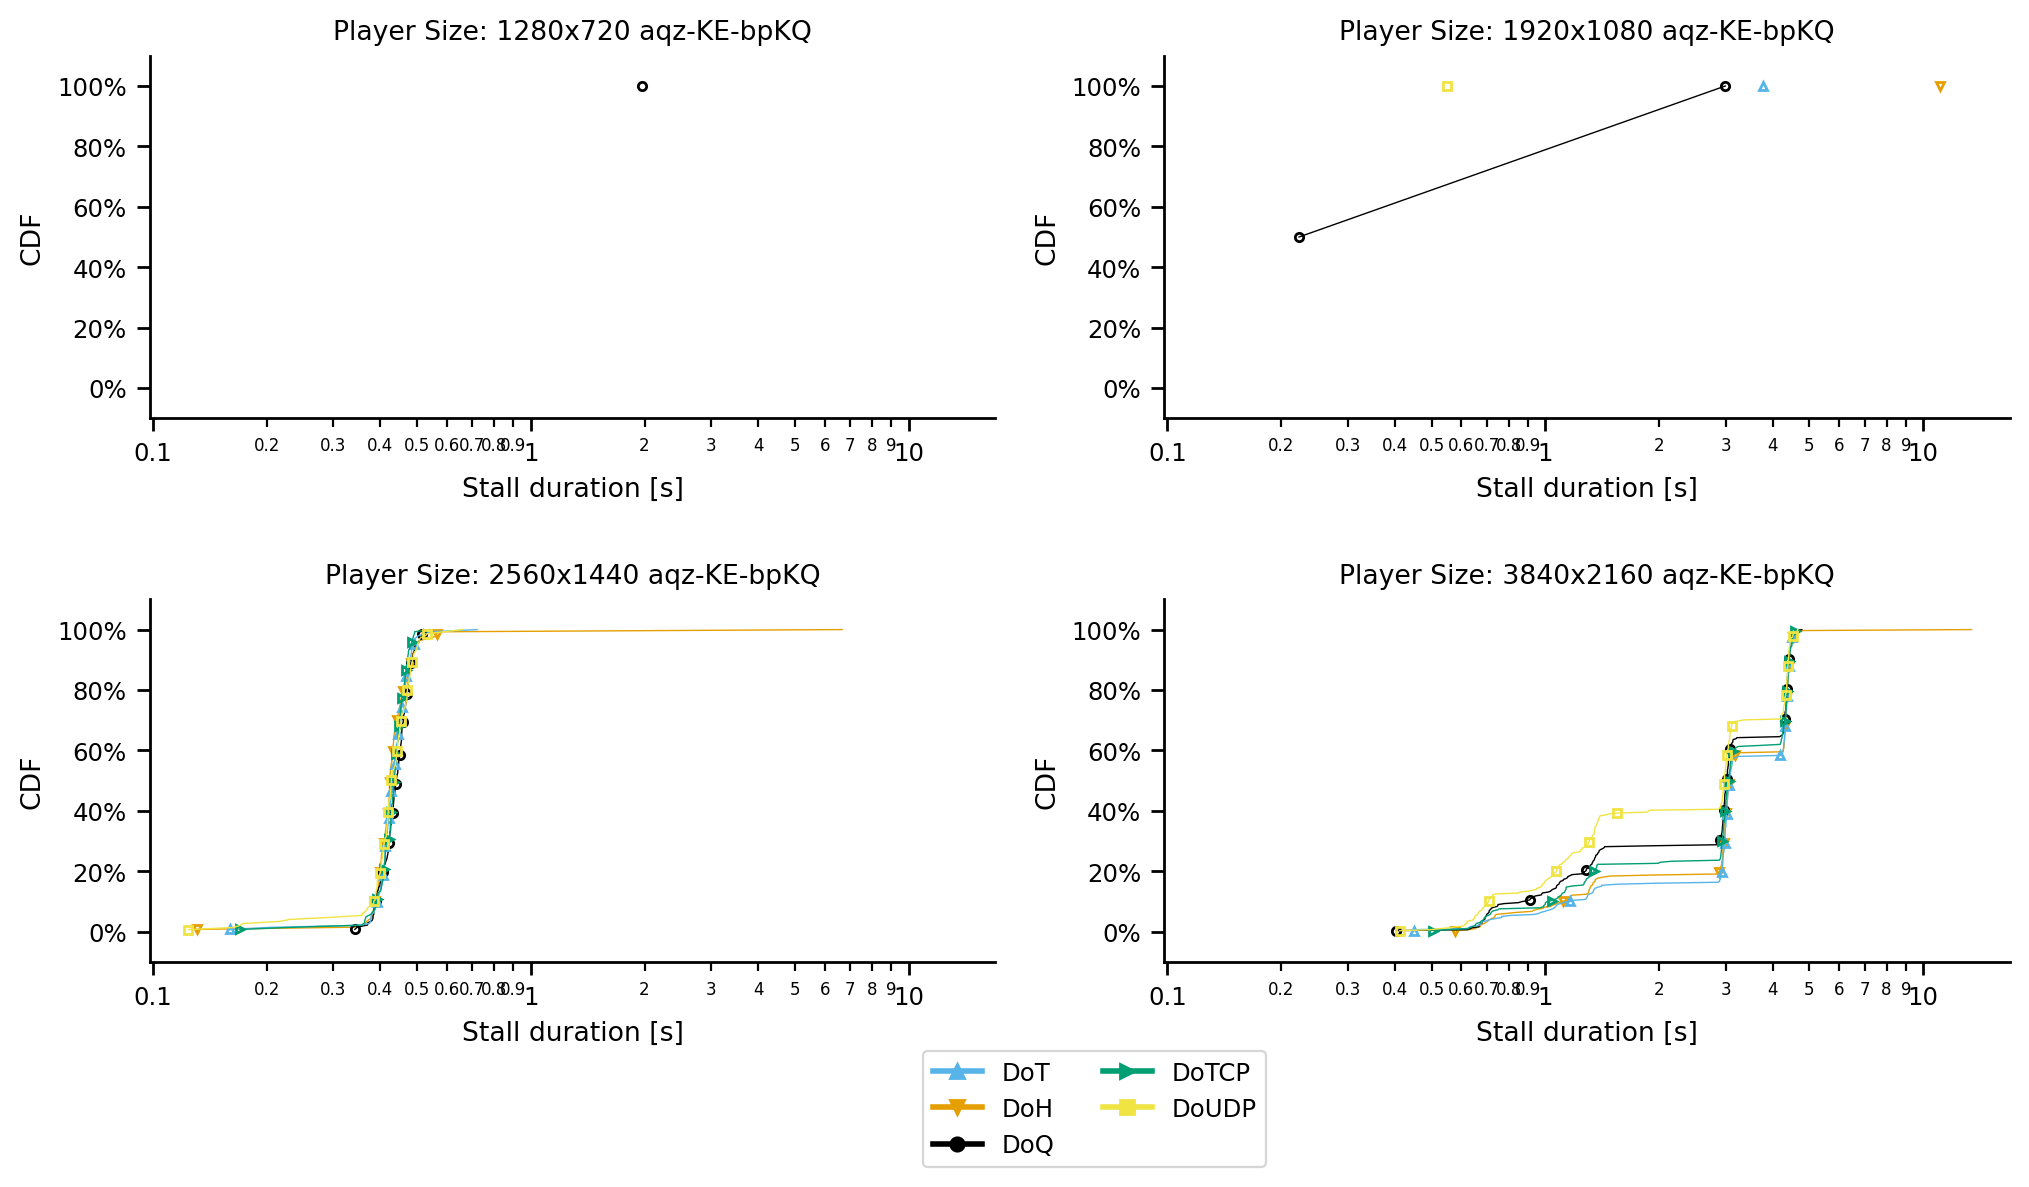

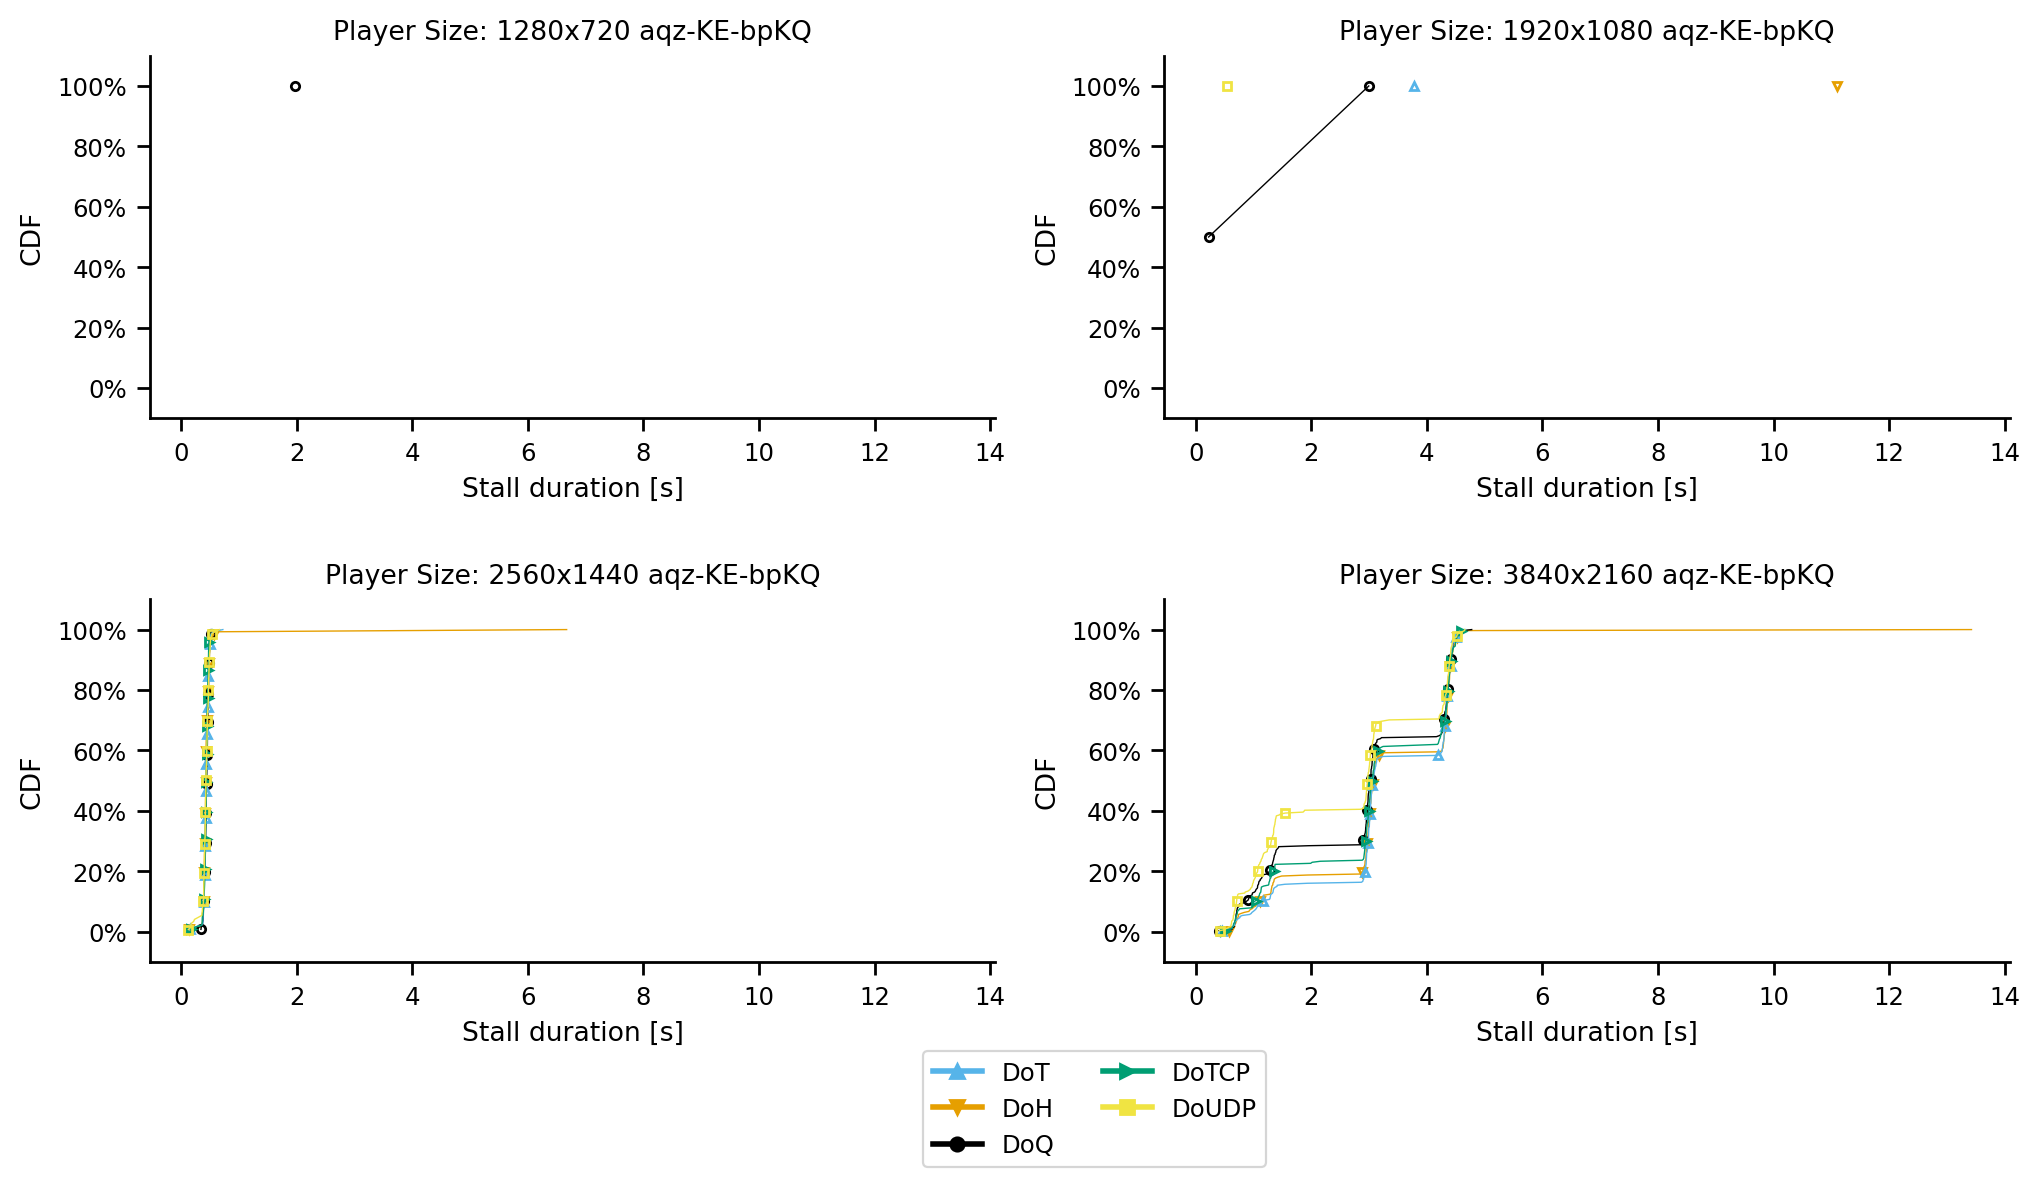

In [112]:
draw_cdf_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

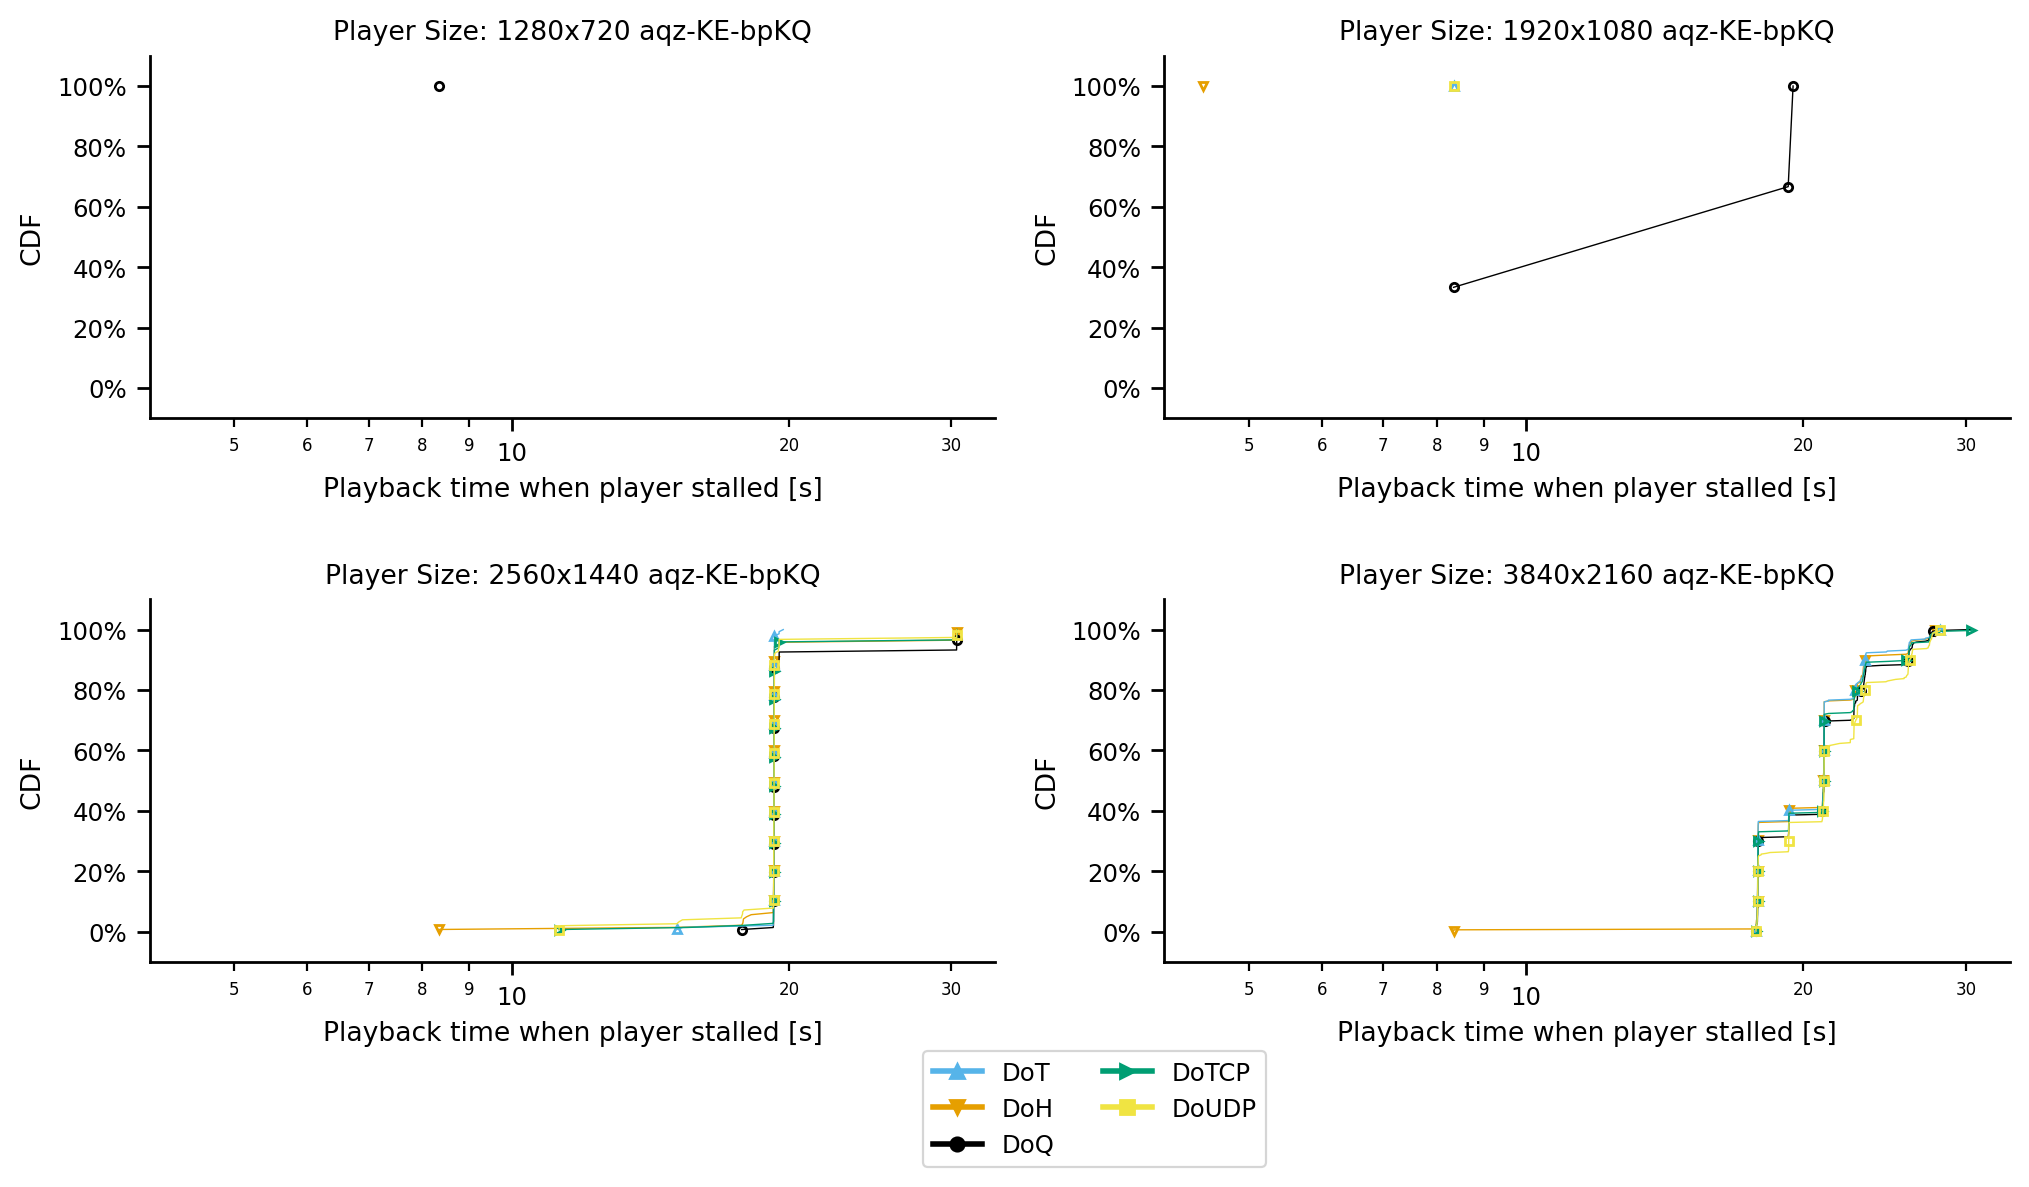

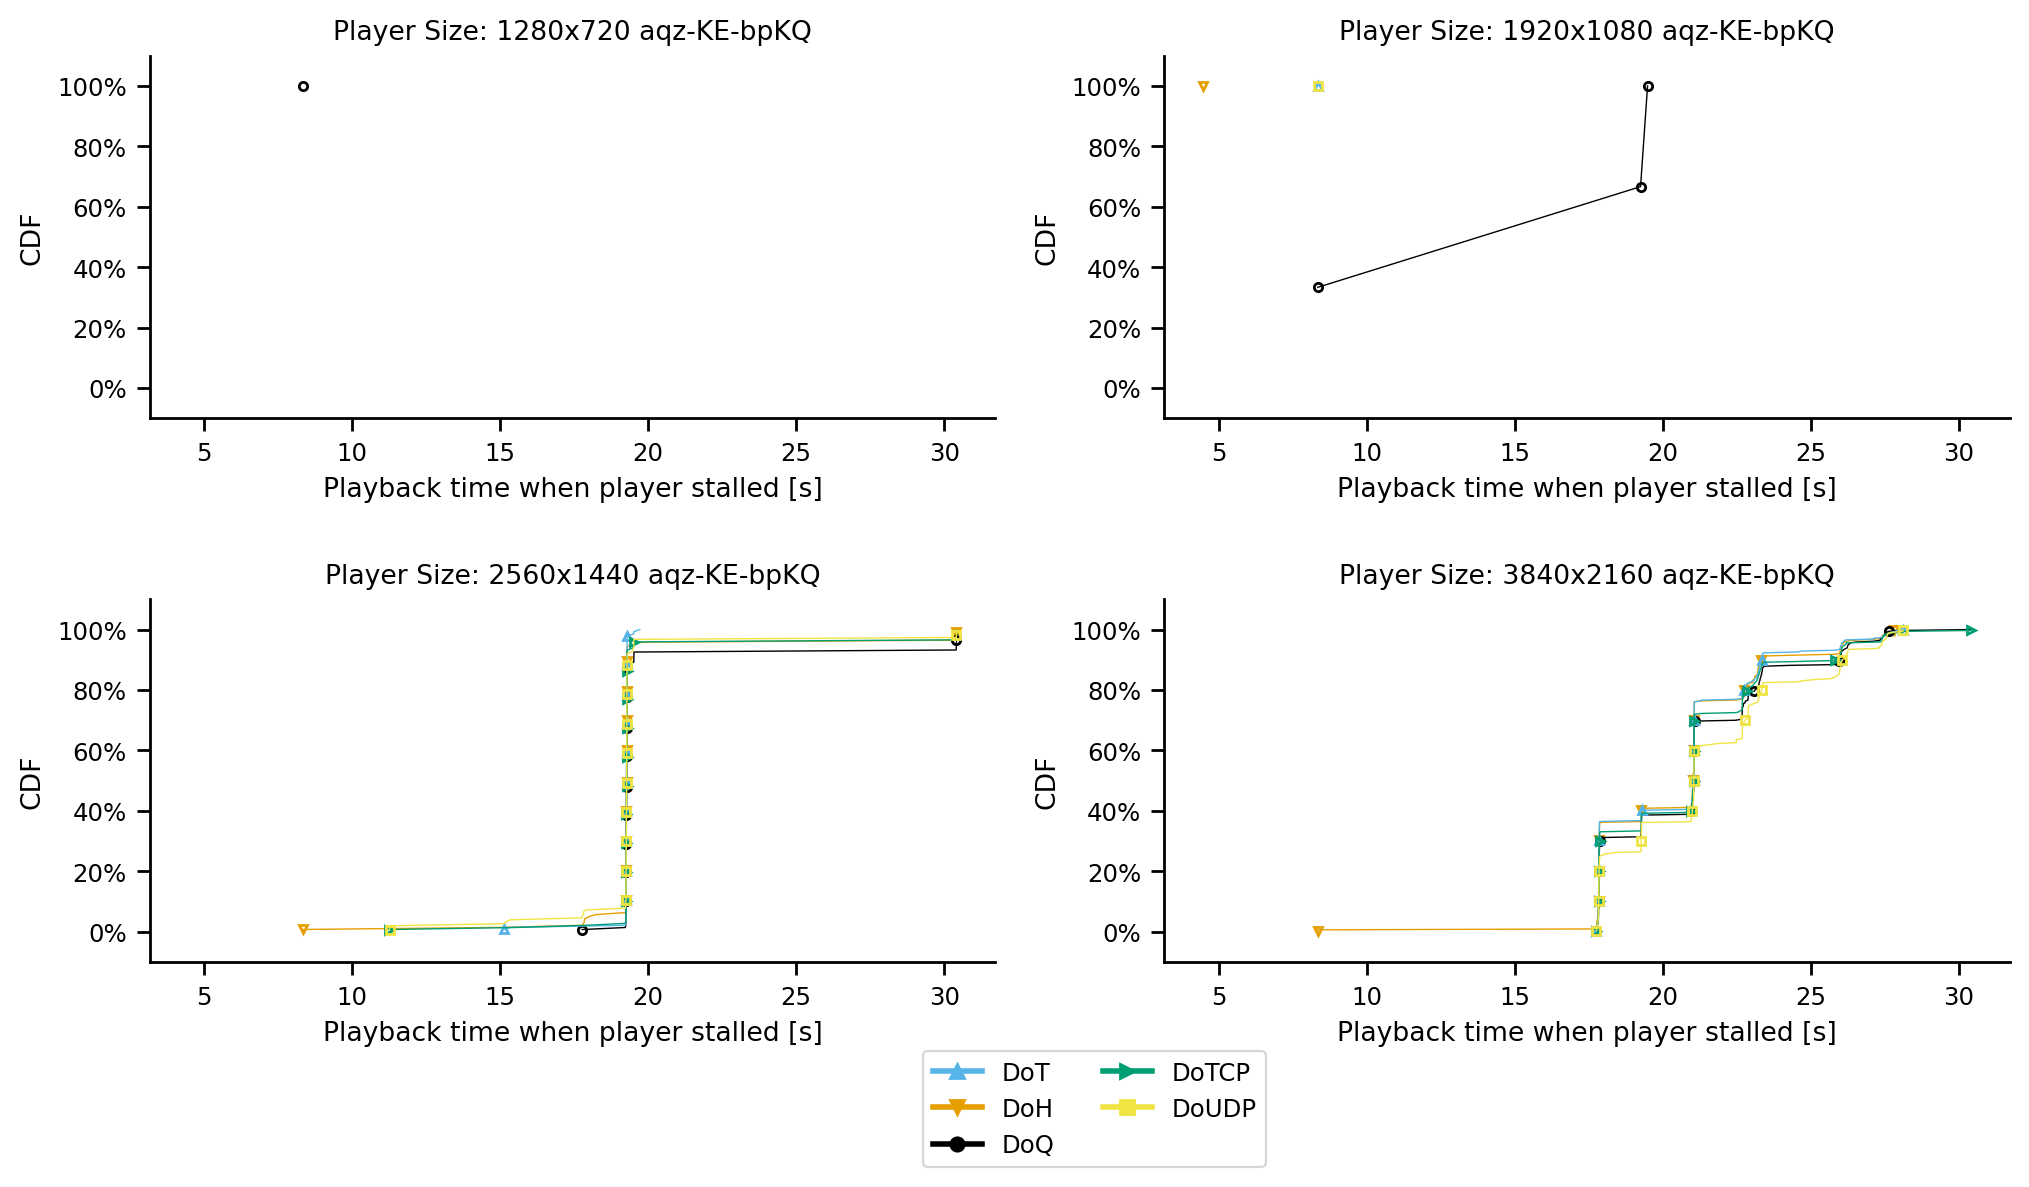

In [113]:
draw_cdf_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

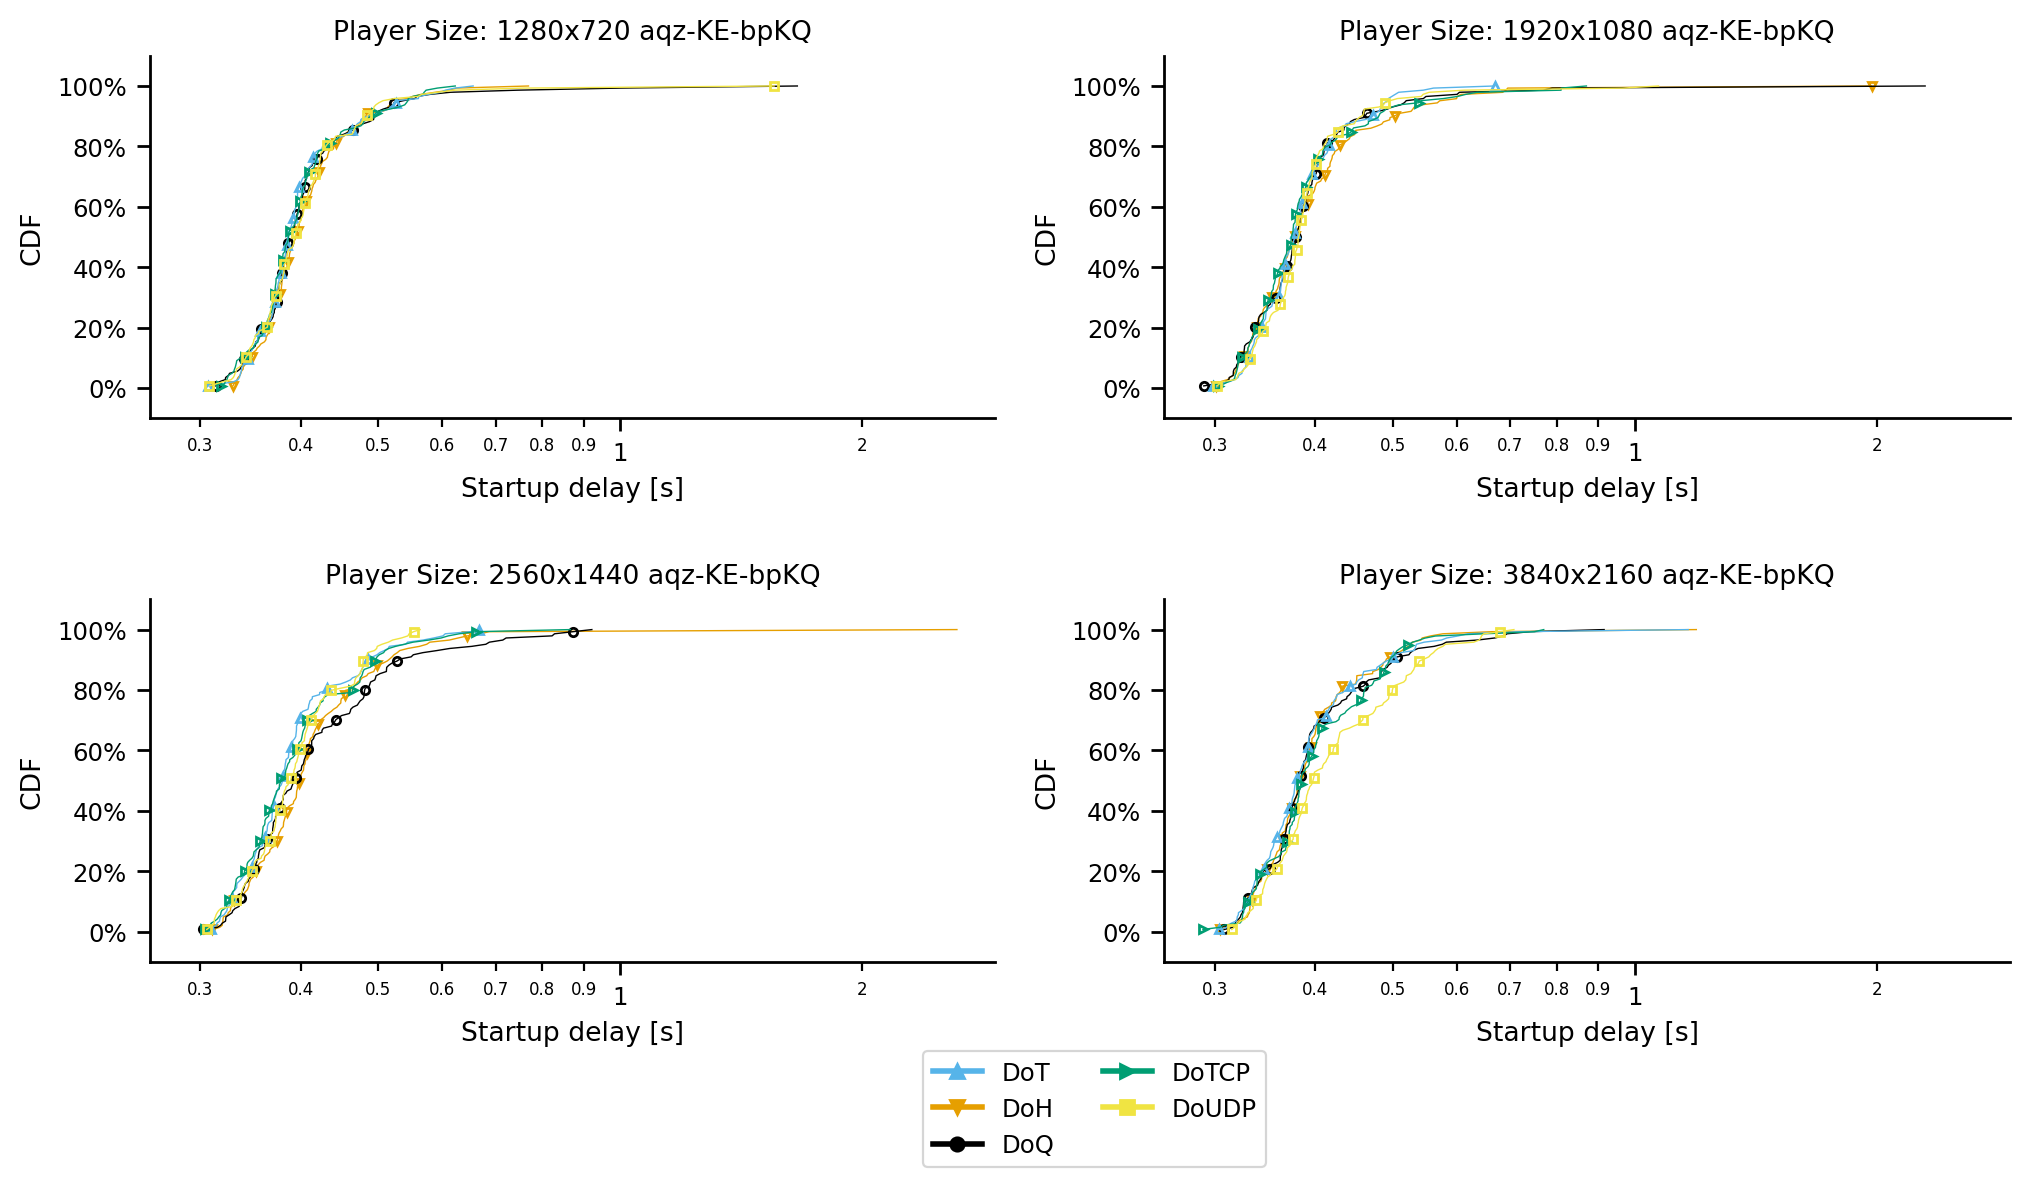

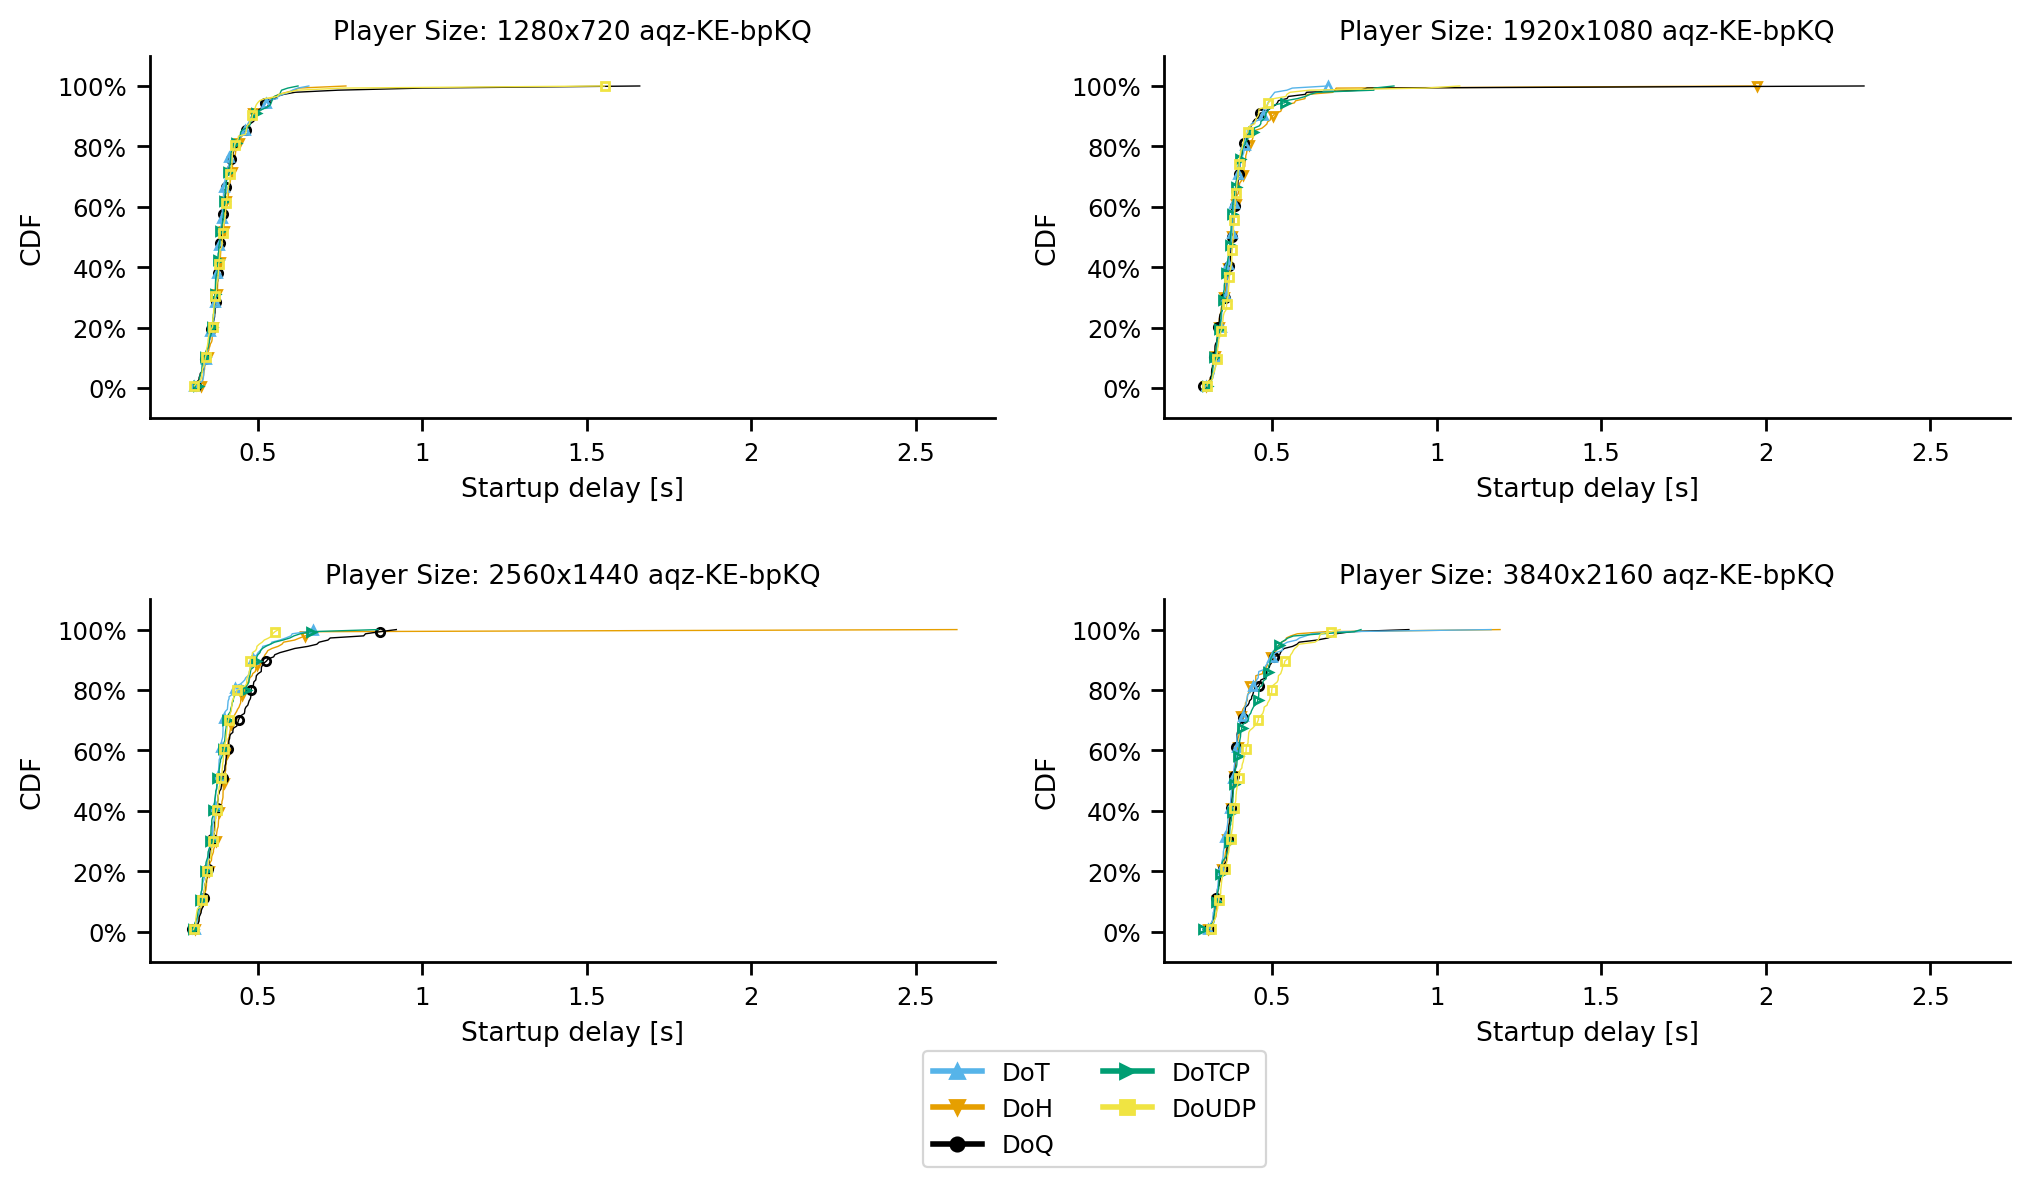

In [114]:
draw_cdf_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.1,1])

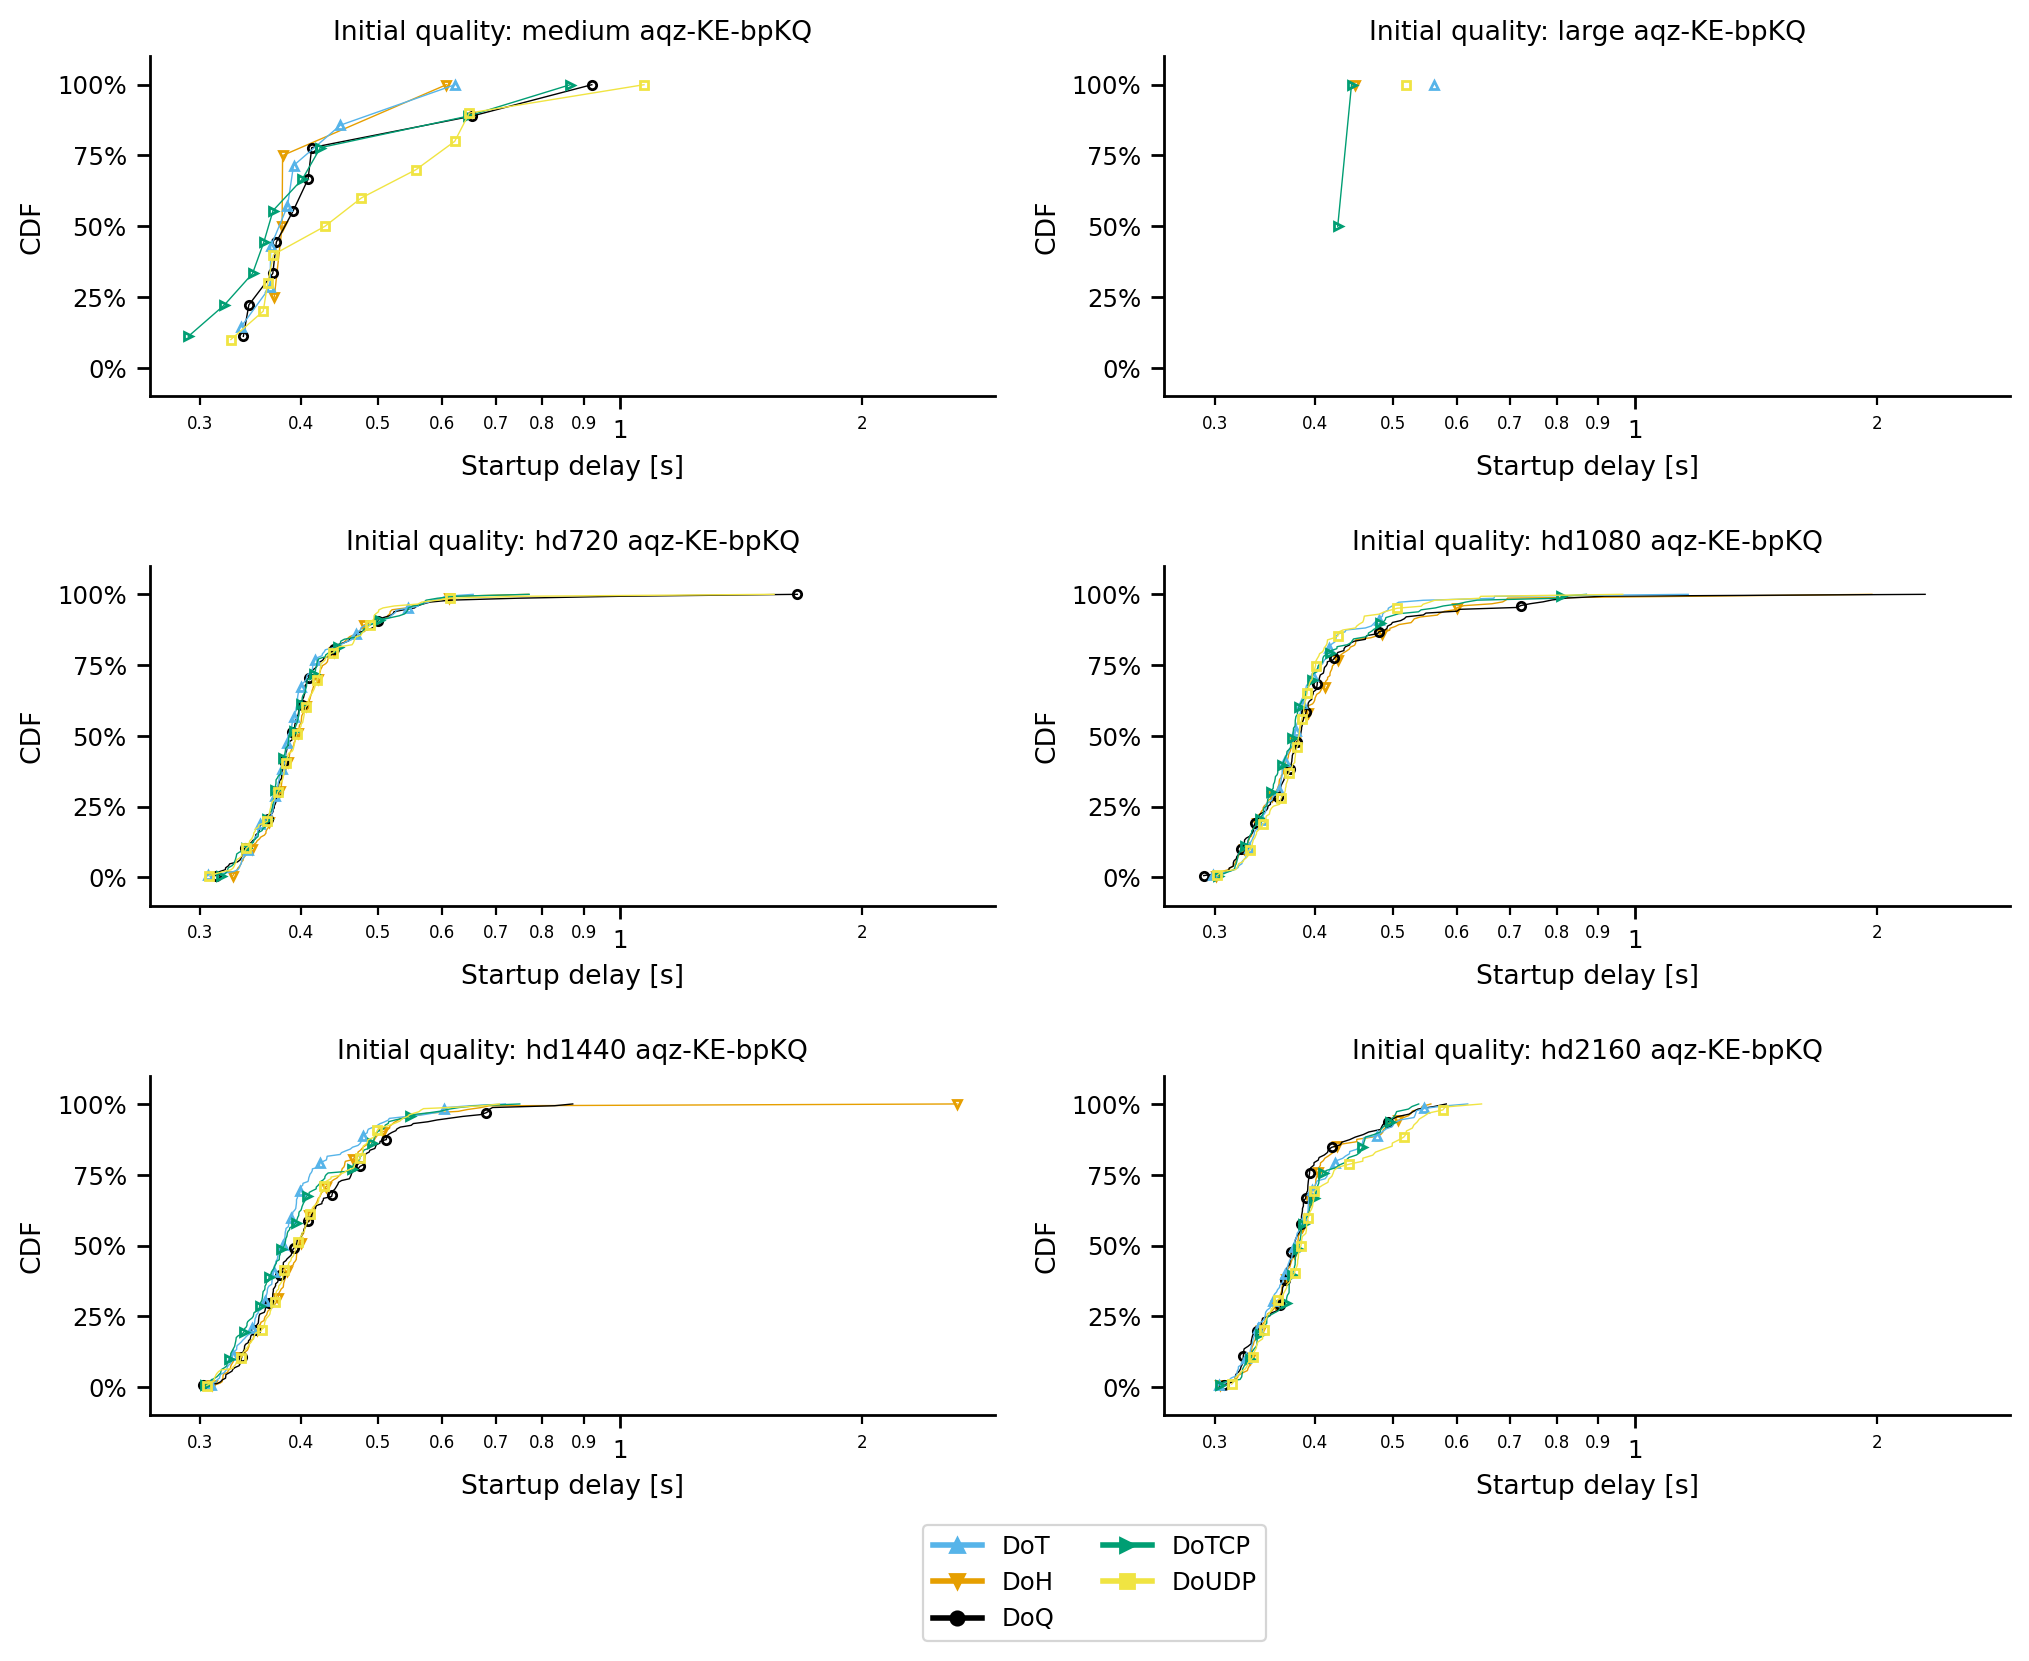

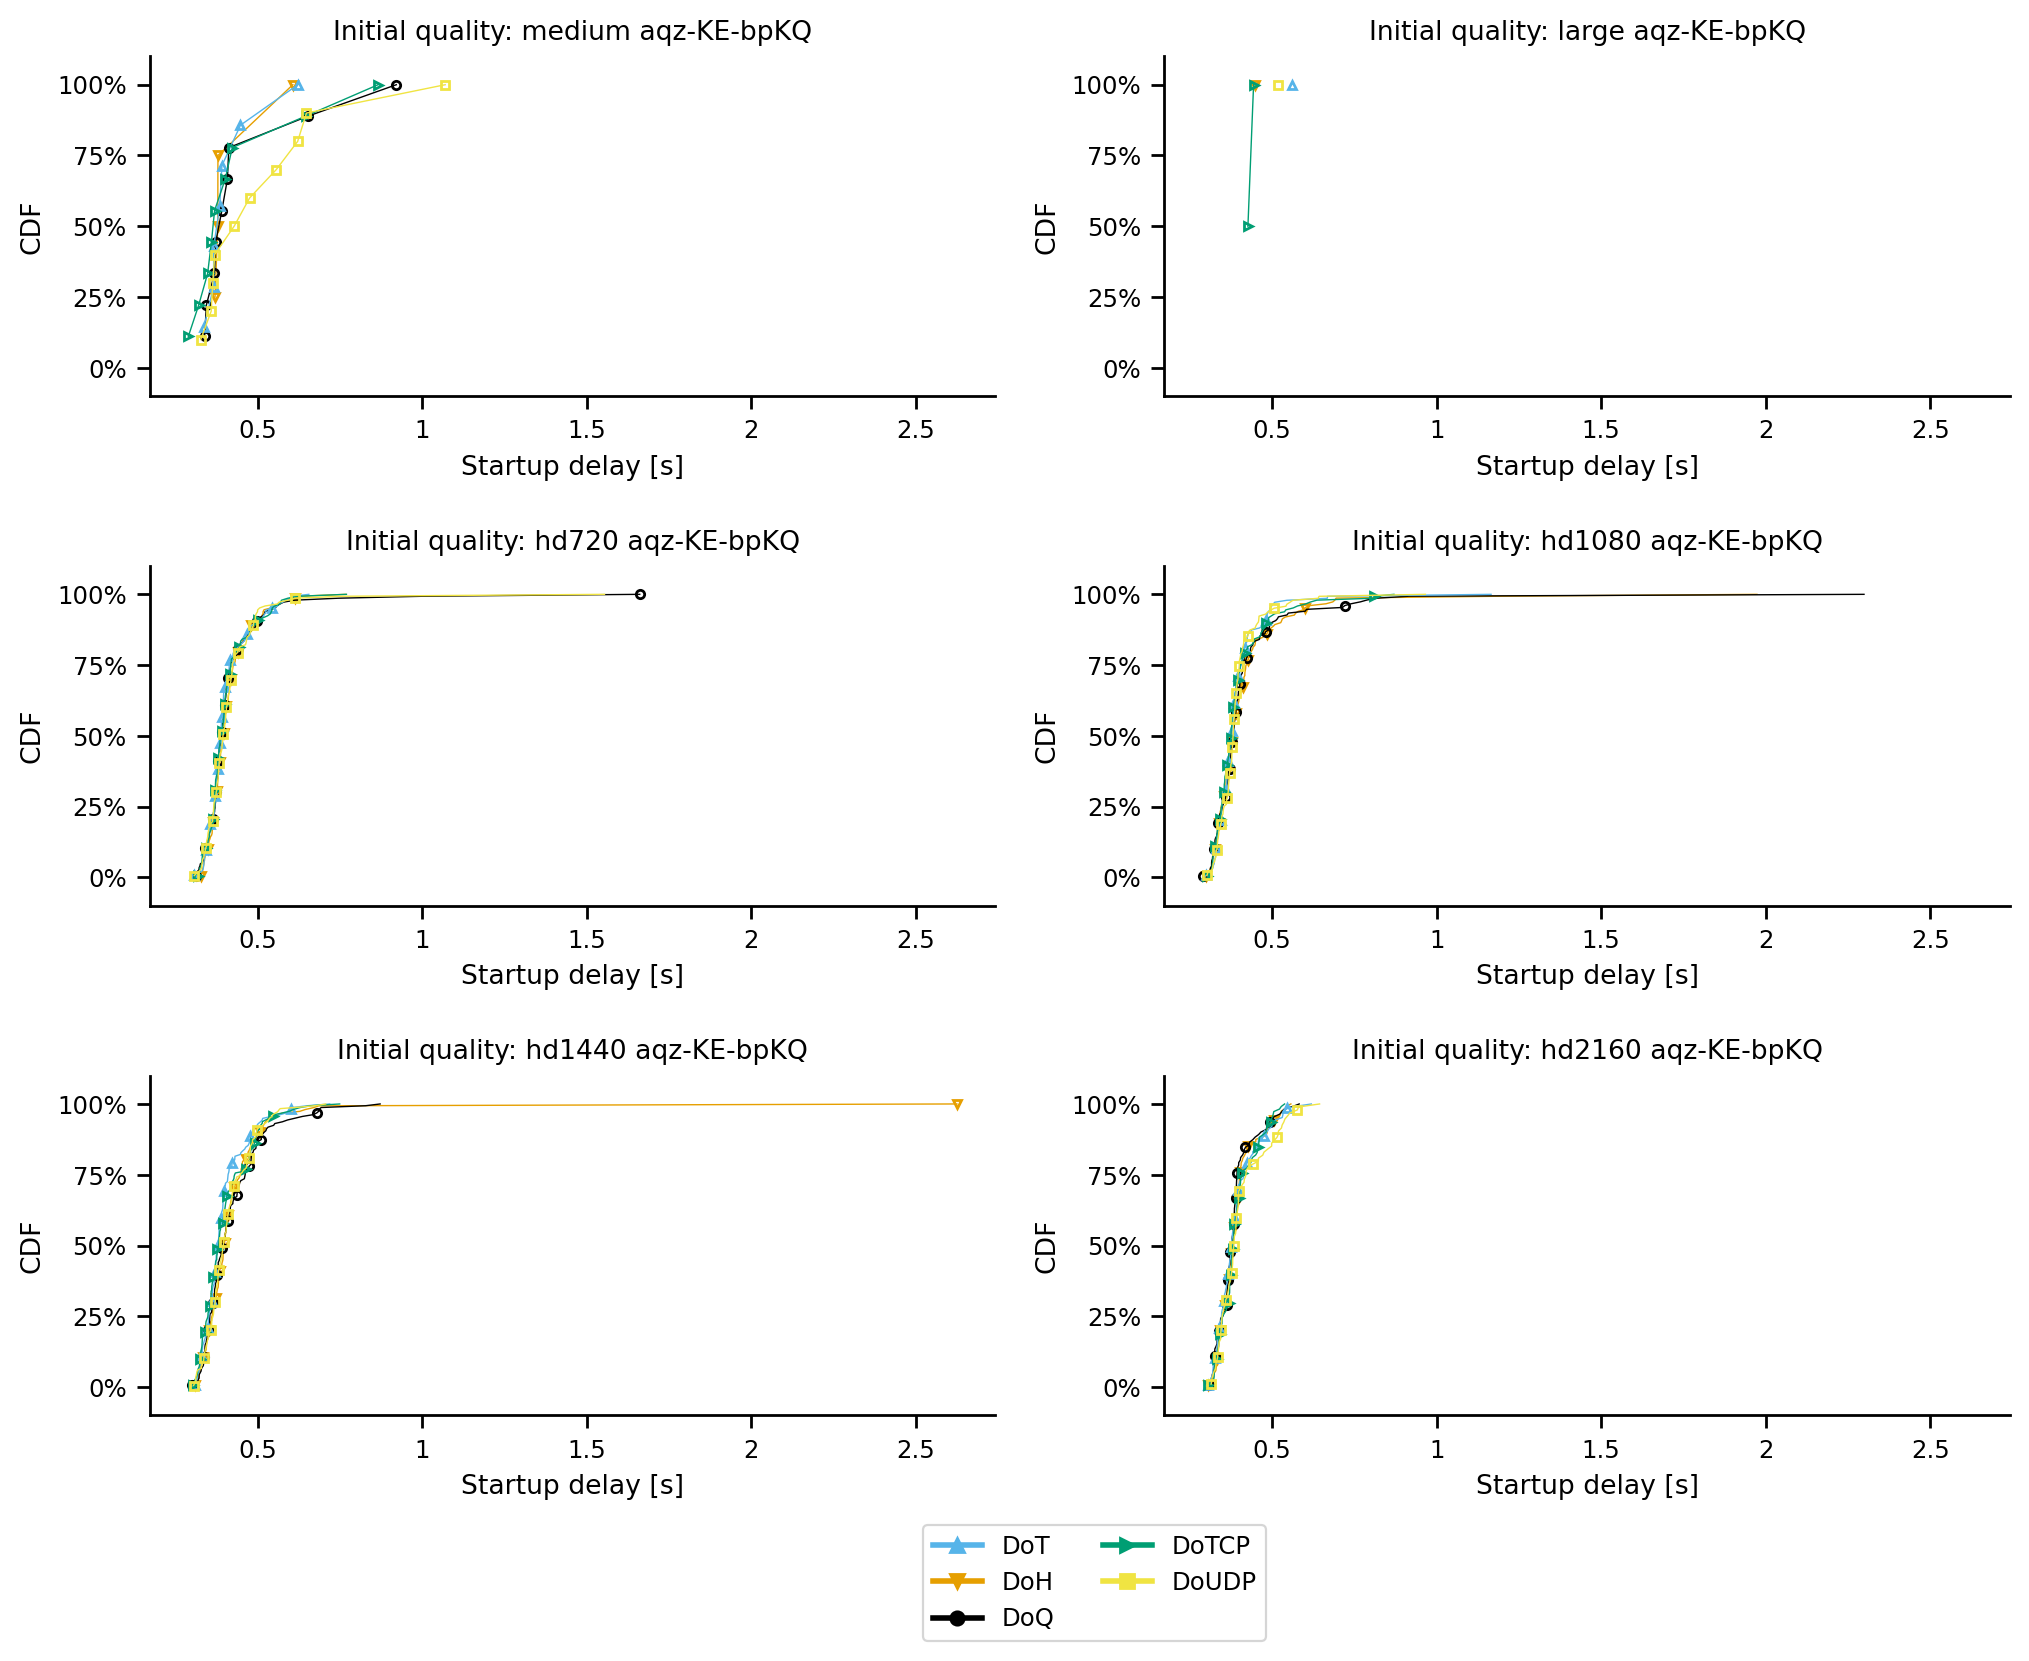

In [115]:
draw_cdf_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0])

In [ ]:
draw_cdf(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0.1,1])

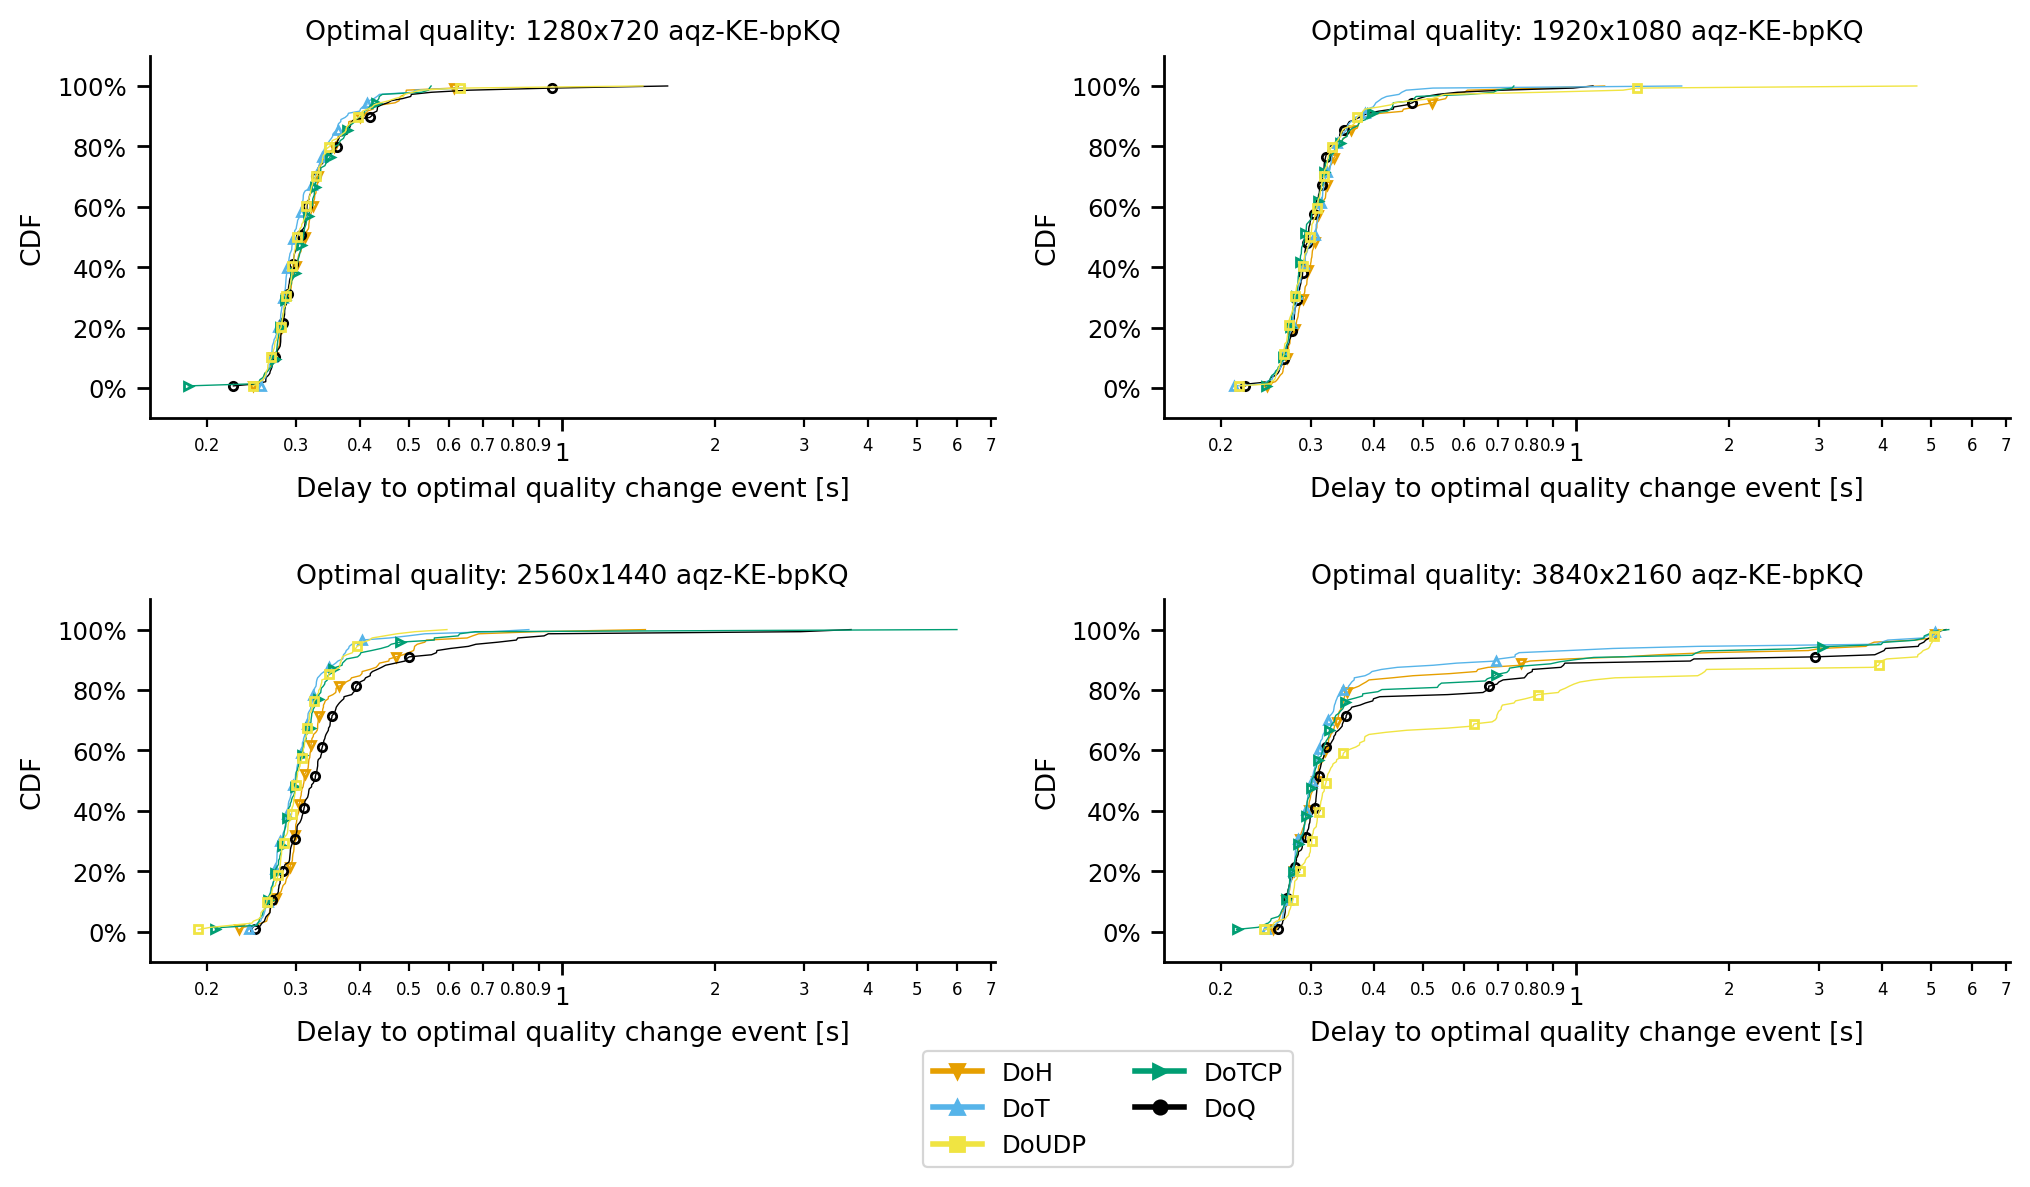

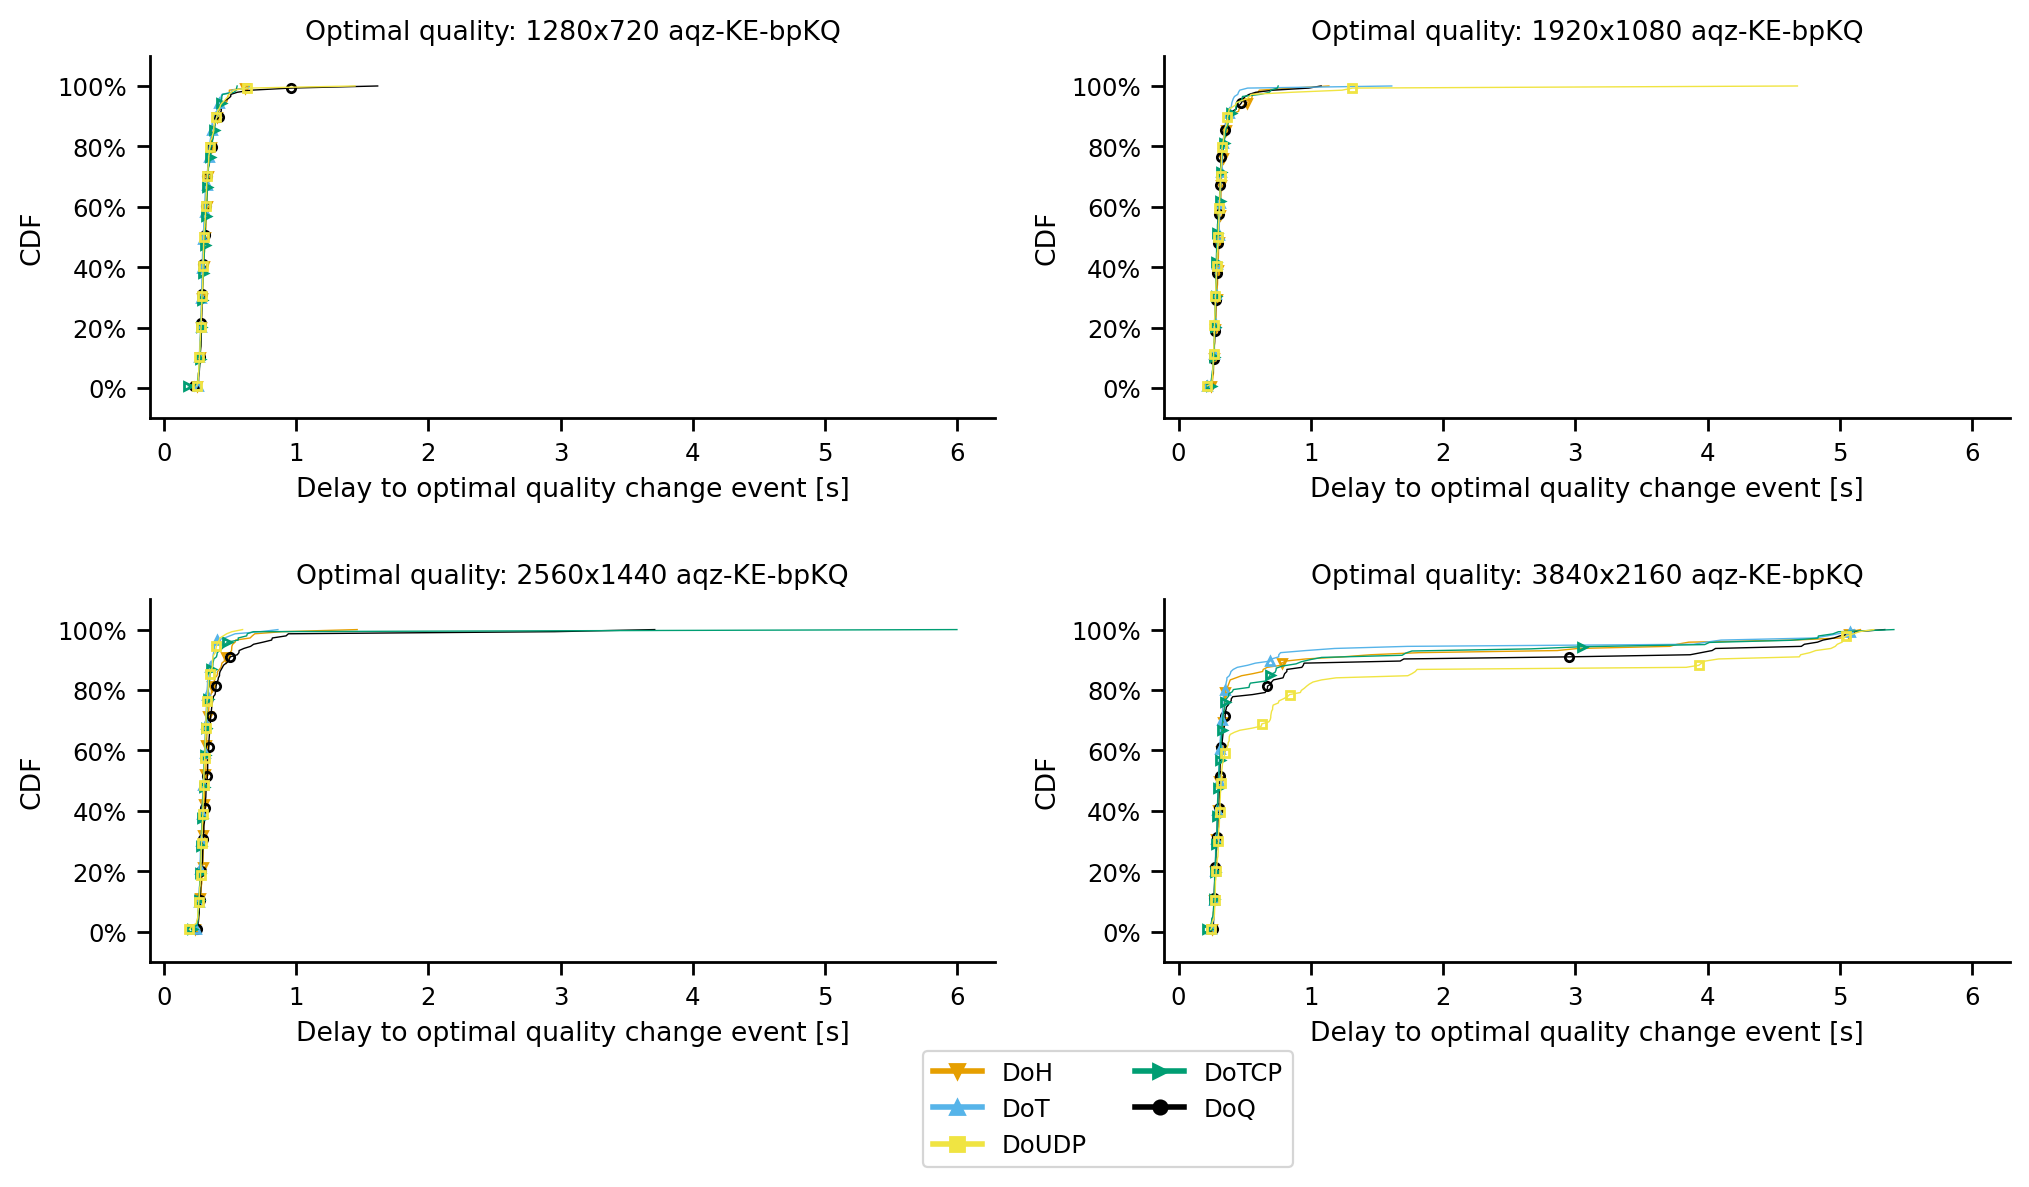

In [116]:
draw_cdf_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [ ]:
draw_cdf(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [117]:
def draw_boxplot_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    proto_order=['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    if col_name_ == 'protocol':
        y_order = proto_order
    else:
        y_order = sorted(df_[col_name_].unique().tolist())
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    num_rows = math.ceil(df_[col_outer_groupby_].nunique()/2)
                    if df_[col_outer_groupby_].nunique() > 1:
                        fig, axs = plt.subplots(num_rows, 2, sharex='all', figsize=(12,6*num_rows))#, sharey='all')
                        fig.subplots_adjust(hspace=.2, wspace=.3)
                        for col_grp_, ax in zip(df_[col_outer_groupby_].sort_values().unique(), axs.flat):
                        #for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                            lnwidth = .5
                            mrksize = 3
                            df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                            #hue=
                            
                            boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                            showfliers=True, order=y_order,
                            color='white',
                            meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                            sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5, order=y_order)
                            
                            if log:
                                ax.set_xscale('log')
                            
                            
                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel(ylabel)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)

                            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                            ax.grid(b=True, which='both')


                        if log:
                            fig.savefig('figures/boxplot-'+figname+'-grid-'+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        else:
                            fig.savefig('figures/boxplot-'+figname+'-grid-'+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

In [118]:
def draw_boxplot(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    proto_order=['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    if col_name_ == 'protocol':
        y_order = proto_order
    else:
        y_order = sorted(df_[col_name_].unique().tolist())
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        fig, ax = plt.subplots(figsize=(6,8))
                        #hue=
                        boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                        showfliers=True, order=y_order,
                        color='white',
                        meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                        sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5, order=y_order)
                        
                        if log:
                            ax.set_xscale('log')
                        
                        
                        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                        ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                        ax.set_xlabel(xlabel)

                        ax.set_ylabel(ylabel)
                        if xlim != [0,0]:
                            ax.set_xlim(xlim)

                        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                        ax.grid(b=True, which='both')


                        if log:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        else:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 28.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

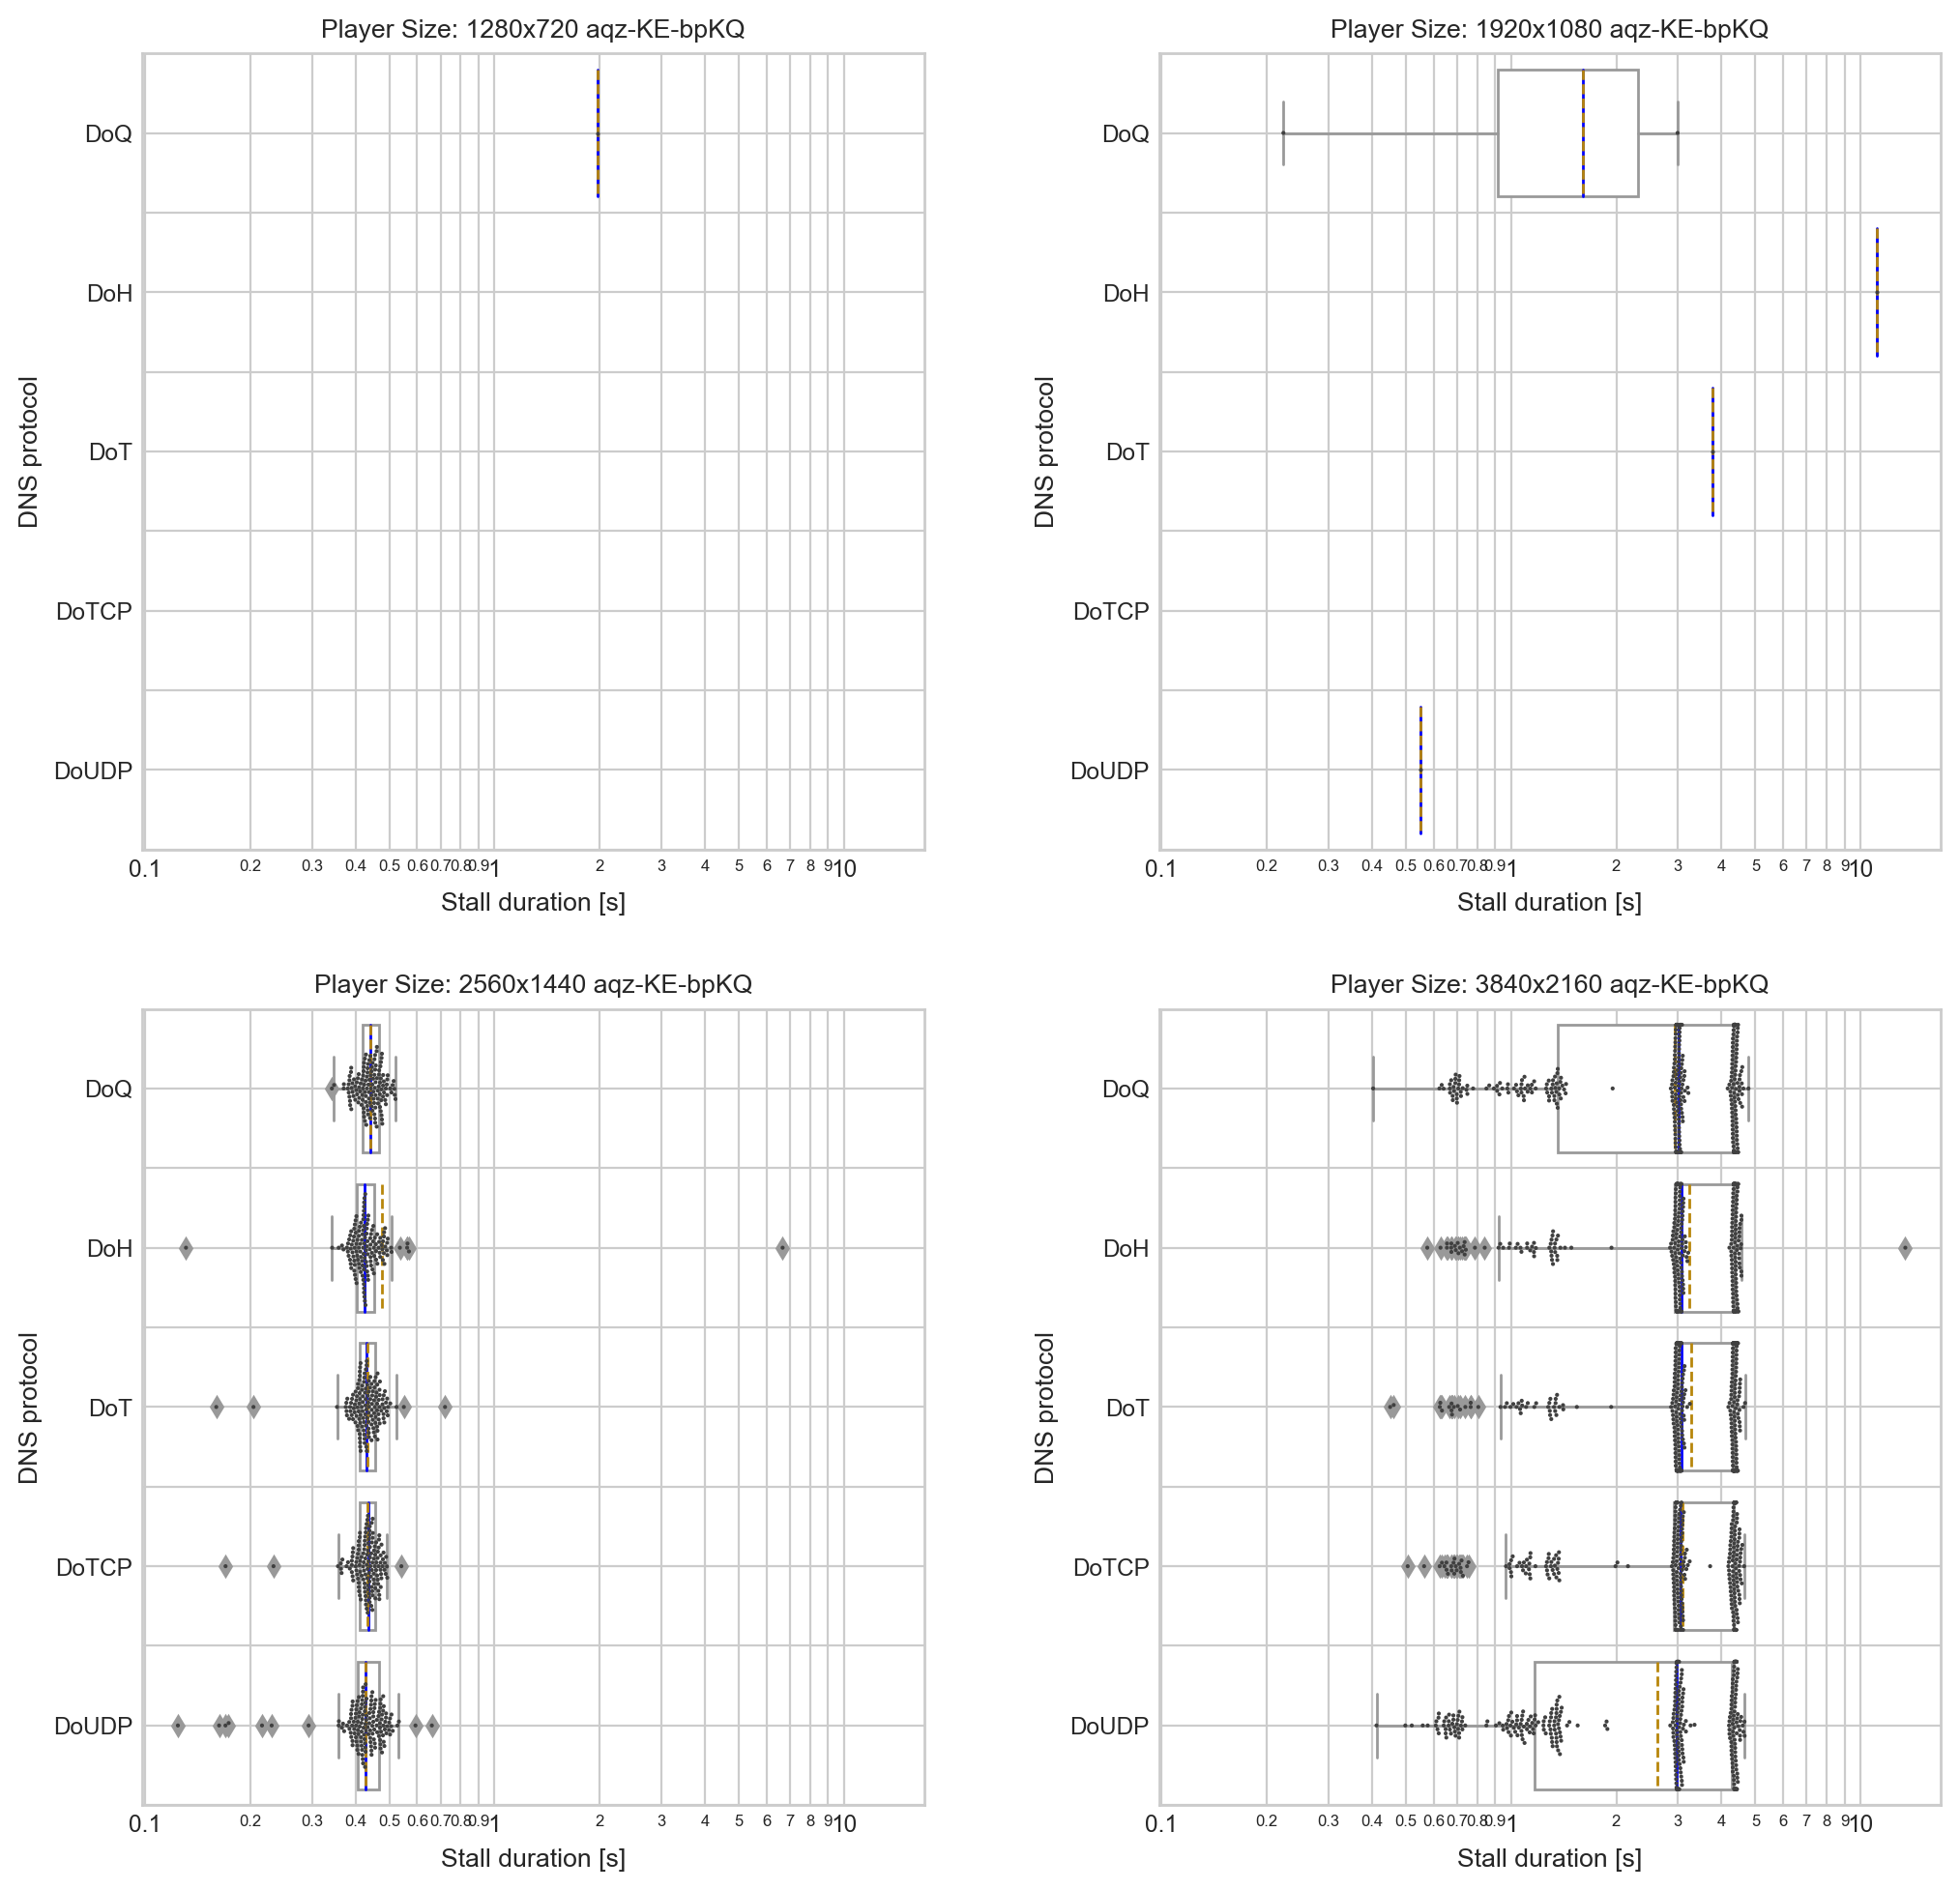

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

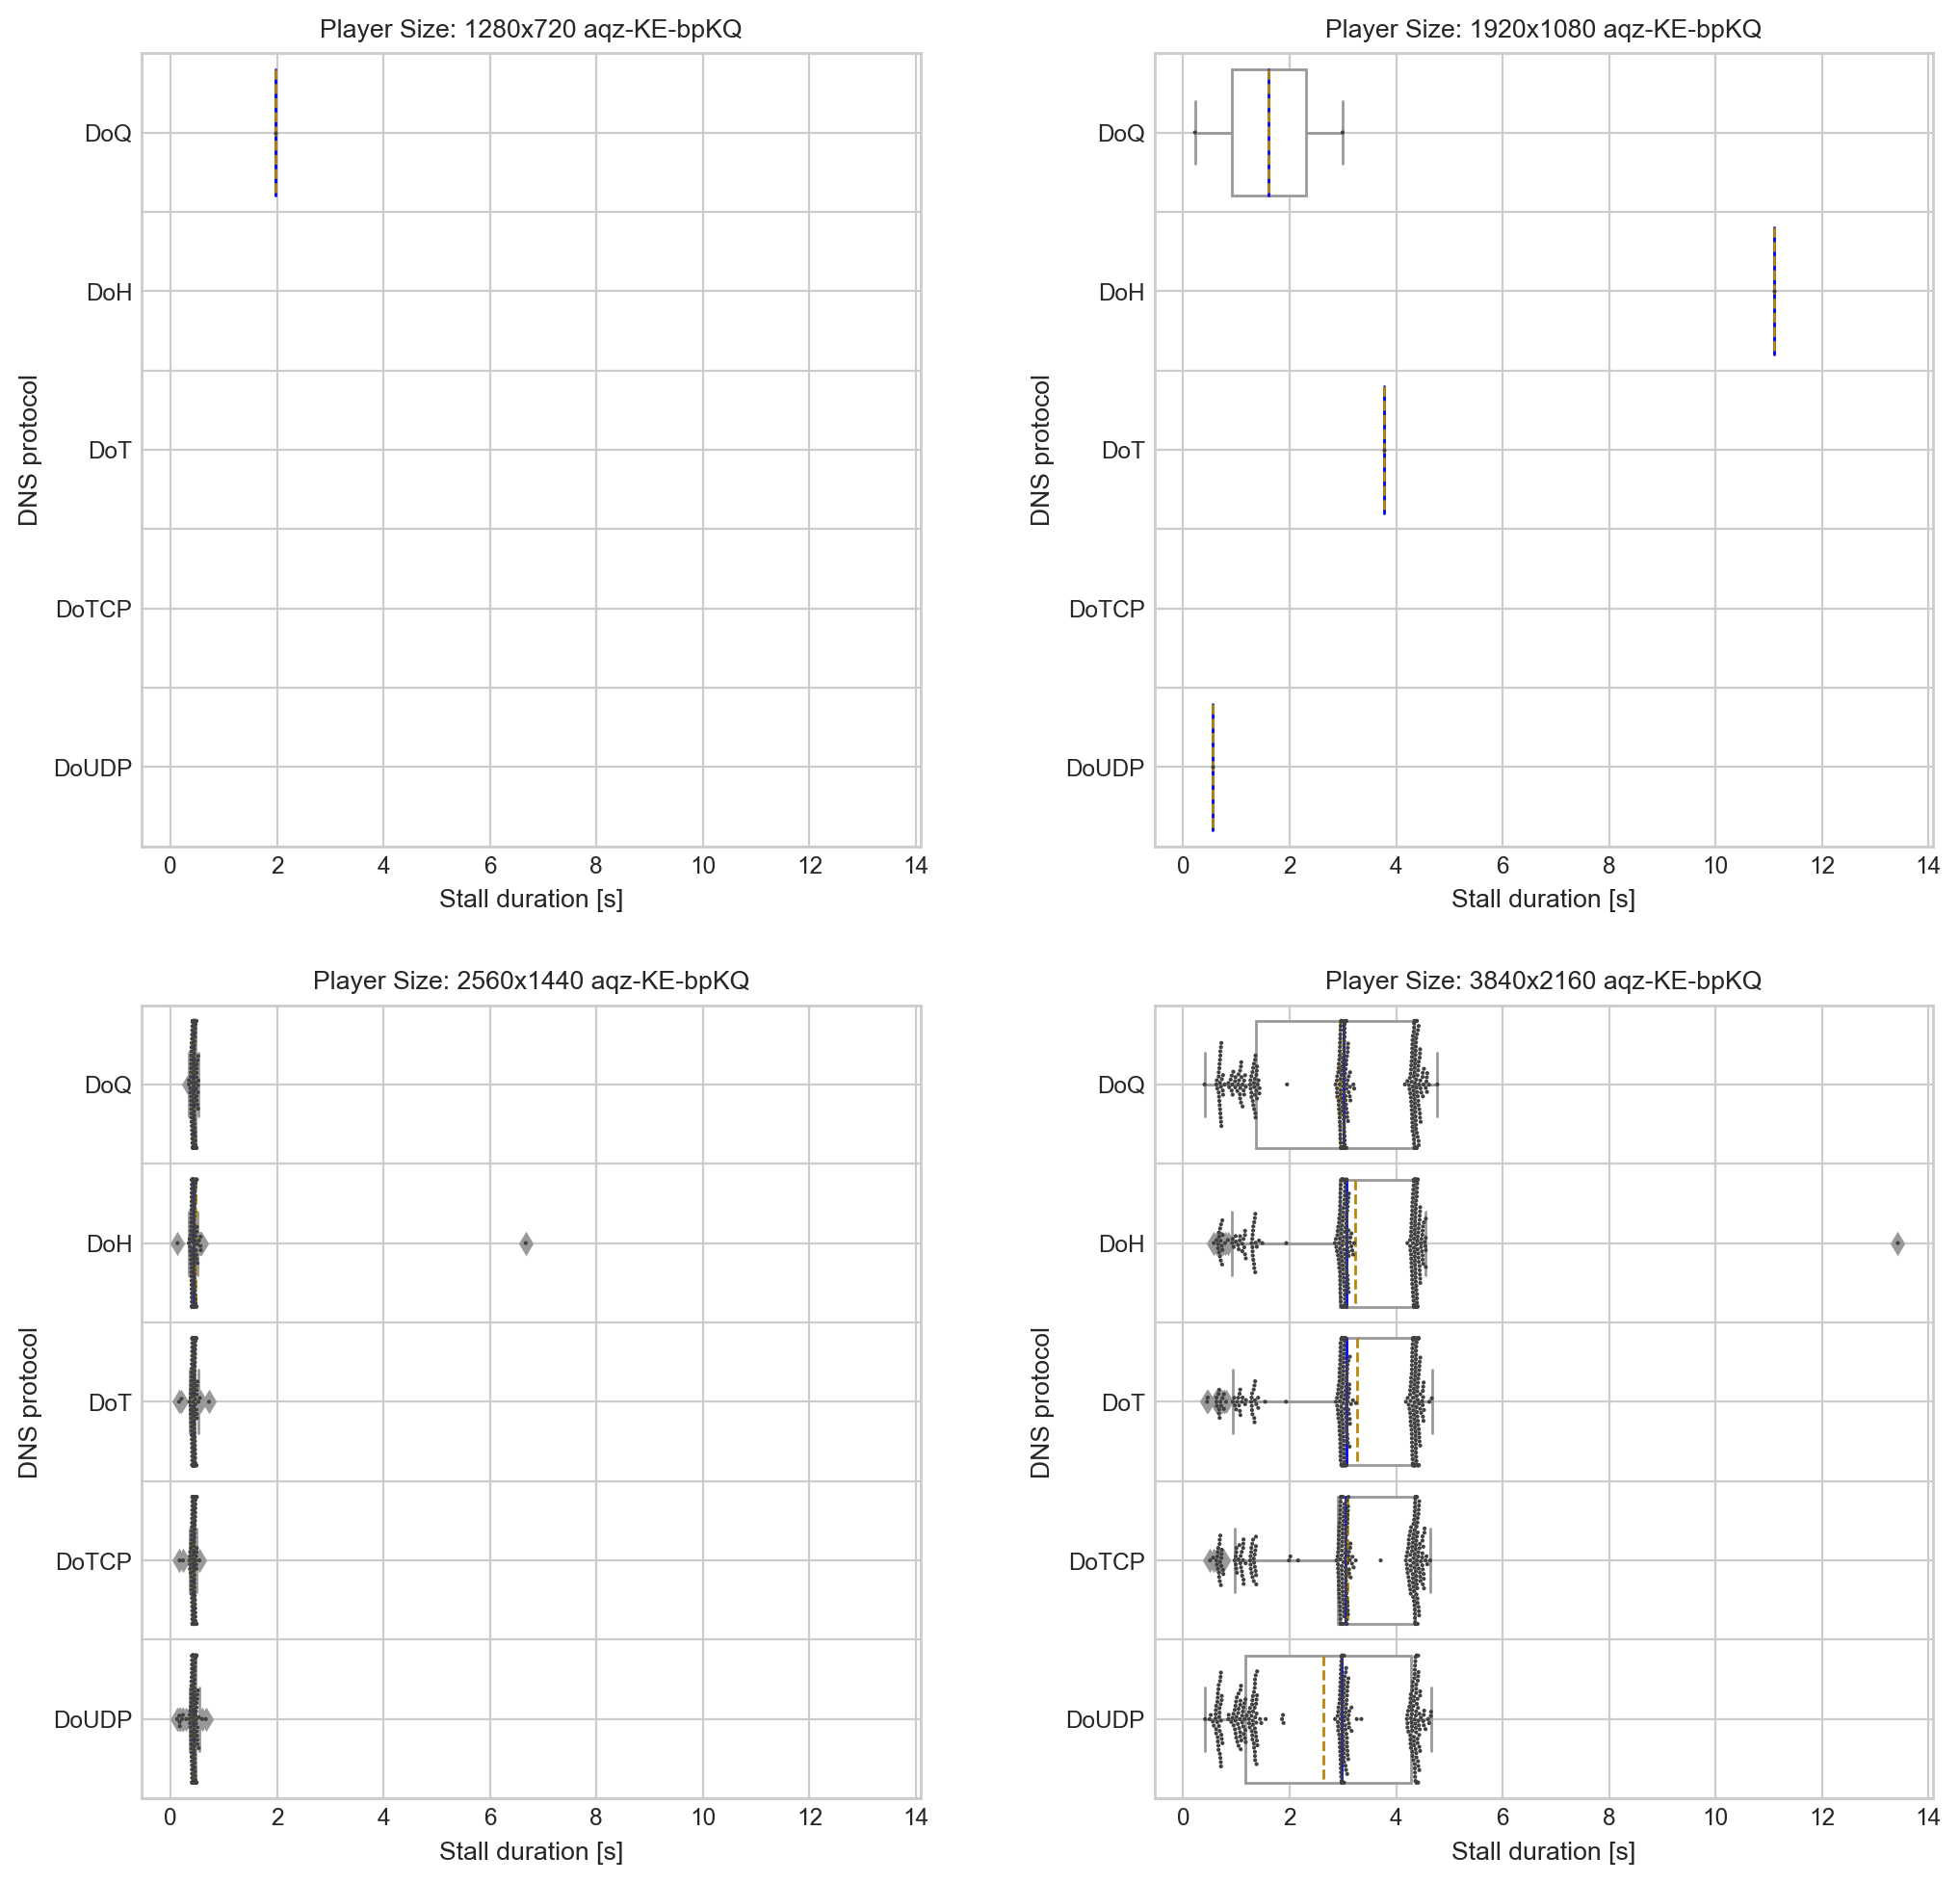

In [119]:
draw_boxplot_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 67.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

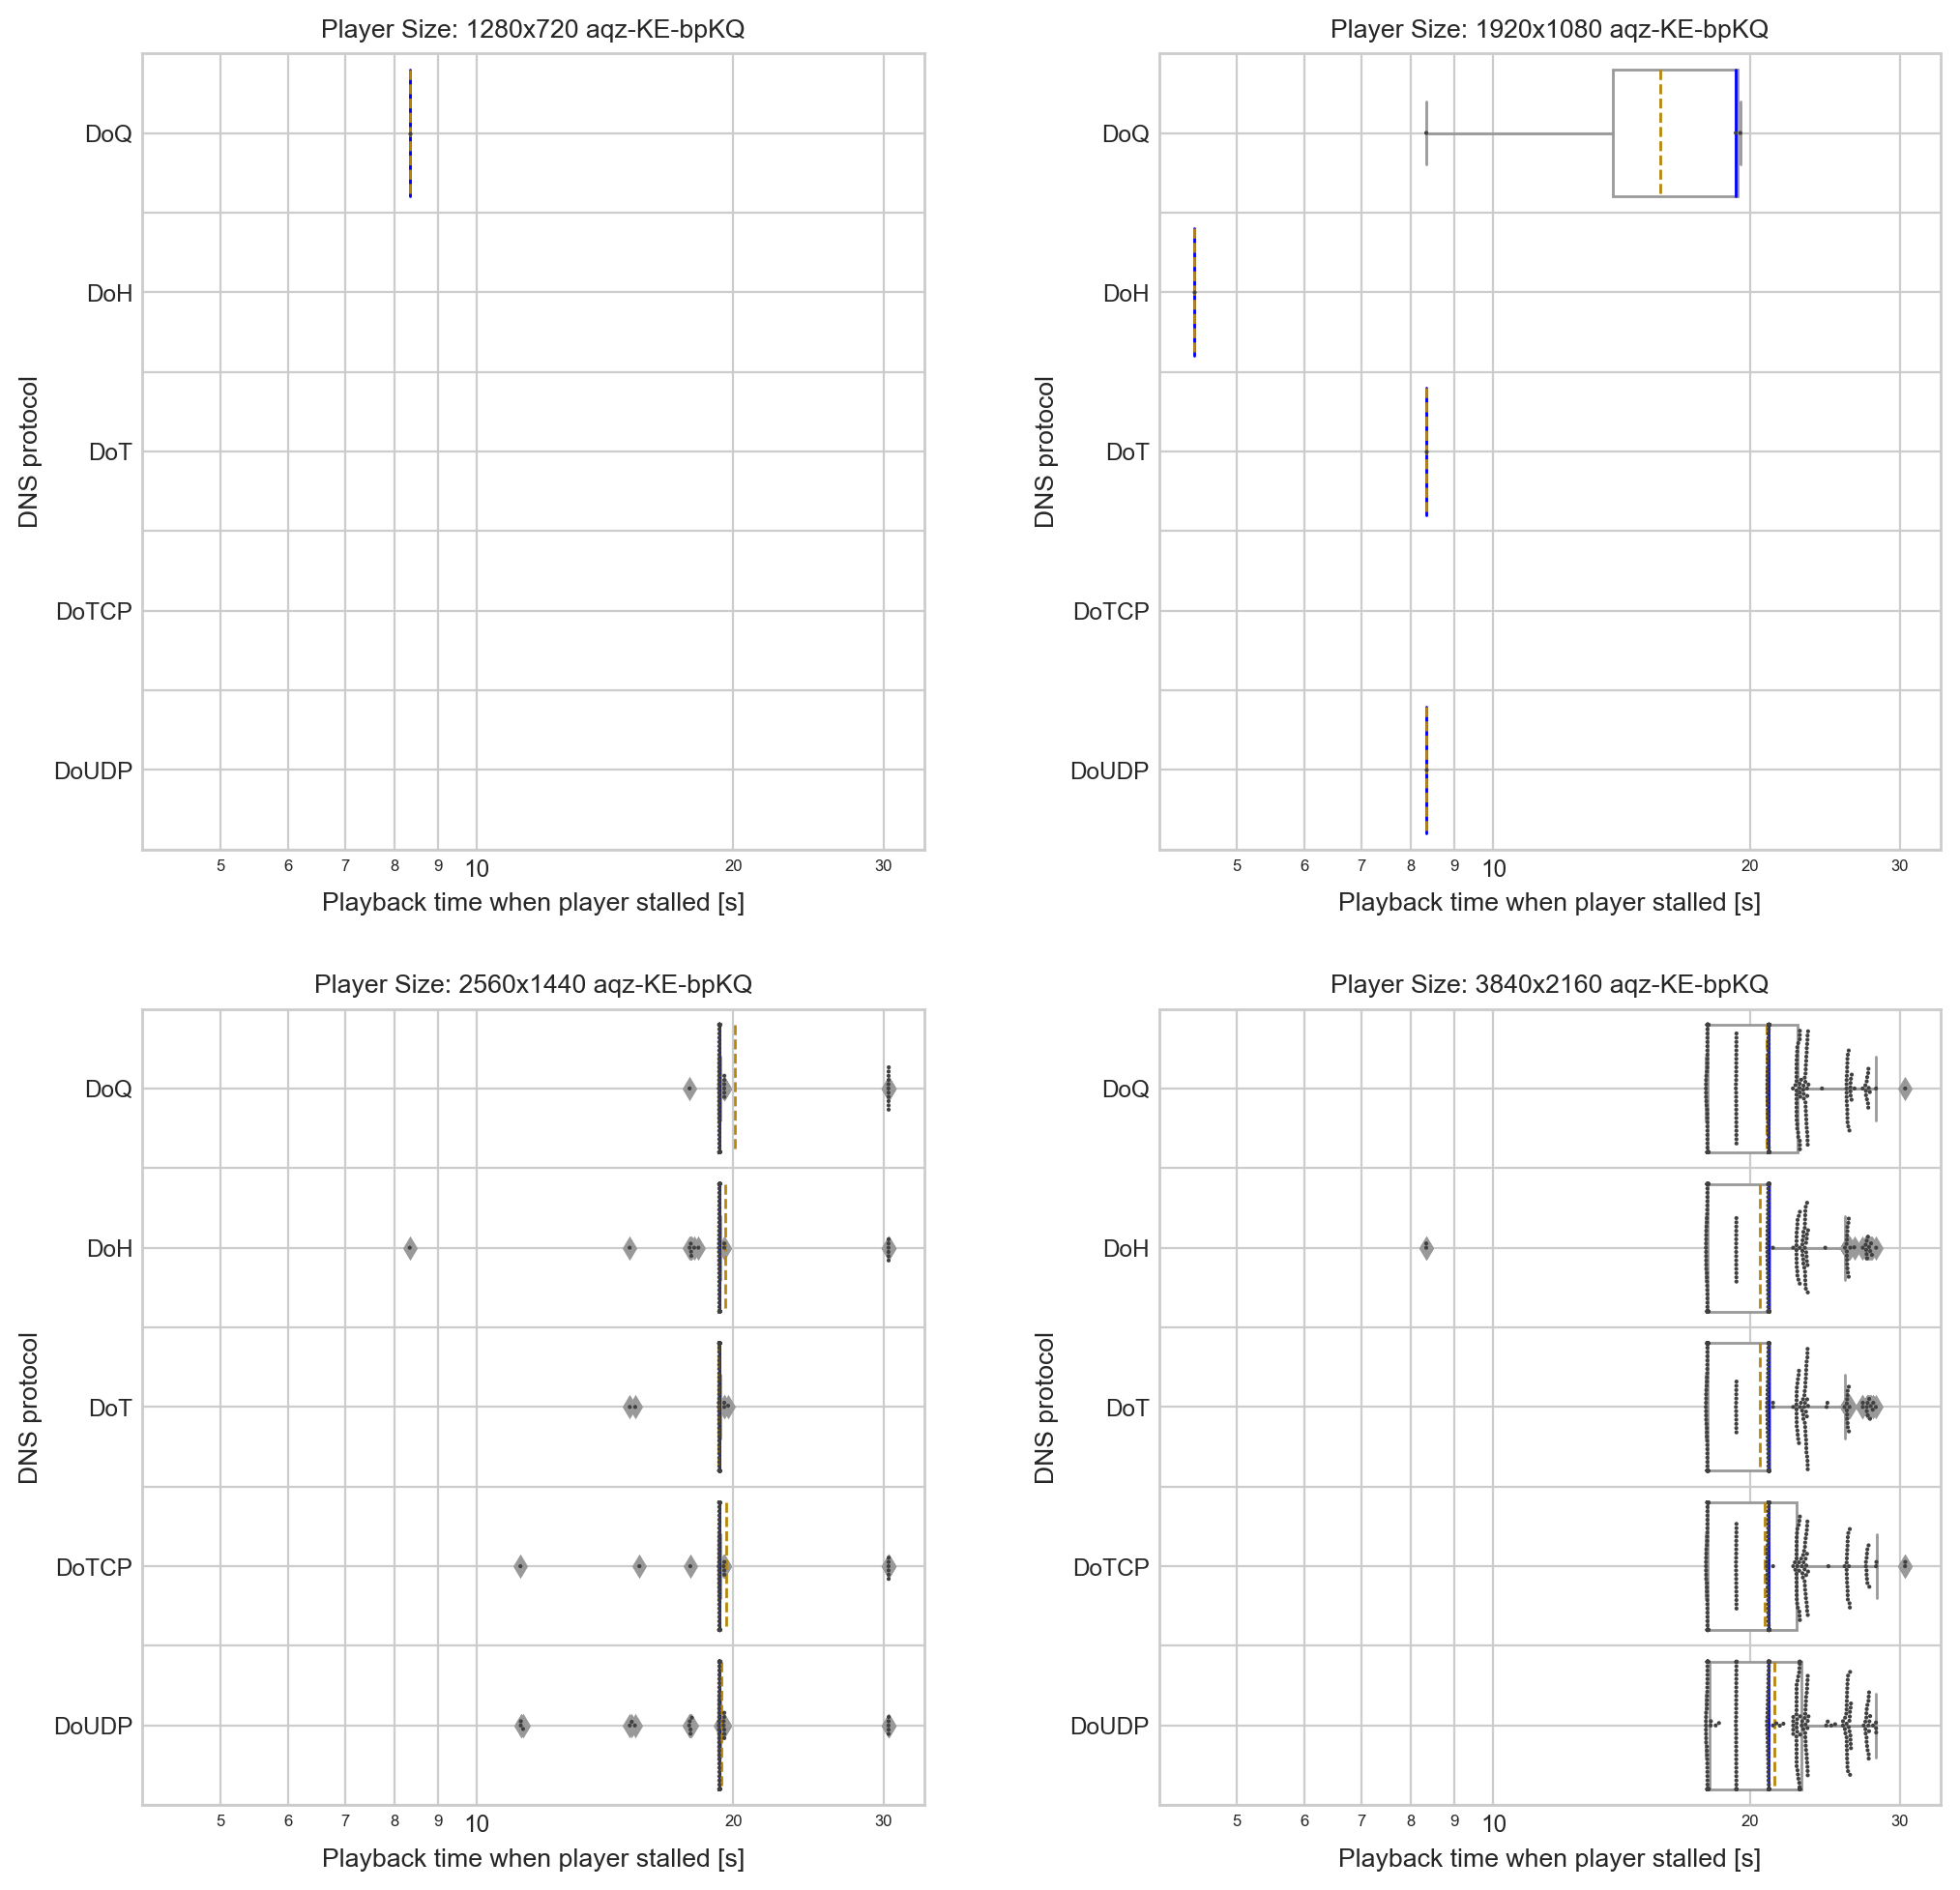

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 67.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

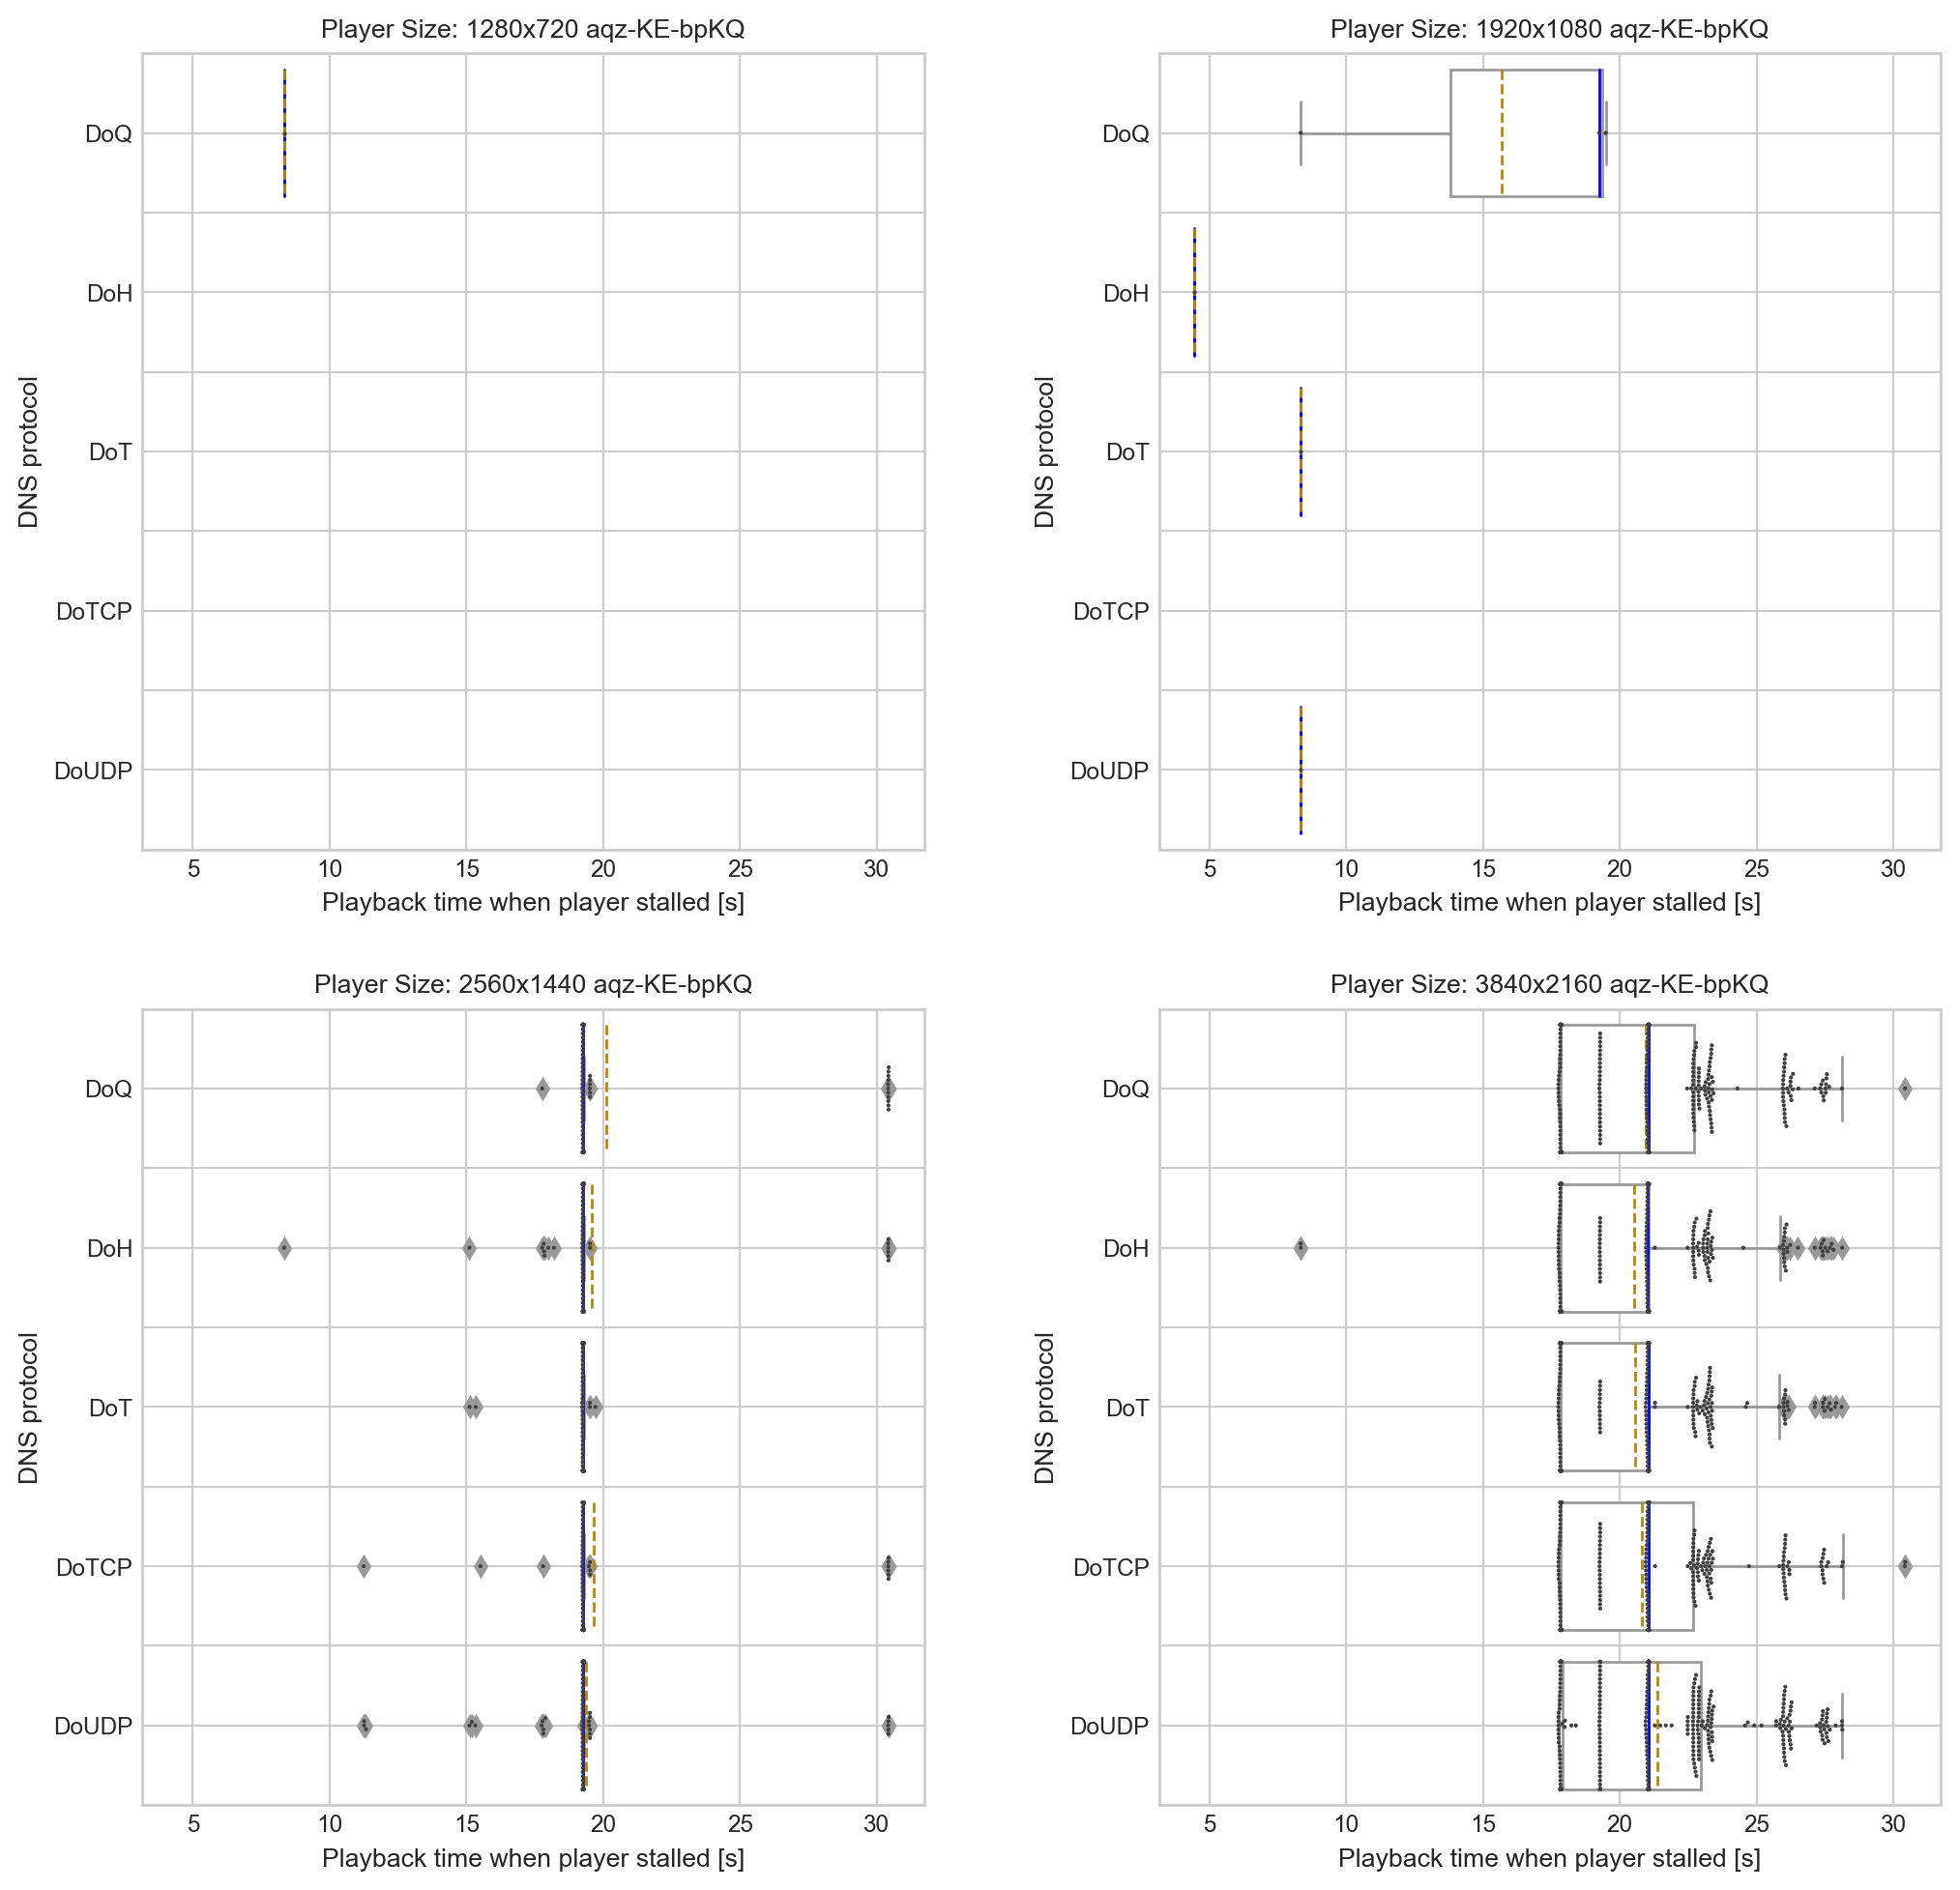

In [120]:
draw_boxplot_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True, False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

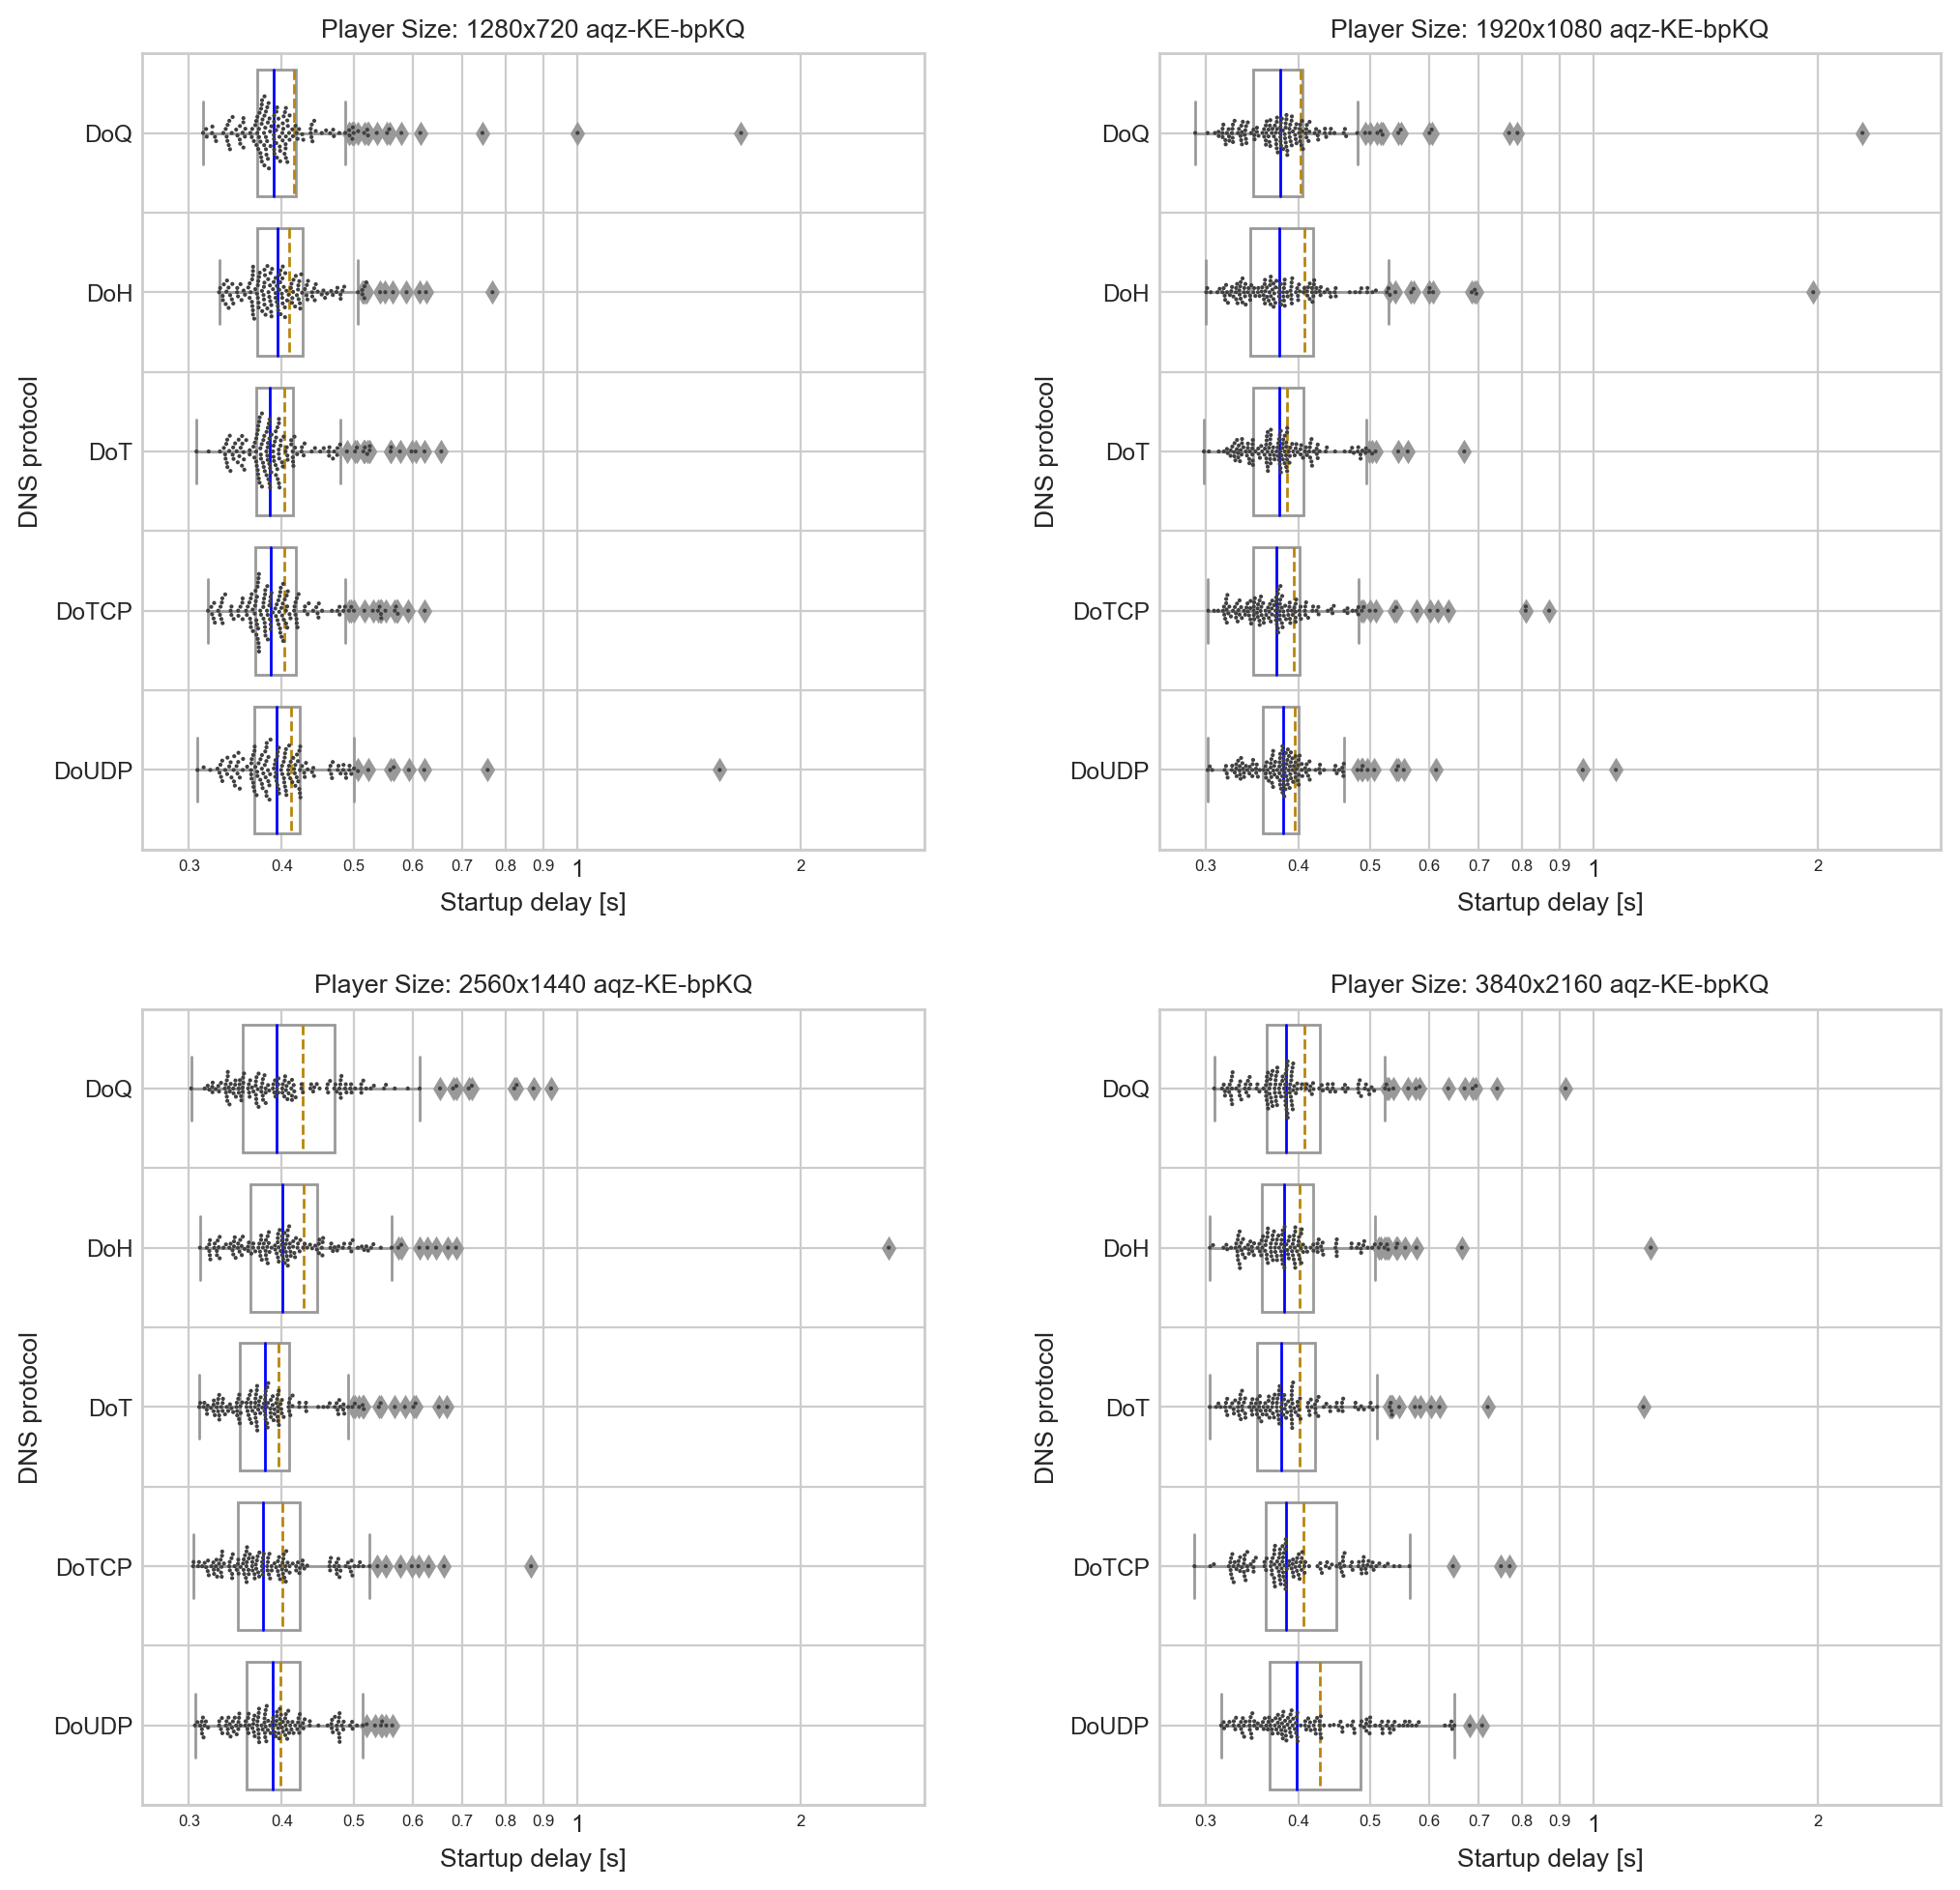

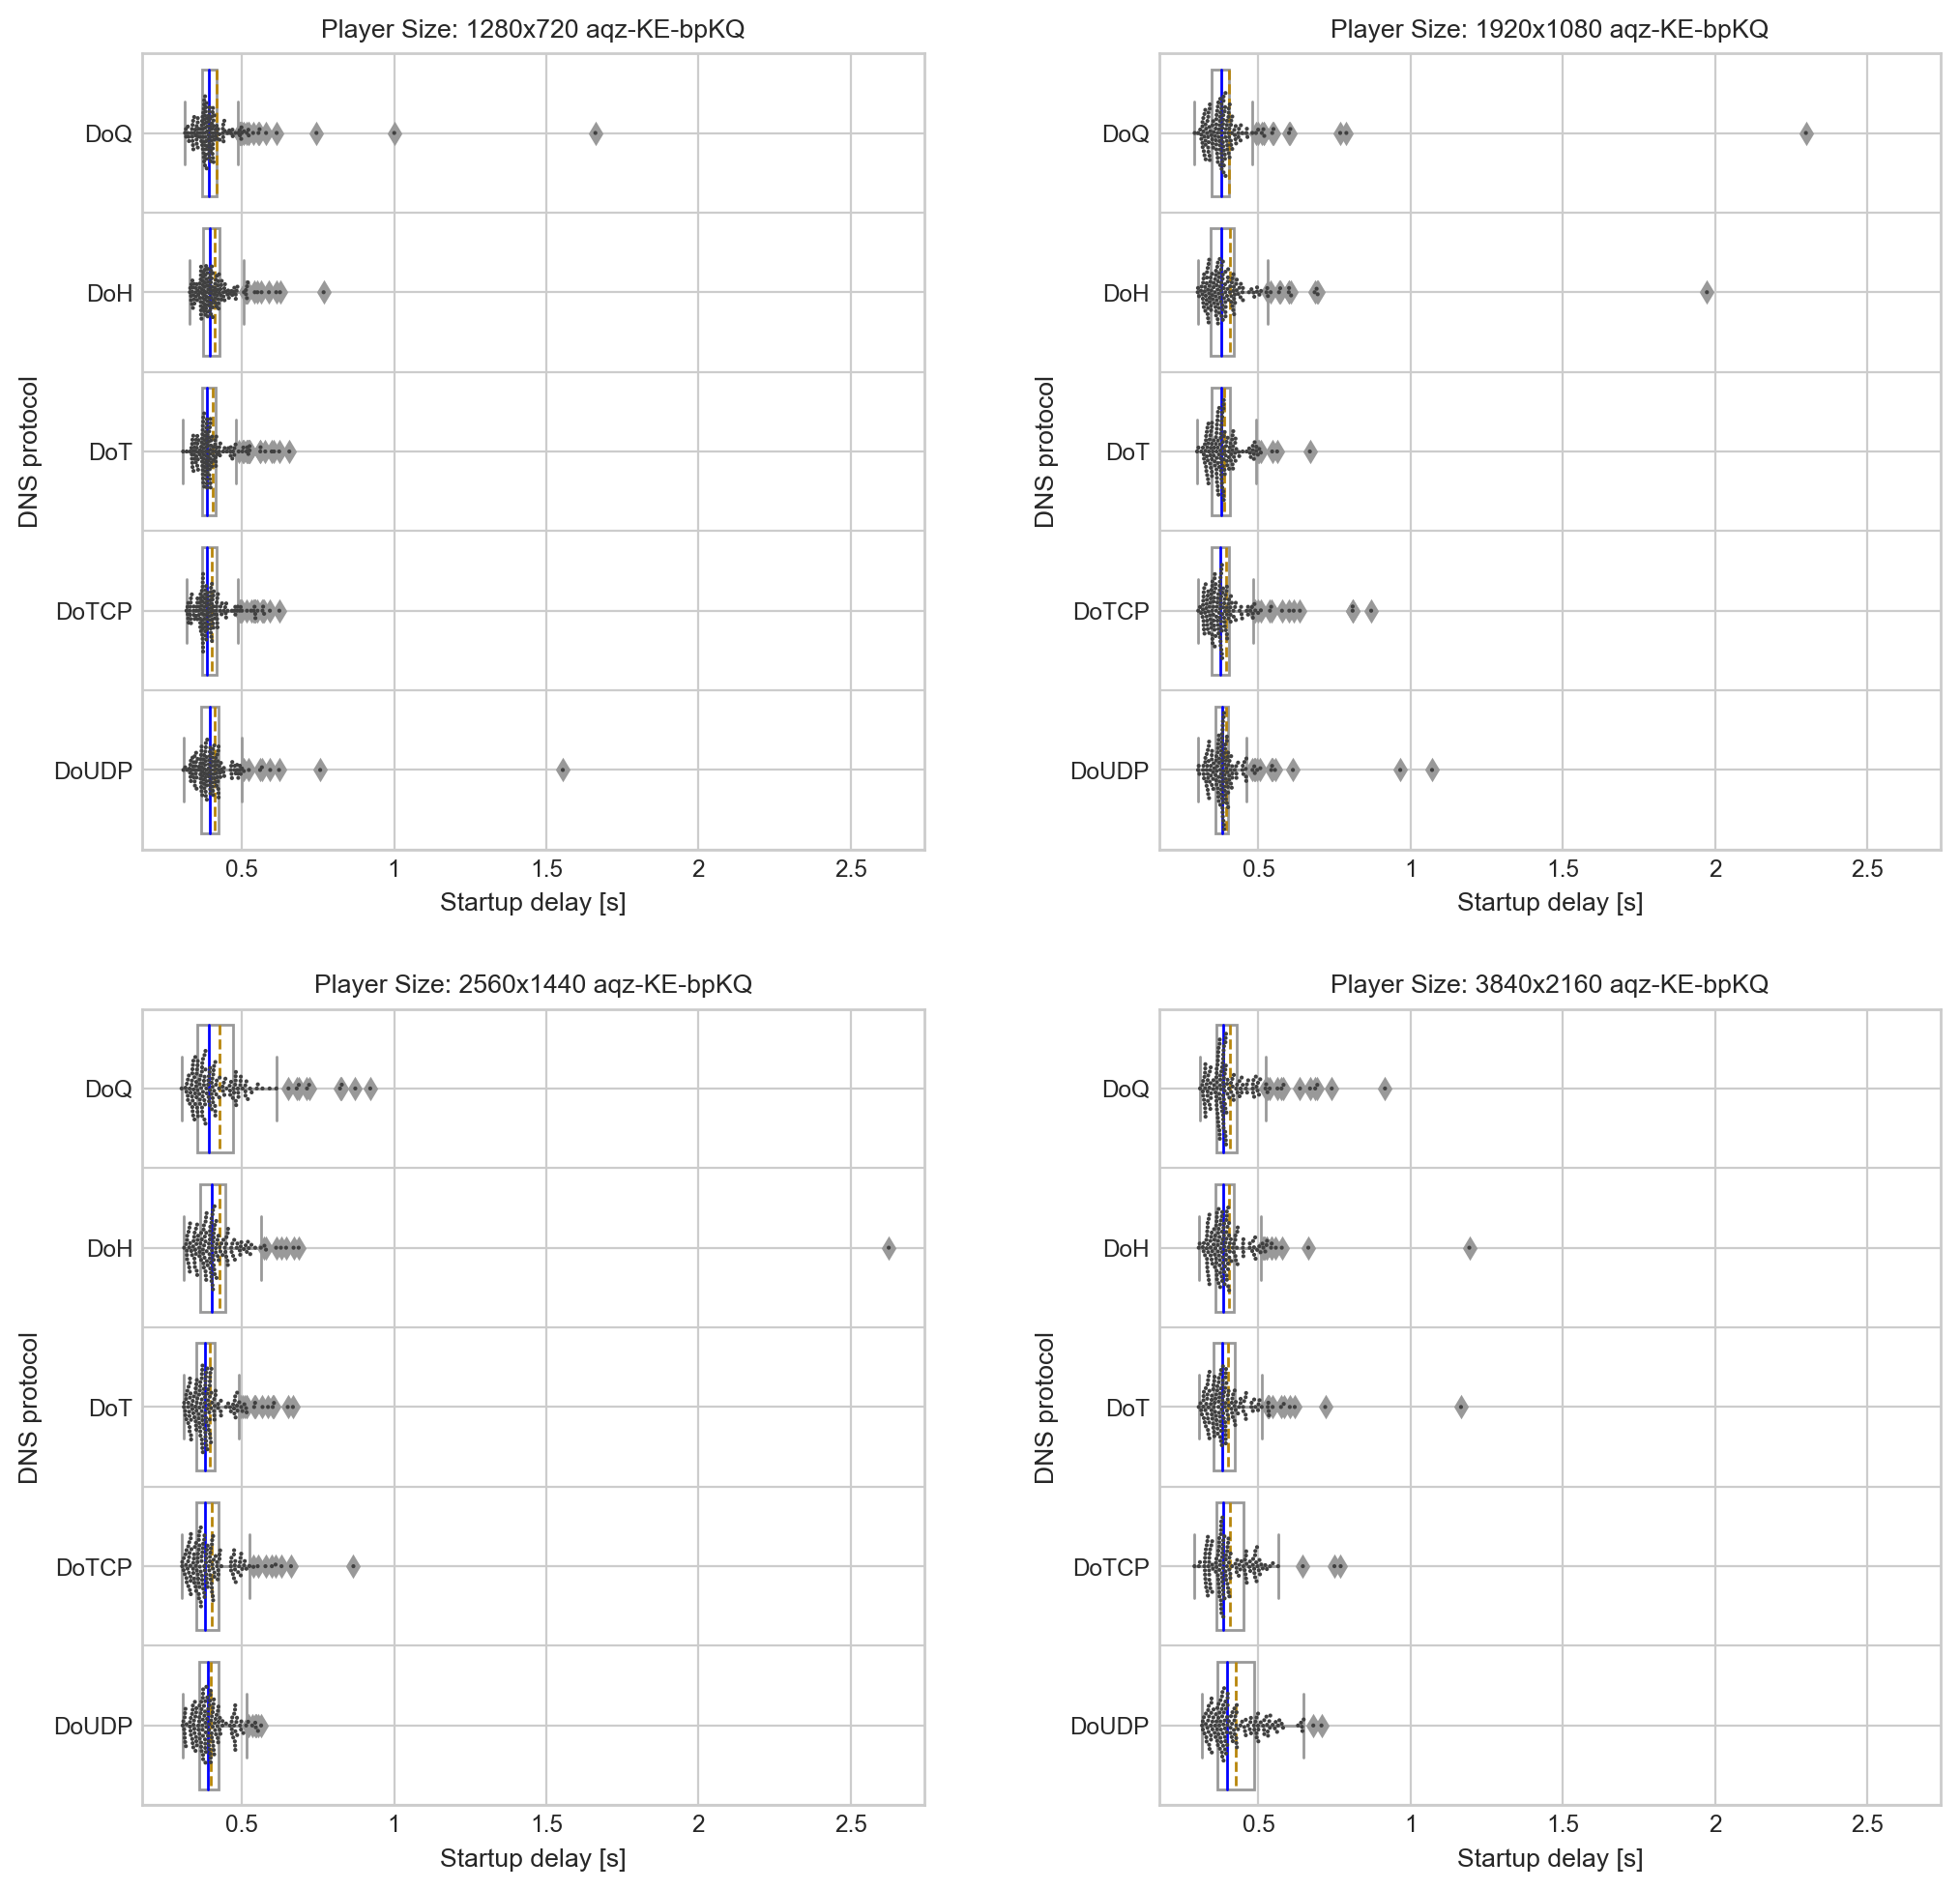

In [121]:
draw_boxplot_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True, False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

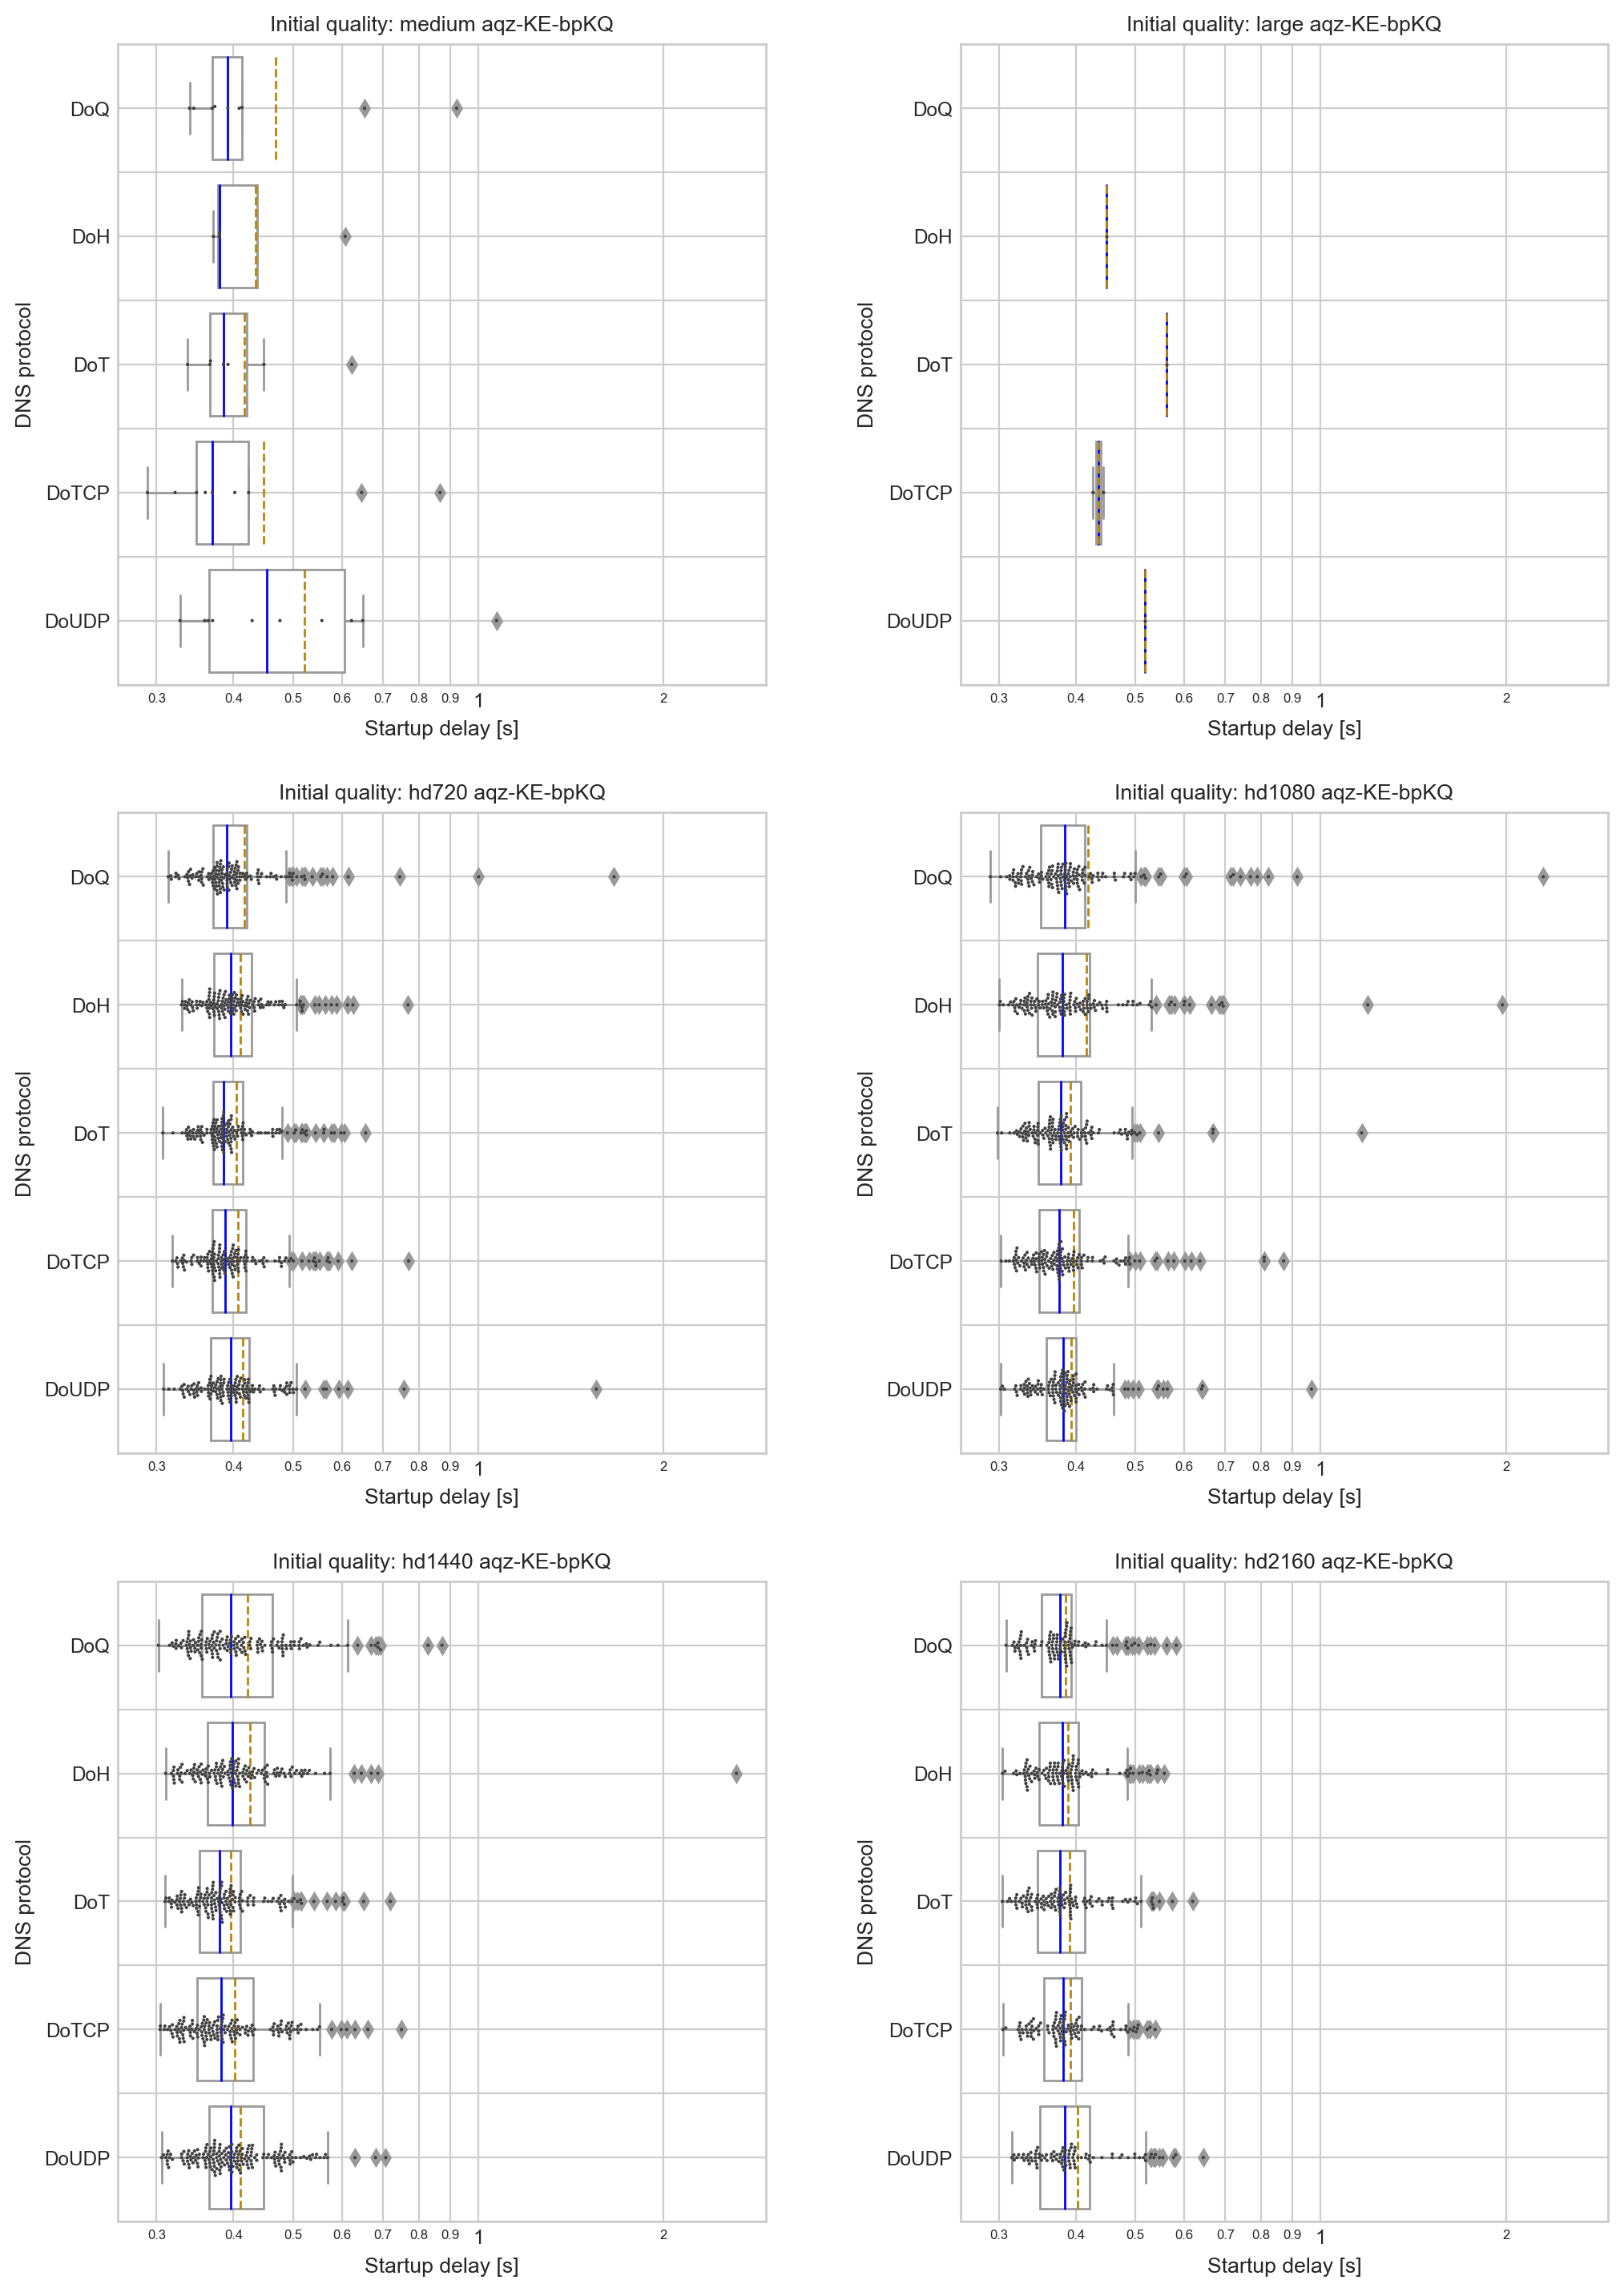

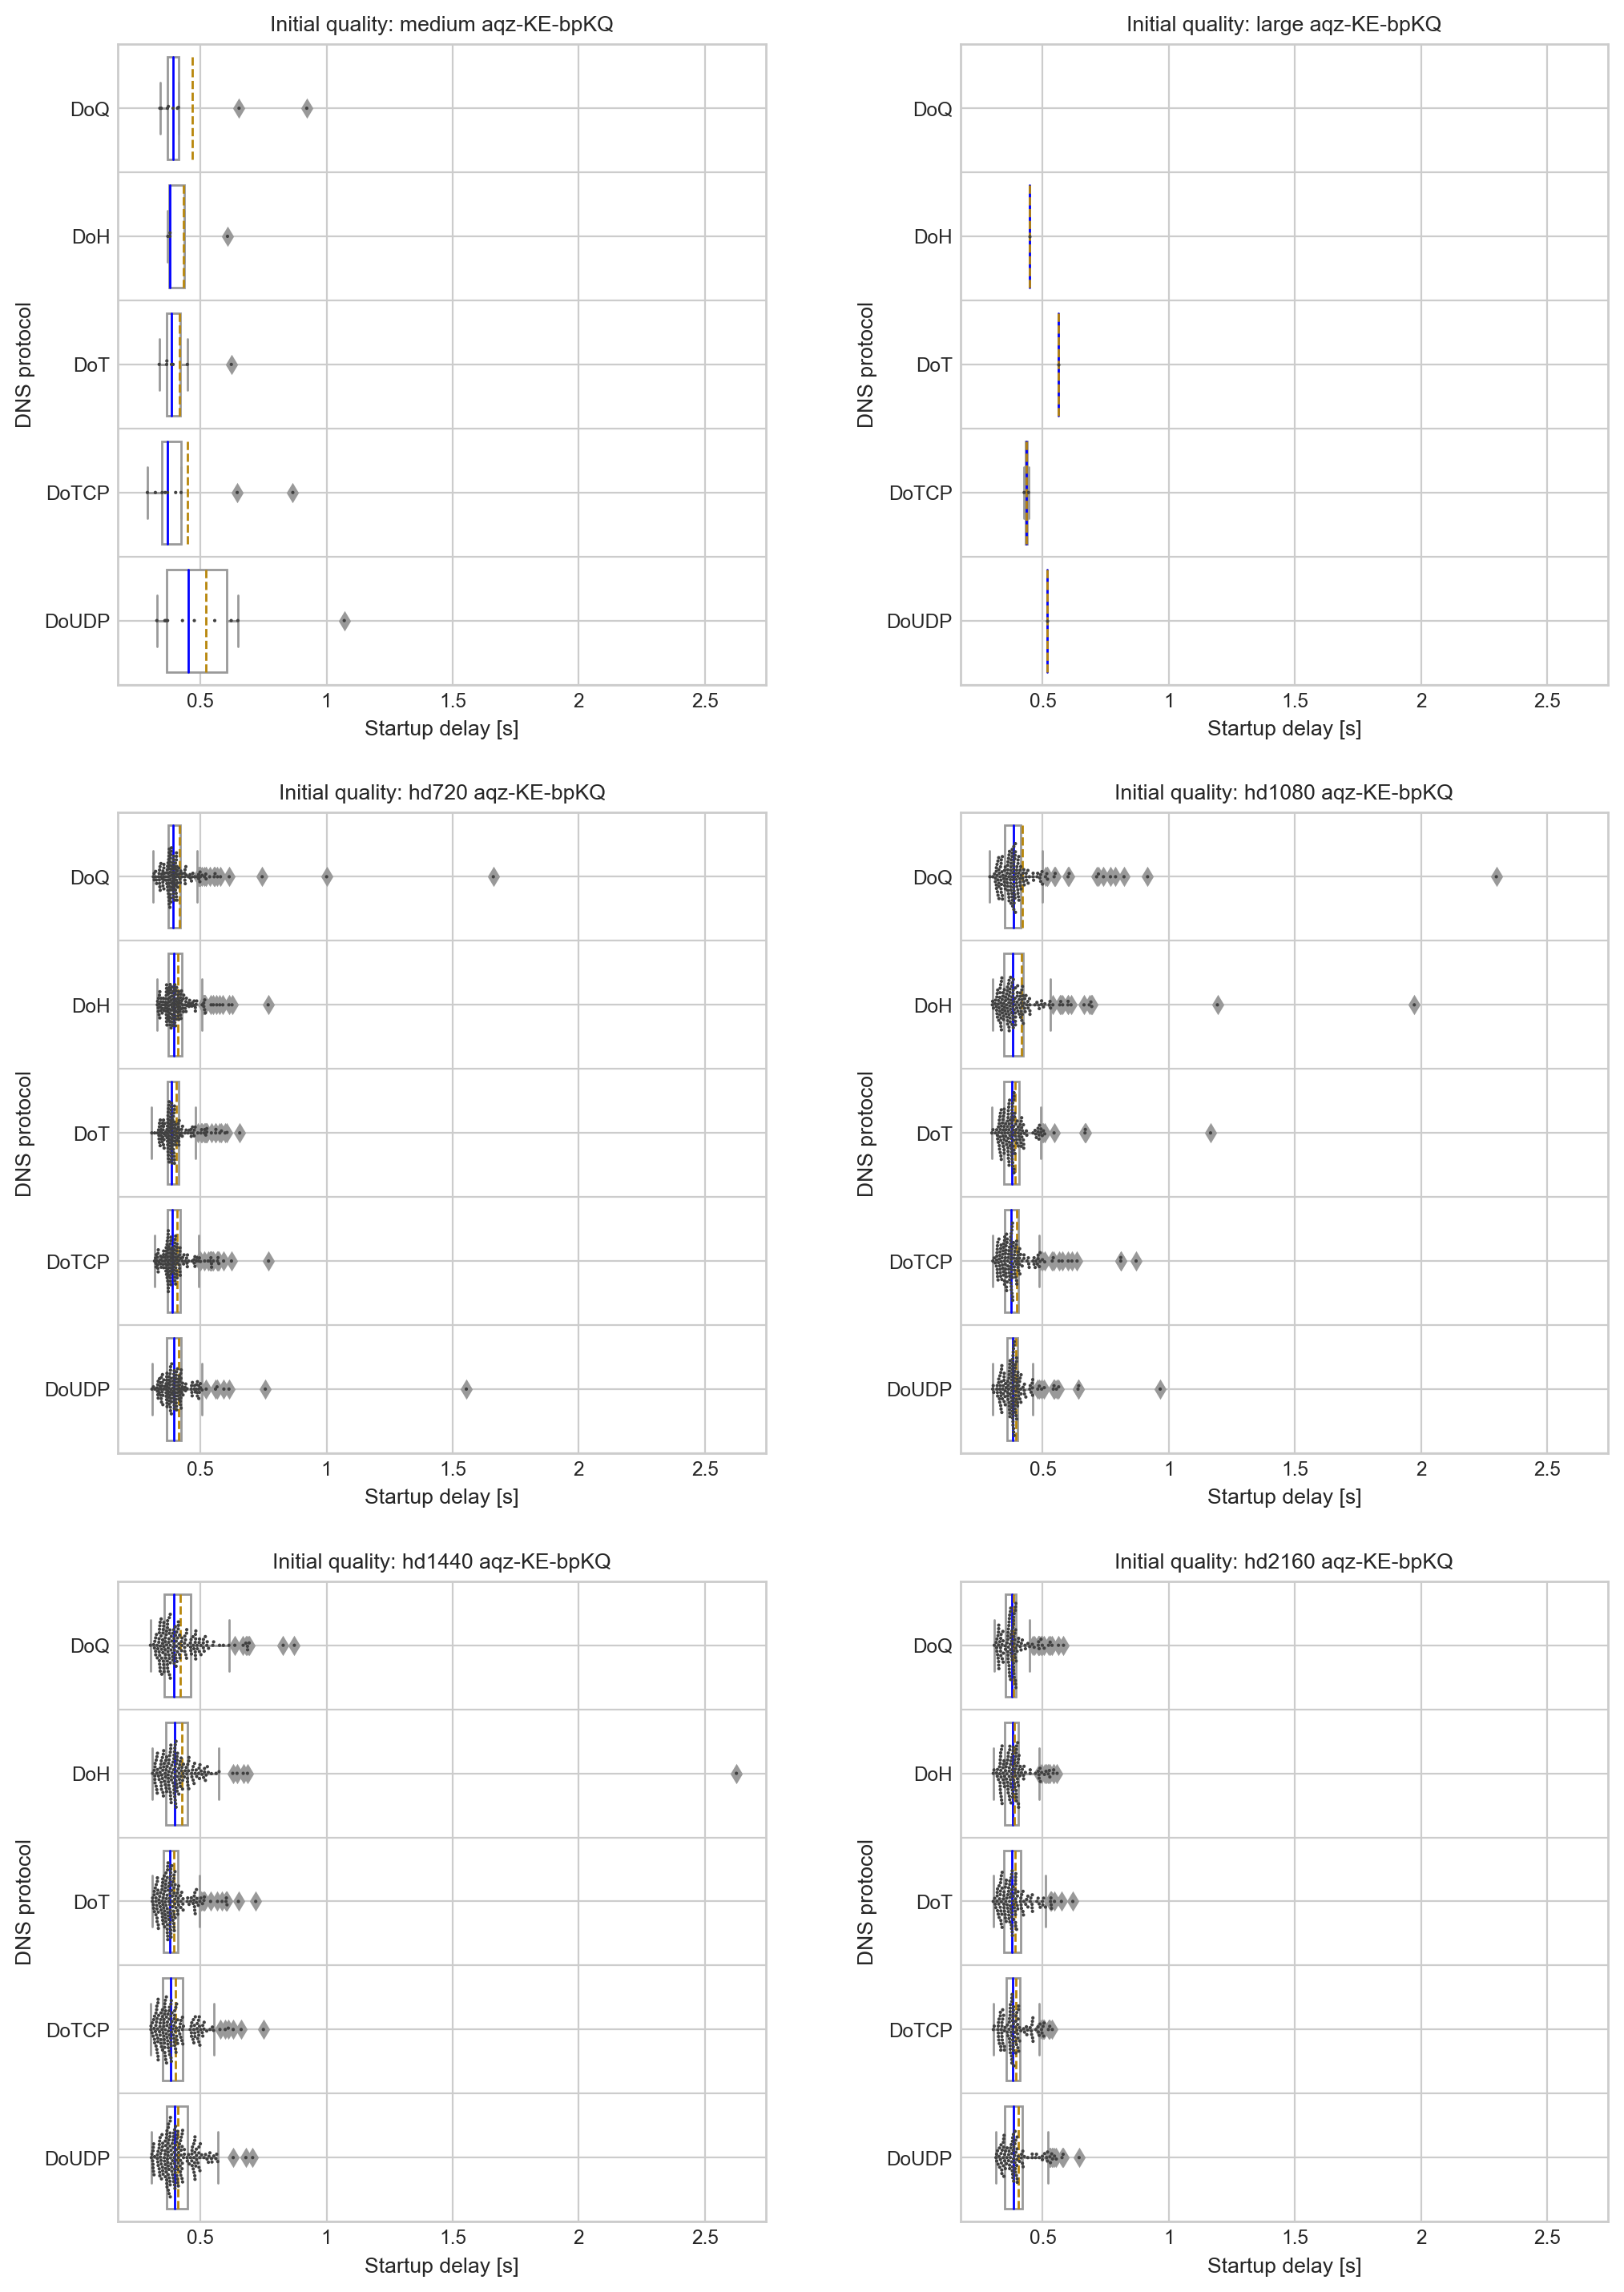

In [122]:
draw_boxplot_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True, False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


In [ ]:
draw_boxplot(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


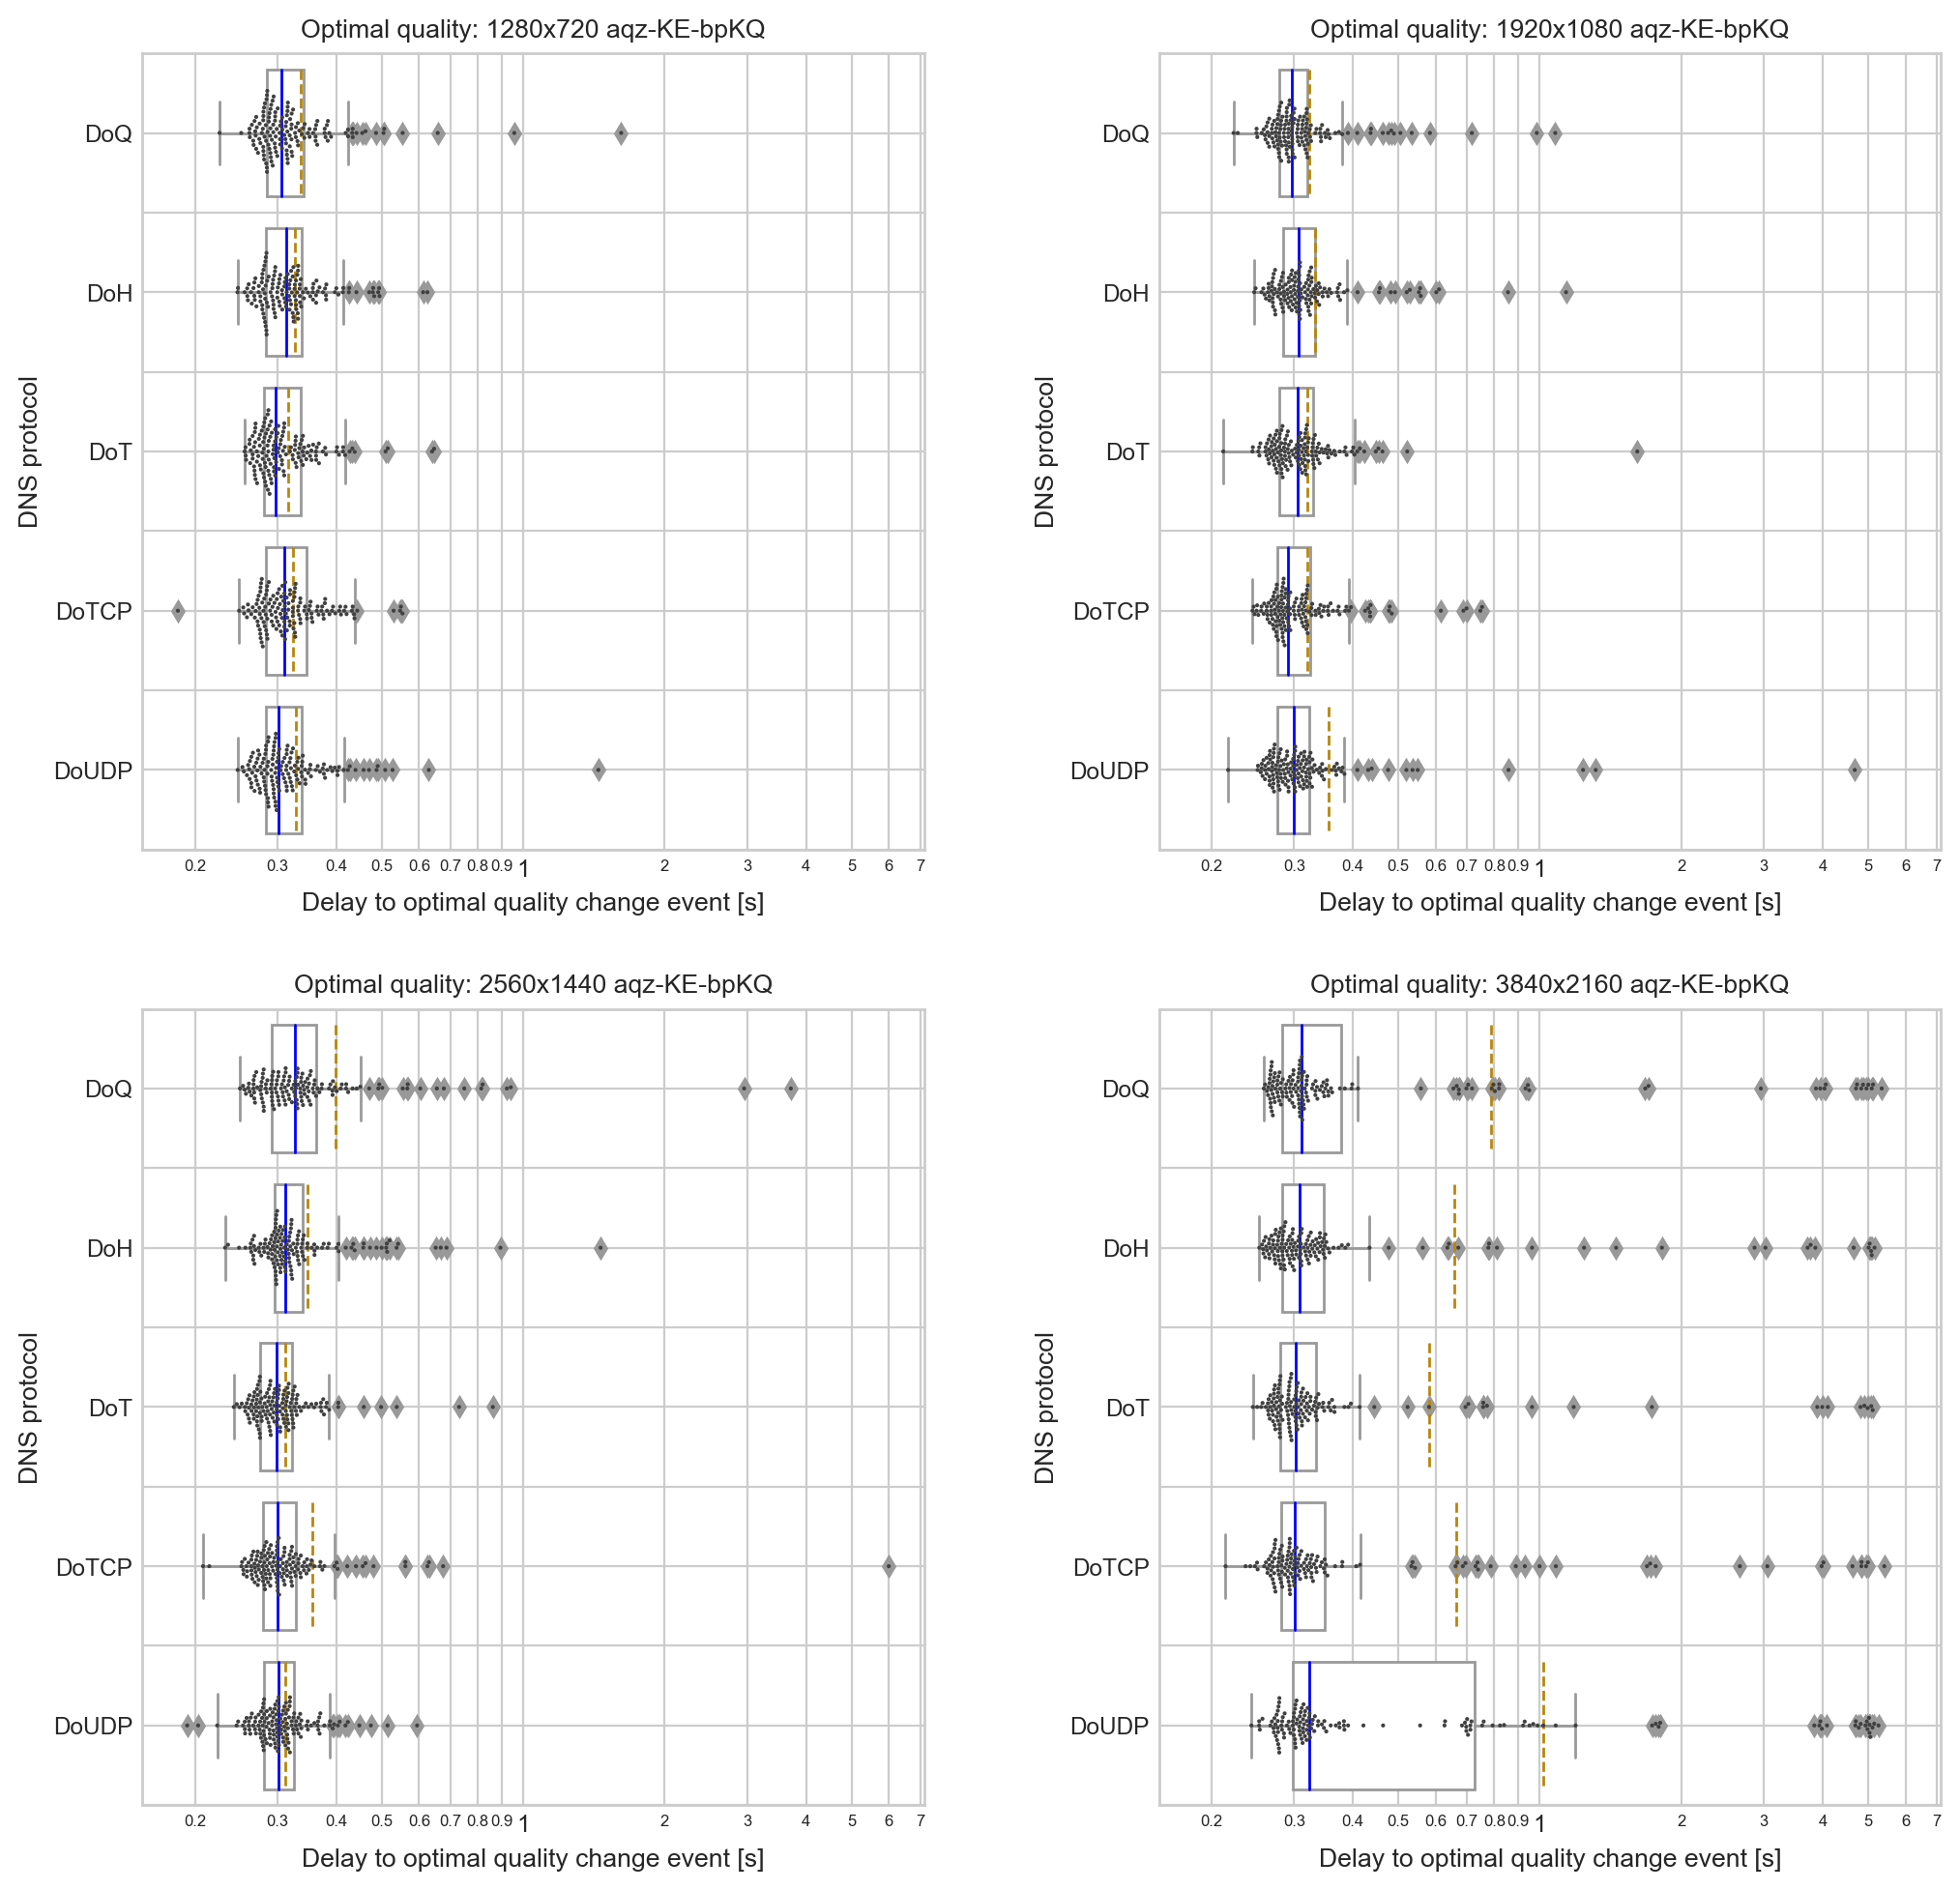

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

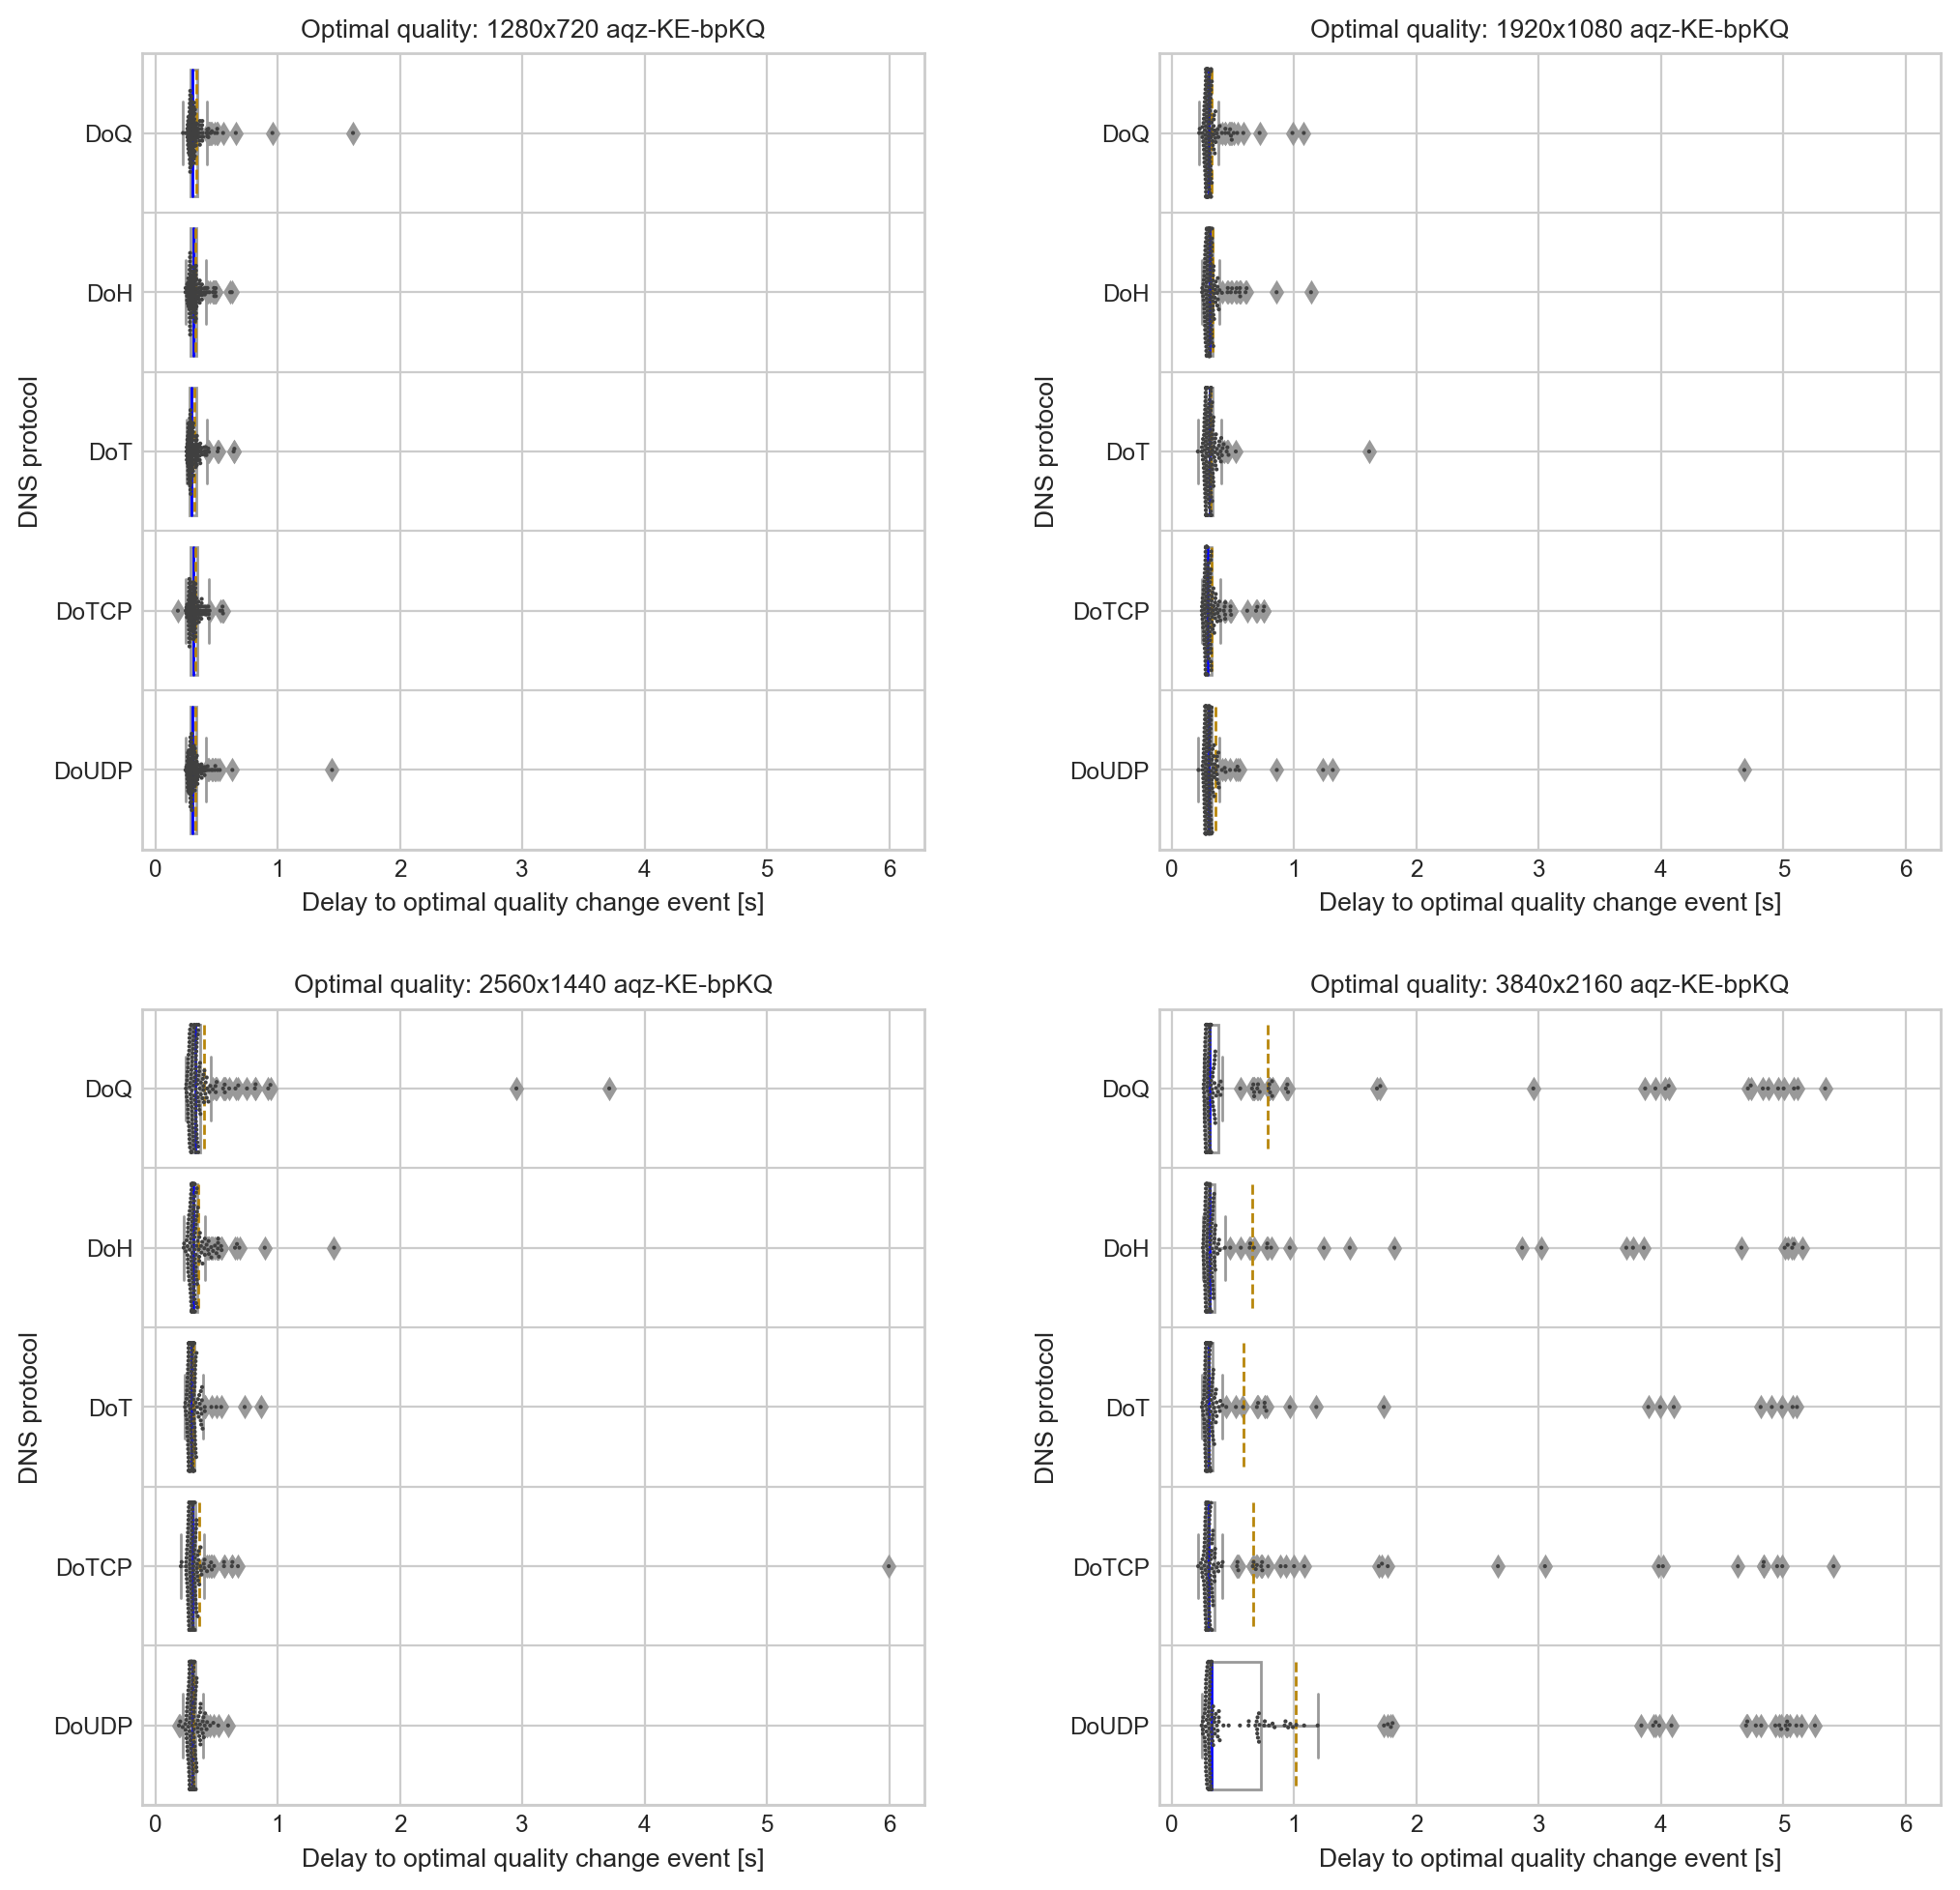

In [123]:
draw_boxplot_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True, False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [ ]:
conn.close()